# 8. Relação das tabelas com _target_ - ideias principais para _feature engineering_

## 8.1. Logs

In [ ]:
logs_vars = [
    "num_25",
    "num_50",
    "num_75",
    "num_985",
    "num_100",
    "num_unq",
    "total_secs",
]

df_base_logs = df_base.select("msno", "safra", "target", "target_win", *logs_vars)

### 8.1.1. Correlacao geral

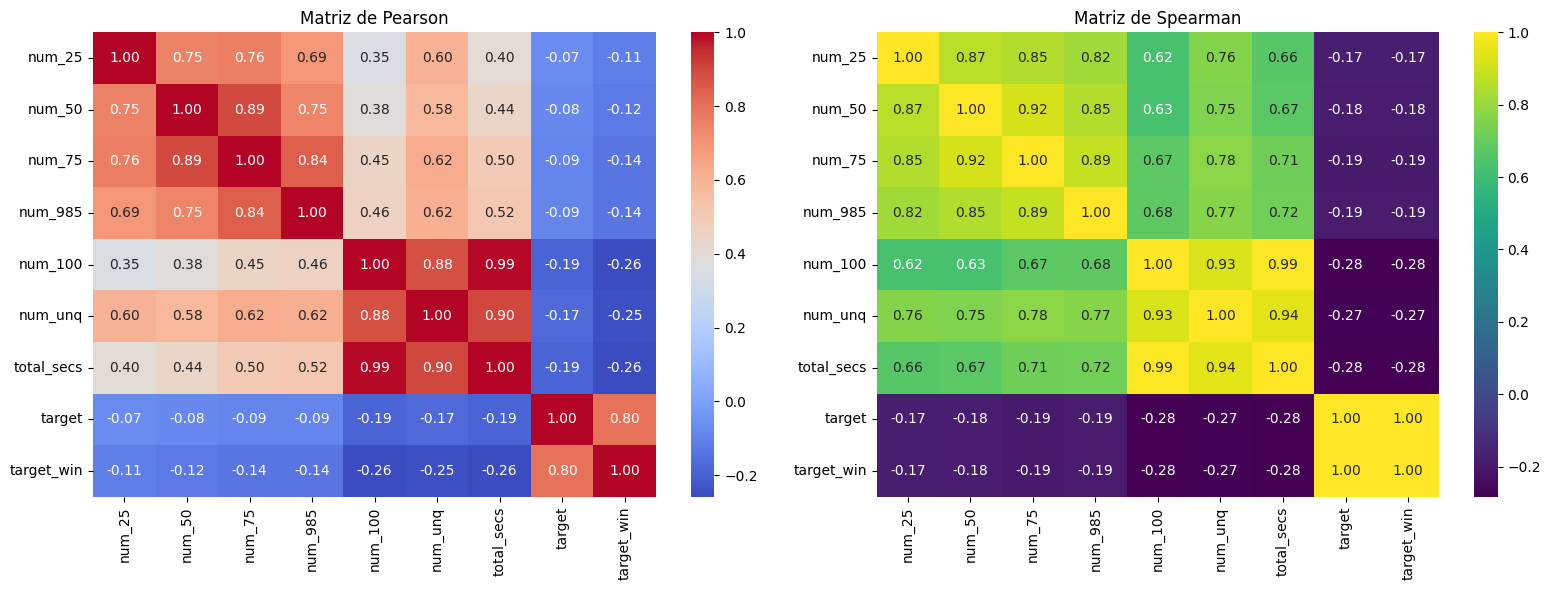

(              num_25    num_50    num_75   num_985   num_100   num_unq  \
 num_25      1.000000  0.753741  0.759602  0.693400  0.354383  0.604572   
 num_50      0.753741  1.000000  0.894074  0.745172  0.384573  0.578439   
 num_75      0.759602  0.894074  1.000000  0.842939  0.448068  0.622874   
 num_985     0.693400  0.745172  0.842939  1.000000  0.461307  0.615890   
 num_100     0.354383  0.384573  0.448068  0.461307  1.000000  0.881767   
 num_unq     0.604572  0.578439  0.622874  0.615890  0.881767  1.000000   
 total_secs  0.399223  0.437446  0.501727  0.517786  0.993097  0.898821   
 target     -0.069657 -0.079140 -0.089230 -0.089948 -0.185600 -0.173459   
 target_win -0.110813 -0.124994 -0.137714 -0.136597 -0.256659 -0.246365   
 
             total_secs    target  target_win  
 num_25        0.399223 -0.069657   -0.110813  
 num_50        0.437446 -0.079140   -0.124994  
 num_75        0.501727 -0.089230   -0.137714  
 num_985       0.517786 -0.089948   -0.136597  
 num_100

In [ ]:
correlation_matrix(df_base_logs, logs_vars + ["target", "target_win"])

### 8.1.2. flag_has_logs

Presente ou nao na base de logs.

In [ ]:
df_base_logs = df_base_logs.withColumn("flag_has_logs", F.when(F.col("total_secs").isNull(), 0).otherwise(1))

In [ ]:
calcular_distribuicao(df_base_logs, ["flag_has_logs"])

+-------------+-------+---------+
|flag_has_logs|total  |pct_total|
+-------------+-------+---------+
|1            |9975880|88.73    |
|0            |1266985|11.27    |
+-------------+-------+---------+



DataFrame[flag_has_logs: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_has_logs...


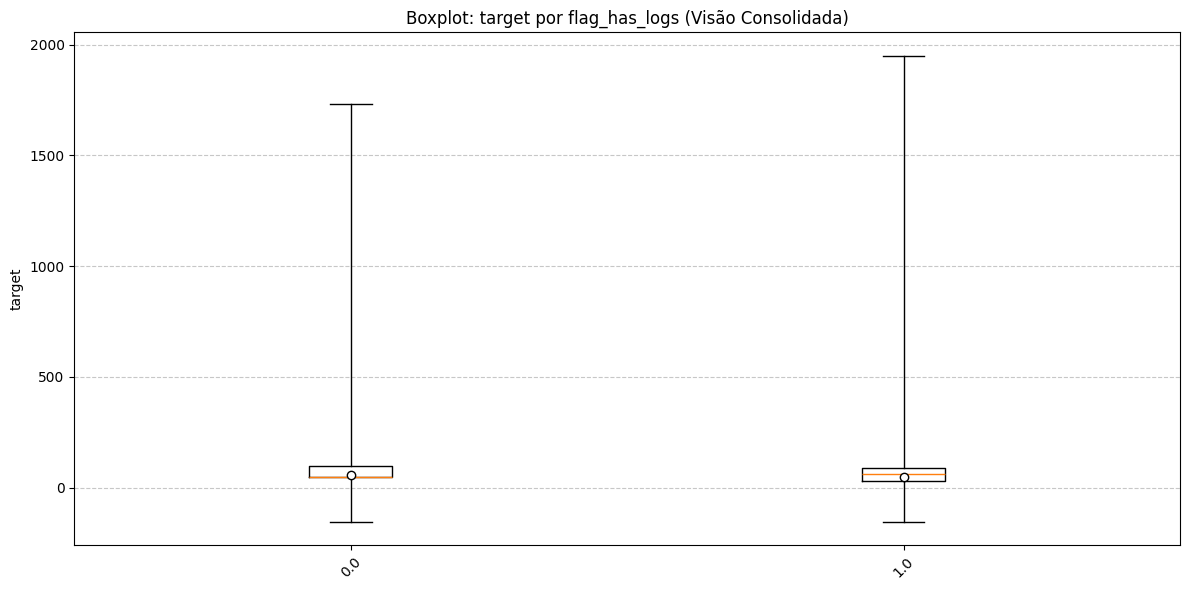


--- Estatísticas: flag_has_logs (Visão Consolidada) ---


flag_has_logs       min         q1        med       mean         q3  \
1              0 -152.5452  49.000000  49.000000  59.177692  99.000000   
0              1 -152.5452  28.205901  63.178193  47.690904  90.054096   

           max  
1  1733.833386  
0  1950.000000

In [ ]:
plot_boxplot(df_base_logs, ["flag_has_logs"], "target", table=True)

Processando estatísticas para: flag_has_logs...


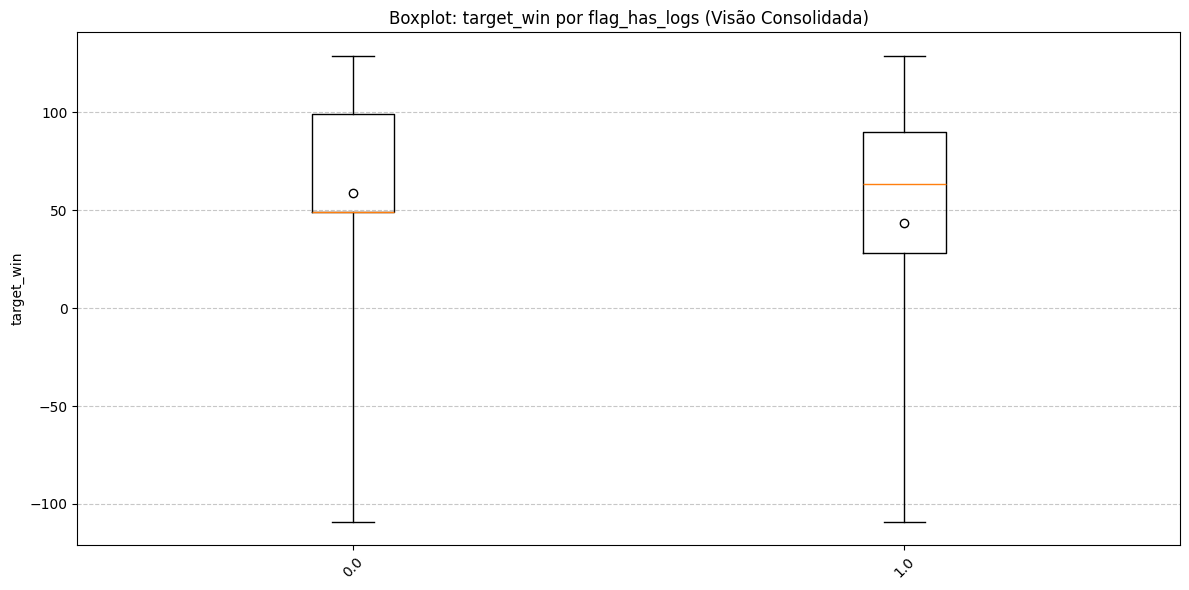


--- Estatísticas: flag_has_logs (Visão Consolidada) ---


flag_has_logs         min         q1        med       mean         q3  \
1              0 -108.964925  49.000000  49.000000  58.826712  99.000000   
0              1 -108.964925  28.205901  63.178193  43.633896  90.054096   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["flag_has_logs"], "target_win", table=True)

### 8.1.3. total_plays

In [ ]:
df_base_logs = df_base_logs.withColumn("total_plays", F.col("num_25") + F.col("num_50") + F.col("num_75") + F.col("num_985") + F.col("num_100"))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("total_plays").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-----------------+
|summary|      total_plays|
+-------+-----------------+
|  count|          9975880|
|   mean|685.8388238431096|
| stddev| 748.163833373172|
|    min|              1.0|
|     1%|              2.0|
|     5%|             18.0|
|    25%|            164.0|
|    50%|            443.0|
|    75%|            932.0|
|    95%|           2242.0|
|  99.5%|           3780.0|
|    max|           4630.0|
+-------+-----------------+



In [ ]:
df_base_logs.select("total_plays", "target").corr("total_plays", "target")

-0.15308296170078672

In [ ]:
df_base_logs.select("total_plays", "target_win").corr("total_plays", "target_win")

-0.21555169062632873

Correlacao negativa e relativamente baixa: quanto mais musicas escutadas (completas ou nao), menor valor de target

#### Agrupamento por decis

In [ ]:
df_base_logs.select("total_plays").summary("count", "mean", "stddev", "min", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "max").show()

+-------+-----------------+
|summary|      total_plays|
+-------+-----------------+
|  count|          9975880|
|   mean|685.8388238431096|
| stddev| 748.163833373172|
|    min|              1.0|
|    10%|             46.0|
|    20%|            120.0|
|    30%|            211.0|
|    40%|            317.0|
|    50%|            443.0|
|    60%|            598.0|
|    70%|            801.0|
|    80%|           1097.0|
|    90%|           1638.0|
|    max|           4630.0|
+-------+-----------------+



In [ ]:
df_base_logs = df_base_logs.withColumn("total_plays_group",
    F.when(F.col("flag_has_logs").isin(0), "unknown")\
    .when(F.col("total_plays").between(1, 46), "p10")\
    .when(F.col("total_plays").between(47, 120), "p20")\
    .when(F.col("total_plays").between(121, 211), "p30")\
    .when(F.col("total_plays").between(212, 317), "p40")\
    .when(F.col("total_plays").between(318, 443), "p50")\
    .when(F.col("total_plays").between(444, 598), "p60")\
    .when(F.col("total_plays").between(599, 801), "p70")\
    .when(F.col("total_plays").between(802, 1097), "p80")\
    .when(F.col("total_plays").between(1098, 1638), "p90")\
    .otherwise("p90+")
)

In [ ]:
calcular_distribuicao(df_base_logs, ["total_plays_group"])

+-----------------+-------+---------+
|total_plays_group|total  |pct_total|
+-----------------+-------+---------+
|+p90             |2263654|20.13    |
|p10              |1006877|8.96     |
|p30              |1003579|8.93     |
|p60              |997308 |8.87     |
|p90              |997296 |8.87     |
|p80              |996967 |8.87     |
|p50              |996268 |8.86     |
|p70              |995794 |8.86     |
|p40              |994730 |8.85     |
|p20              |990392 |8.81     |
+-----------------+-------+---------+



DataFrame[total_plays_group: string, total: bigint, pct_total: double]

Processando estatísticas para: total_plays_group...


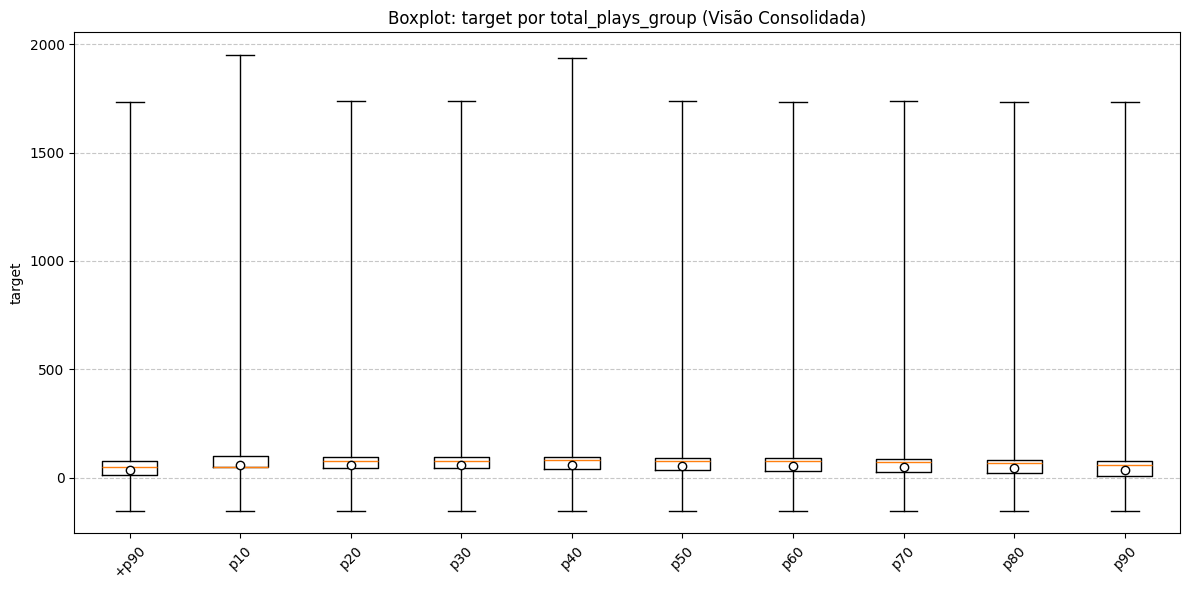


--- Estatísticas: total_plays_group (Visão Consolidada) ---


total_plays_group       min         q1        med       mean         q3  \
1              +p90 -152.5452  11.743867  49.000000  36.270471  78.098894   
4               p10 -152.5452  47.816344  49.000000  58.723051  97.750115   
3               p20 -152.5452  45.577824  74.819067  59.336415  96.672926   
2               p30 -152.5452  43.116862  77.519916  58.474130  95.242394   
8               p40 -152.5452  40.219816  79.451847  56.856944  93.559796   
9               p50 -152.5452  36.710126  78.819060  54.406560  91.577108   
6               p60 -152.5452  32.543869  76.582929  51.756862  89.256250   
5               p70 -152.5452  27.326239  73.081341  48.392427  86.318137   
7               p80 -152.5452  19.899592  68.034976  43.812993  82.433442   
0               p90 -152.5452   6.999107  59.234548  36.448164  76.231174   

           max  
1  1733.833386  
4  1950.000000  
3  1737.241320  
2  1737.711061  
8  1936.799455  
9  1736.987900  
6  1735.253213  
5  1736.541069  
7  1734.140378  
0  1735.146209

In [ ]:
plot_boxplot(df_base_logs, ["total_plays_group"], "target", table=True)

Processando estatísticas para: total_plays_group...


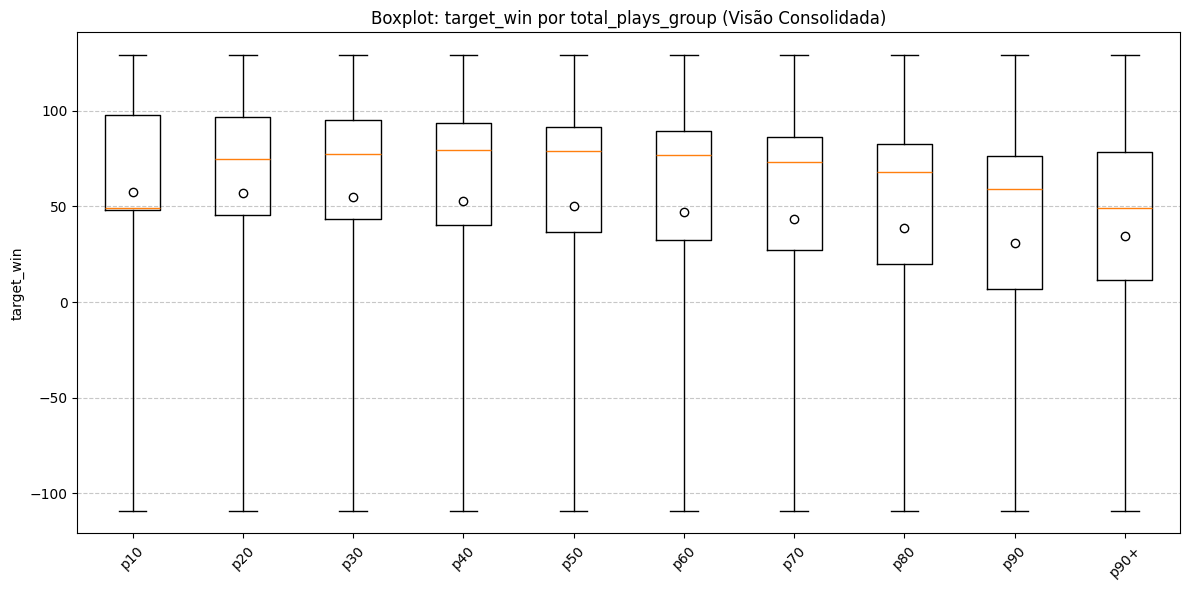


--- Estatísticas: total_plays_group (Visão Consolidada) ---


total_plays_group         min         q1        med       mean         q3  \
4               p10 -108.964925  47.816344  49.000000  57.232945  97.750115   
3               p20 -108.964925  45.577824  74.819067  56.688432  96.672926   
2               p30 -108.964925  43.116862  77.519916  55.083761  95.242394   
8               p40 -108.964925  40.219816  79.451847  52.876757  93.559796   
9               p50 -108.964925  36.710126  78.819060  50.039286  91.577108   
6               p60 -108.964925  32.543869  76.582929  46.983059  89.256250   
5               p70 -108.964925  27.326239  73.081341  43.285811  86.318137   
7               p80 -108.964925  19.899592  68.034976  38.445000  82.433442   
0               p90 -108.964925   6.999107  59.234548  30.786098  76.231174   
1              p90+ -108.964925  11.743867  49.000000  34.450294  78.098894   

          max  
4  128.953521  
3  128.953521  
2  128.953521  
8  128.953521  
9  128.953521  
6  128.953521  
5  128.953521  
7  128.953521  
0  128.953521  
1  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["total_plays_group"], "target_win", table=True)

#### Agrupamento por quartis

In [ ]:
df_base_logs.select("total_plays").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+-----------------+
|summary|      total_plays|
+-------+-----------------+
|  count|          9975880|
|   mean|685.8388238431096|
| stddev| 748.163833373172|
|    min|              1.0|
|    25%|            164.0|
|    50%|            443.0|
|    75%|            932.0|
|    max|           4630.0|
+-------+-----------------+



In [ ]:
df_base_logs = df_base_logs.withColumn("total_plays_group",
    F.when(F.col("flag_has_logs").isin(0), "unknown")\
    .when(F.col("total_plays").between(1, 164), "p25")\
    .when(F.col("total_plays").between(165, 443), "p50")\
    .when(F.col("total_plays").between(444, 932), "p75")\
    .otherwise("p75+")
)

# Analise pelos valores brutos: pode ocasionar problemas na performance futura do modelo, com a mudanca da distribuicao dos valores da var

In [ ]:
calcular_distribuicao(df_base_logs, ["total_plays_group"])

+-----------------+-------+---------+
|total_plays_group|total  |pct_total|
+-----------------+-------+---------+
|p25              |2502893|22.26    |
|p75+             |2493687|22.18    |
|p75              |2490347|22.15    |
|p50              |2488953|22.14    |
|unknown          |1266985|11.27    |
+-----------------+-------+---------+



DataFrame[total_plays_group: string, total: bigint, pct_total: double]

Processando estatísticas para: total_plays_group...


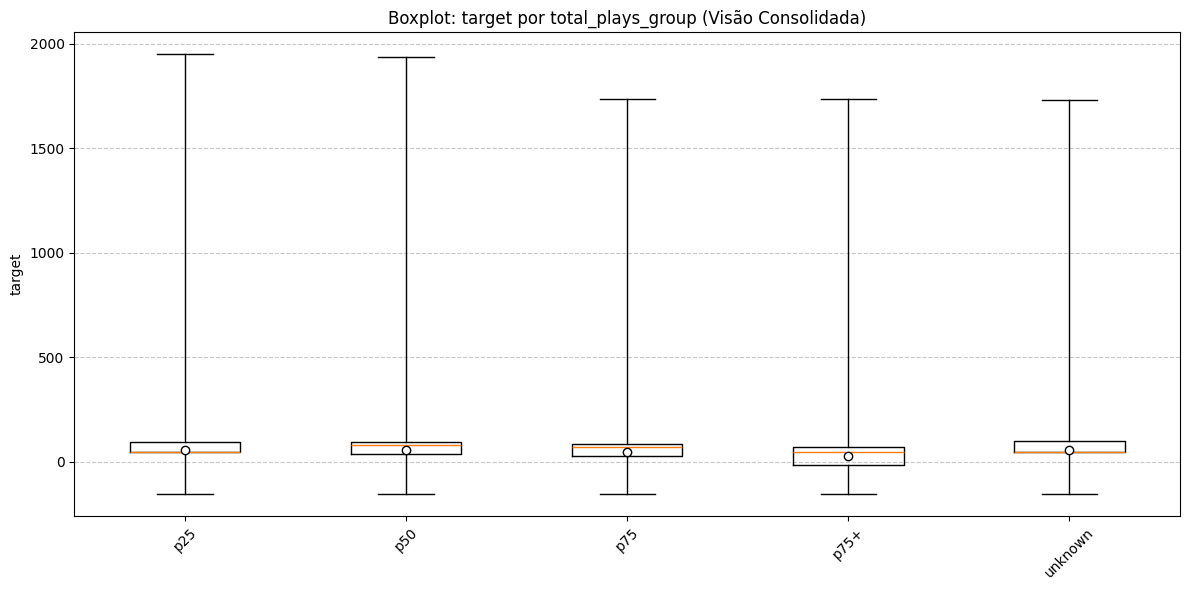


--- Estatísticas: total_plays_group (Visão Consolidada) ---


total_plays_group       min         q1        med       mean         q3  \
0               p25 -152.5452  46.211867  49.000000  59.002846  96.806022   
4               p50 -152.5452  39.313317  78.853285  56.113354  93.126420   
2               p75 -152.5452  28.287261  73.315000  49.063618  87.193322   
3              p75+ -152.5452 -12.338117  45.704088  27.411001  73.146944   
1           unknown -152.5452  49.000000  49.000000  59.177692  99.000000   

           max  
0  1950.000000  
4  1936.799455  
2  1736.541069  
3  1735.146209  
1  1733.833386

In [ ]:
plot_boxplot(df_base_logs, ["total_plays_group"], "target", table=True)

Processando estatísticas para: total_plays_group...


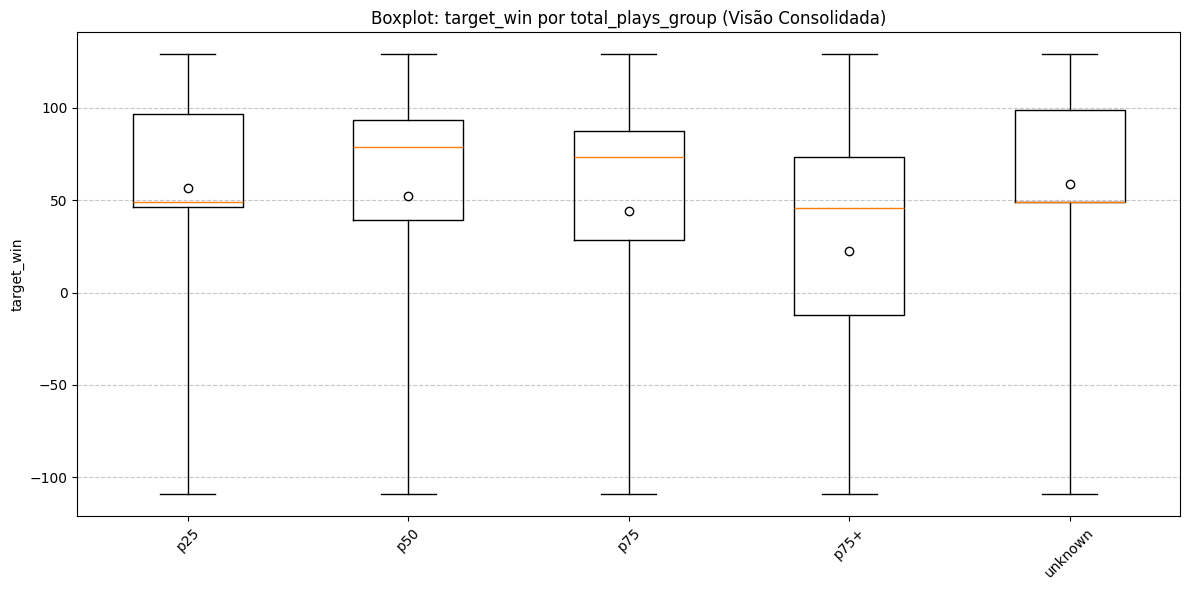


--- Estatísticas: total_plays_group (Visão Consolidada) ---


total_plays_group         min         q1        med       mean         q3  \
0               p25 -108.964925  46.211867  49.000000  56.665533  96.806022   
4               p50 -108.964925  39.313317  78.853285  52.072322  93.126420   
2               p75 -108.964925  28.287261  73.315000  44.067086  87.193322   
3              p75+ -108.964925 -12.338117  45.704088  22.662635  73.146944   
1           unknown -108.964925  49.000000  49.000000  58.826712  99.000000   

          max  
0  128.953521  
4  128.953521  
2  128.953521  
3  128.953521  
1  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["total_plays_group"], "target_win", table=True)

A categoria unknown foi mantida como regime por representar ausencia de consumo, associada a baixo custo operacional e margens sistematicamente superiores as faixas de alto uso. Entendo que, por esta interpretacao, nao seria apropriado trata-la como dado imputavel (apesar na similaridade com as estatisticas descritivas de p25).

In [ ]:
df_base_logs = segment_by_percentile(df_base_logs, "total_plays", "logs")

In [ ]:
calcular_distribuicao(df_base_logs, ["total_plays_group"])

+-----------------+-------+---------+
|total_plays_group|total  |pct_total|
+-----------------+-------+---------+
|tier_1           |2502893|22.26    |
|tier_4           |2493687|22.18    |
|tier_3           |2490347|22.15    |
|tier_2           |2488953|22.14    |
|unknown          |1266985|11.27    |
+-----------------+-------+---------+



DataFrame[total_plays_group: string, total: bigint, pct_total: double]

Processando estatísticas para: total_plays_group...


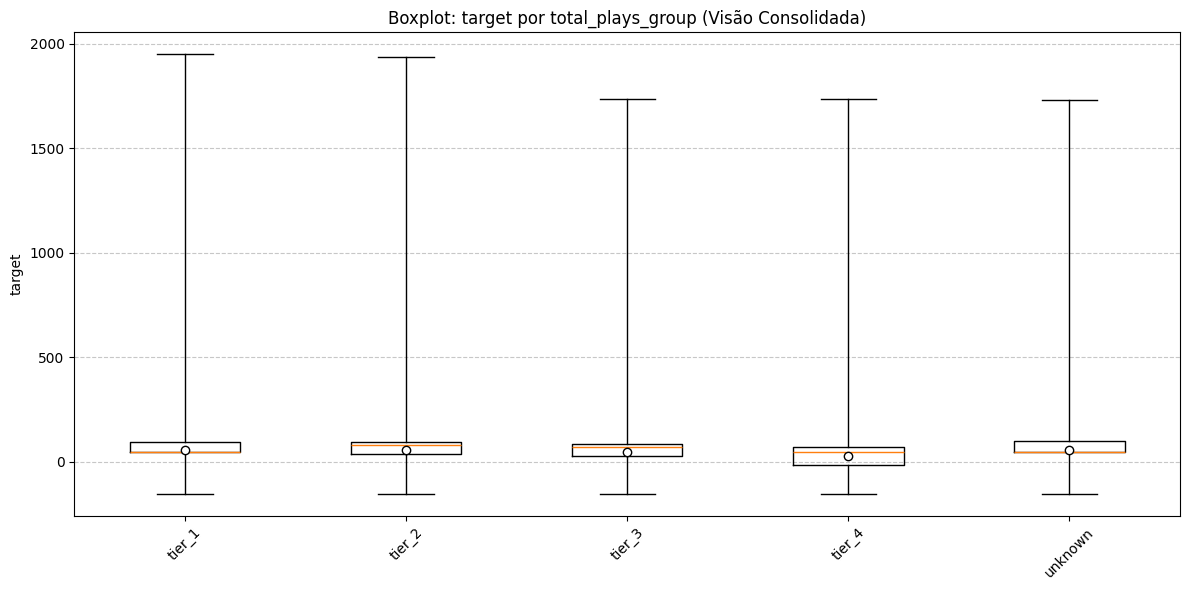


--- Estatísticas: total_plays_group (Visão Consolidada) ---


total_plays_group       min         q1        med       mean         q3  \
0            tier_1 -152.5452  46.211867  49.000000  59.002846  96.806022   
2            tier_2 -152.5452  39.313317  78.853285  56.113354  93.126420   
3            tier_3 -152.5452  28.287261  73.315000  49.063618  87.193322   
4            tier_4 -152.5452 -12.338117  45.704088  27.411001  73.146944   
1           unknown -152.5452  49.000000  49.000000  59.177692  99.000000   

           max  
0  1950.000000  
2  1936.799455  
3  1736.541069  
4  1735.146209  
1  1733.833386

In [ ]:
plot_boxplot(df_base_logs, ["total_plays_group"], "target", table=True)

Processando estatísticas para: total_plays_group...


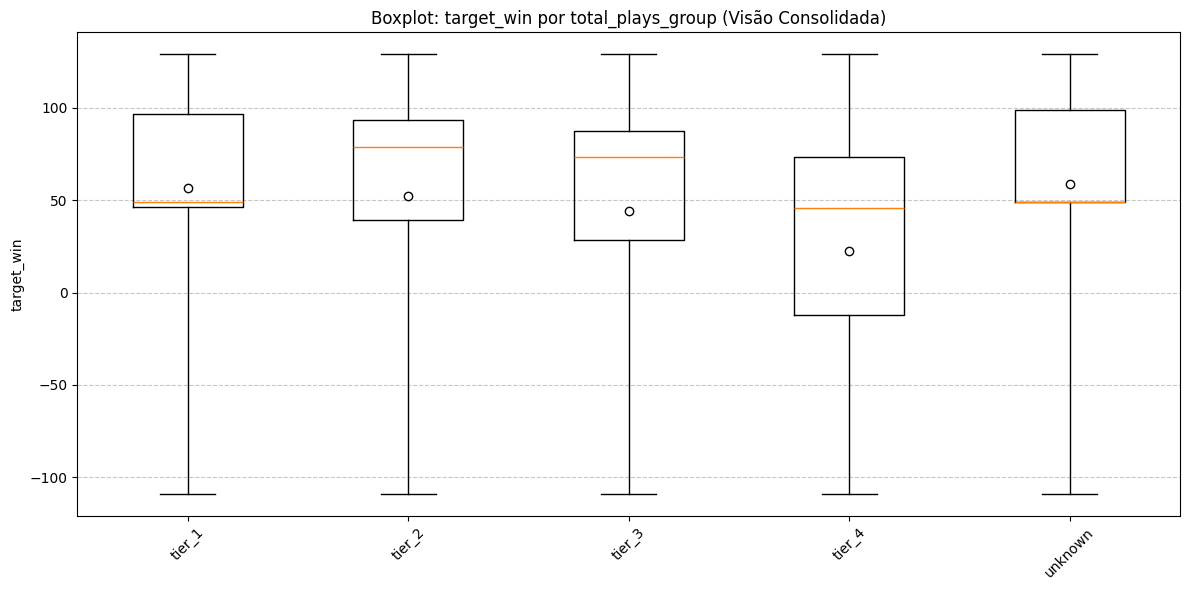


--- Estatísticas: total_plays_group (Visão Consolidada) ---


total_plays_group         min         q1        med       mean         q3  \
0            tier_1 -108.964925  46.211867  49.000000  56.665533  96.806022   
2            tier_2 -108.964925  39.313317  78.853285  52.072322  93.126420   
3            tier_3 -108.964925  28.287261  73.315000  44.067086  87.193322   
4            tier_4 -108.964925 -12.338117  45.704088  22.662635  73.146944   
1           unknown -108.964925  49.000000  49.000000  58.826712  99.000000   

          max  
0  128.953521  
2  128.953521  
3  128.953521  
4  128.953521  
1  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["total_plays_group"], "target_win", table=True)

#### Conclusao

Apesar do agrupamento por decis trazer mais granularidade, vimos a partir das estatisticas que o padrao se repete boas vezes, nao adicionando novas informacoes. Os quartis capturam melhor, sendo mais estaveis (o que implica em menor risco de overfitting e maior facilidade em regularizacao - pensando numa solucao linear com elastic net, por exemplo)

In [ ]:
df_base_logs = segment_by_percentile(df_base_logs, "total_plays", "logs")

map_total_plays = {
    "tier_1": "01_casual_listener",
    "tier_2": "02_regular_listener",
    "tier_3": "03_frequent_listener",
    "tier_4": "04_power_user"
}

### 8.1.4. completed_songs_rate

In [ ]:
# Cálculo da taxa de completude com tratamento de divisão por zero
df_base_logs = df_base_logs.withColumn("completed_songs_rate",
    F.when(F.col("total_plays") > 0, F.col("num_100") / F.col("total_plays")).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("completed_songs_rate").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+--------------------+
|summary|completed_songs_rate|
+-------+--------------------+
|  count|            11242865|
|   mean|  0.6103863543898564|
| stddev| 0.29662970789050547|
|    min|                 0.0|
|     1%|                 0.0|
|     5%|                 0.0|
|    25%|  0.4772313296903461|
|    50%|  0.6943521594684385|
|    75%|  0.8355555555555556|
|    95%|  0.9528619528619529|
|  99.5%|                 1.0|
|    max|                 1.0|
+-------+--------------------+



In [ ]:
df_base_logs.select("completed_songs_rate", "target").corr("completed_songs_rate", "target")

-0.043266520000030825

In [ ]:
df_base_logs.select("completed_songs_rate", "target_win").corr("completed_songs_rate", "target_win")

-0.07149880745346689

Elastic Net pode aprender coeficiente pequeno ou zerar via L1, nao atrapalhando no modelo.

#### Agrupamento por quartis

In [ ]:
df_base_logs.select("completed_songs_rate").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+--------------------+
|summary|completed_songs_rate|
+-------+--------------------+
|  count|            11242865|
|   mean|  0.6103863543898564|
| stddev| 0.29662970789050547|
|    min|                 0.0|
|    25%|  0.4772313296903461|
|    50%|  0.6943521594684385|
|    75%|  0.8355555555555556|
|    max|                 1.0|
+-------+--------------------+



In [ ]:
df_base_logs = df_base_logs.withColumn("completed_songs_rate_group",
    F.when(F.col("flag_has_logs").isin(0), "unknown")\
    .when((F.col("completed_songs_rate") > 0.00) & (F.col("completed_songs_rate") <= 0.477) , "p25")\
    .when((F.col("completed_songs_rate") > 0.477) & (F.col("completed_songs_rate") <= 0.694), "p50")\
    .when((F.col("completed_songs_rate") > 0.694) & (F.col("completed_songs_rate") <= 0.835), "p75")\
    .otherwise("p75+"))

In [ ]:
calcular_distribuicao(df_base_logs, ["completed_songs_rate_group"])

+--------------------------+-------+---------+
|completed_songs_rate_group|total  |pct_total|
+--------------------------+-------+---------+
|p75+                      |2964854|26.37    |
|p50                       |2806207|24.96    |
|p75                       |2805589|24.95    |
|p25                       |1399230|12.45    |
|unknown                   |1266985|11.27    |
+--------------------------+-------+---------+



DataFrame[completed_songs_rate_group: string, total: bigint, pct_total: double]

Processando estatísticas para: completed_songs_rate_group...


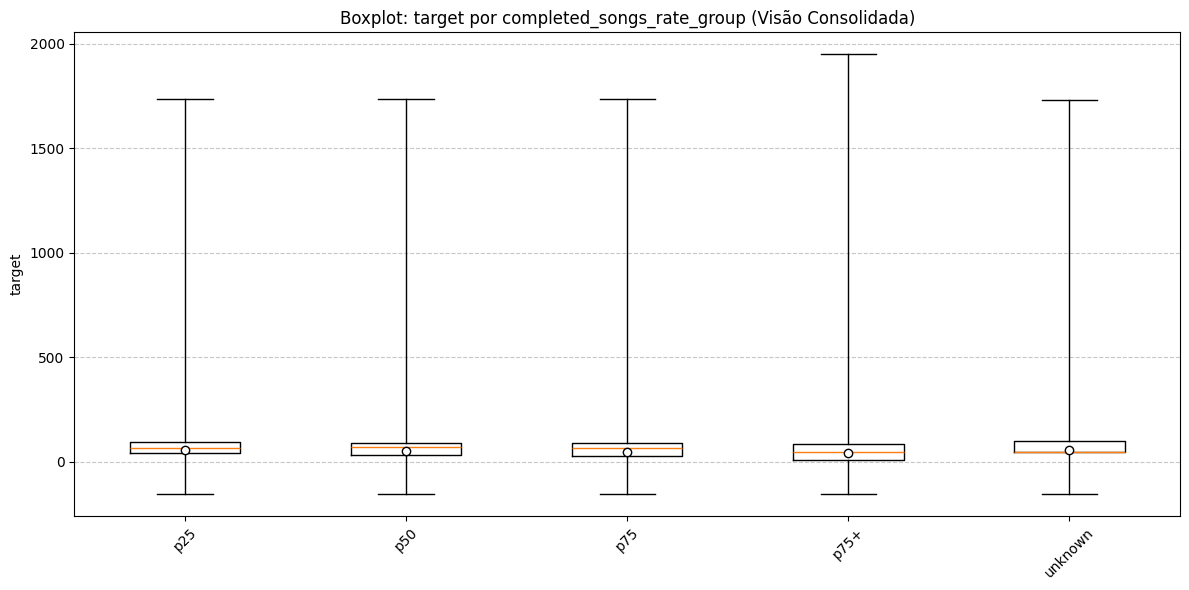


--- Estatísticas: completed_songs_rate_group (Visão Consolidada) ---


completed_songs_rate_group       min         q1        med       mean  \
0                        p25 -152.5452  41.910833  68.849401  55.356015   
4                        p50 -152.5452  33.850169  69.618255  51.131367   
2                        p75 -152.5452  27.796545  66.216070  47.810112   
3                       p75+ -152.5452  10.055245  49.000000  40.749212   
1                    unknown -152.5452  49.000000  49.000000  59.177692   

          q3          max  
0  93.868893  1737.947047  
4  90.748839  1737.859653  
2  89.305776  1737.929378  
3  87.412344  1950.000000  
1  99.000000  1733.833386

In [ ]:
plot_boxplot(df_base_logs, ["completed_songs_rate_group"], "target", table=True)

Processando estatísticas para: completed_songs_rate_group...


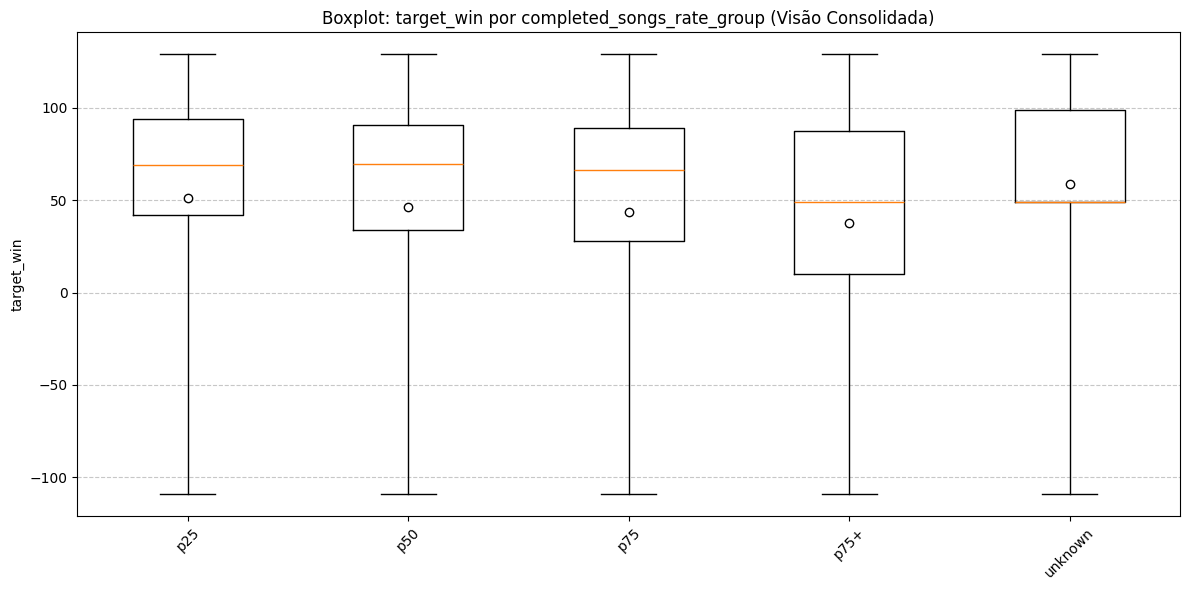


--- Estatísticas: completed_songs_rate_group (Visão Consolidada) ---


completed_songs_rate_group         min         q1        med       mean  \
0                        p25 -108.964925  41.910833  68.849401  51.348515   
4                        p50 -108.964925  33.850169  69.618255  46.536379   
2                        p75 -108.964925  27.796545  66.216070  43.424178   
3                       p75+ -108.964925  10.055245  49.000000  37.496112   
1                    unknown -108.964925  49.000000  49.000000  58.826712   

          q3         max  
0  93.868893  128.953521  
4  90.748839  128.953521  
2  89.305776  128.953521  
3  87.412344  128.953521  
1  99.000000  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["completed_songs_rate_group"], "target_win", table=True)

#### Conclusao

`completed_songs_rate` transformada em grupos por quartis, complementa o volume de uso (`total_plays`) ao capturar profundidade de consumo. Dois usuarios podem ter o mesmo numero de musicas escutadas (repetidas ou nao) mas taxas de completude diferentes. Observa-se uma relação negativa com a target, indicando que ususarios com maior taxa de conclusao de musicas tendem a gerar maior custo marginal, reduzindo a margem futura. O comportamento permanece o mesmo depois de winsorizar, sugerindo sinal estrutural e nao efeito de outliers. Sera levada para feature engineering (mesmo que possa ser zerada no elastic net)

In [ ]:
# Agrupamento por quartis
df_base_logs = df_base_logs.withColumn("completed_songs_rate_group",
    F.when(F.col("flag_has_logs").isin(0), "00_unknown")
    .when((F.col("completed_songs_rate") > 0.00) & (F.col("completed_songs_rate") <= 0.477) , "01_bouncer")
    .when((F.col("completed_songs_rate") > 0.477) & (F.col("completed_songs_rate") <= 0.694), "02_skipping_listener")
    .when((F.col("completed_songs_rate") > 0.694) & (F.col("completed_songs_rate") <= 0.835), "03_engaged_listener")
    .otherwise("04_completionist"))

### 8.1.5. avg_secs_per_play

In [ ]:
df_base_logs = df_base_logs.withColumn("avg_secs_per_play", F.when(F.col("total_plays") > 0, F.col("total_secs") / F.col("total_plays")).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("avg_secs_per_play").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary| avg_secs_per_play|
+-------+------------------+
|  count|          11242865|
|   mean|167.91906343205807|
| stddev| 74.89269521624702|
|    min|               0.0|
|     1%|               0.0|
|     5%|               0.0|
|    25%| 145.6058401486989|
|    50%| 189.2933519736842|
|    75%| 217.4252882527147|
|    95%|245.43684210526317|
|  99.5%|280.24546994535524|
|    max| 4925.603363128492|
+-------+------------------+



In [ ]:
df_base_logs.select("avg_secs_per_play", "target").corr("avg_secs_per_play", "target")

-0.035236909585071315

In [ ]:
df_base_logs.select("avg_secs_per_play", "target_win").corr("avg_secs_per_play", "target_win")

-0.061425079113587744

`avg_secs_per_play` apresenta correlacao muito fraca com a target, mesmo após winsorizar. Alem disso, seu significado econômico é curioso, pois a estrutura de custos se mostrou mais sensivel para a quantidade de reproducoes do que para a duracao media das musicas (mas e total_secs sendo parte da formula de custo, que compoe a margem liquida?). Para a solucao linear, a variavel continua nao acrescenta muito valor.

#### Conclusao

* Para solucoes lineares, a variavel seria um empecilho, caso inserida, pois poderia instabilizar coeficientes (pensando ena regularizao de elastic net, isso se nao zera-lo);
* Para algoritmos de boosting, a variavel nao cria bons thresholds, o que permite concluir que o ganho marginal seria proximo de zero;
* Para algoritmos de bagging (random forest, por exemplo), `avg_secs_per_play` nao cria bons cortes e possivelmente aumentaria a variancia.

Para este caso, mesmo considerando a construcao de algum agrupamento, a relacao com a target possivelmente continuaria fraca, dado que nao separa regimes de negocio. Descartar sua construcao.

### 8.1.5. avg_secs_per_unq

Profundidade media por musica. Separa usuarios que repetem musicas com baixa frequencia, ajudando a definir usuario que mais explora a plataforma. Nao capturada por `total_secs` e `num_unq` isoladamente

In [ ]:
df_base_logs = df_base_logs.withColumn("avg_secs_per_unq", F.when(F.col("num_unq") > 0, F.col("total_secs") / F.col("num_unq")).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("avg_secs_per_unq").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|  avg_secs_per_unq|
+-------+------------------+
|  count|          11242865|
|   mean| 253.0199987430327|
| stddev| 417.6774147961091|
|    min|               0.0|
|     1%|               0.0|
|     5%|               0.0|
|    25%| 173.9653440538519|
|    50%|230.14118142235125|
|    75%|  276.917049382716|
|    95%| 468.9416877133106|
|  99.5%|        1830.37644|
|    max|157112.34133333334|
+-------+------------------+



Distribuicao assimetrica a direita

In [ ]:
df_base_logs.select("avg_secs_per_unq", "target").corr("avg_secs_per_unq", "target")

-0.017425877847683863

In [ ]:
df_base_logs.select("avg_secs_per_unq", "target_win").corr("avg_secs_per_unq", "target_win")

-0.024362072685376972

Nao existe relacao linear valida, o que torna uma variavel ruim para elastic net. Porem, da pra tratar para demais casos.

In [ ]:
# Winsorizar pra cima, no p995
df_base_logs = df_base_logs.withColumn("avg_secs_per_unq_cap",
    F.when(F.col("avg_secs_per_unq") > 1830, 1830).otherwise(F.col("avg_secs_per_unq")))

# Aplicar transformação logarítmica - considerar levar esta como o valor continuo no modelo linear
df_base_logs = df_base_logs.withColumn("log_avg_secs_per_unq", F.log1p(F.col("avg_secs_per_unq")))

#### Agrupamento por quartis

In [ ]:
df_base_logs.select("avg_secs_per_unq_cap").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+--------------------+
|summary|avg_secs_per_unq_cap|
+-------+--------------------+
|  count|            11242865|
|   mean|  240.71645049590418|
| stddev|   195.6380292116396|
|    min|                 0.0|
|    25%|   173.9653440538519|
|    50%|  230.14118142235125|
|    75%|    276.917049382716|
|    max|              1830.0|
+-------+--------------------+



In [ ]:
df_base_logs = df_base_logs.withColumn("avg_secs_per_unq_cap_group",
    F.when(F.col("flag_has_logs").isin(0), "unknown")\
    .when((F.col("avg_secs_per_unq_cap") > 0) & (F.col("avg_secs_per_unq_cap") <= 173.965), "p25")\
    .when((F.col("avg_secs_per_unq_cap") > 173.965) & (F.col("avg_secs_per_unq_cap") <= 230.141), "p50")\
    .when((F.col("avg_secs_per_unq_cap") > 230.141) & (F.col("avg_secs_per_unq_cap") <= 276.917), "p75")\
    .otherwise("p75+"))

In [ ]:
calcular_distribuicao(df_base_logs, ["avg_secs_per_unq_cap_group"])

+--------------------------+-------+---------+
|avg_secs_per_unq_cap_group|total  |pct_total|
+--------------------------+-------+---------+
|p75+                      |2811090|25.0     |
|p75                       |2810804|25.0     |
|p50                       |2810614|25.0     |
|p25                       |1543372|13.73    |
|unknown                   |1266985|11.27    |
+--------------------------+-------+---------+



DataFrame[avg_secs_per_unq_cap_group: string, total: bigint, pct_total: double]

Processando estatísticas para: avg_secs_per_unq_cap_group...


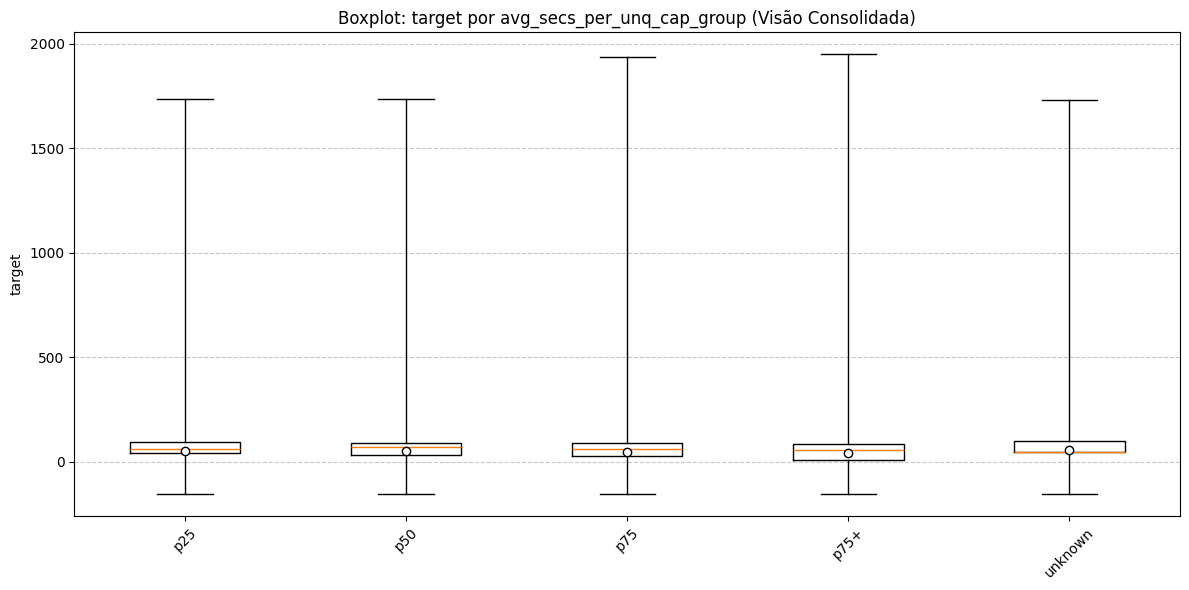


--- Estatísticas: avg_secs_per_unq_cap_group (Visão Consolidada) ---


avg_secs_per_unq_cap_group       min         q1        med       mean  \
0                        p25 -152.5452  41.861596  63.927131  54.274849   
4                        p50 -152.5452  34.417364  69.270302  51.039135   
2                        p75 -152.5452  26.852644  64.044408  46.968586   
3                       p75+ -152.5452  10.548187  56.028176  41.566656   
1                    unknown -152.5452  49.000000  49.000000  59.177692   

          q3          max  
0  93.500876  1737.859653  
4  91.240601  1737.484560  
2  89.190420  1936.799455  
3  87.156328  1950.000000  
1  99.000000  1733.833386

In [ ]:
plot_boxplot(df_base_logs, ["avg_secs_per_unq_cap_group"], "target", table=True)

Processando estatísticas para: avg_secs_per_unq_cap_group...


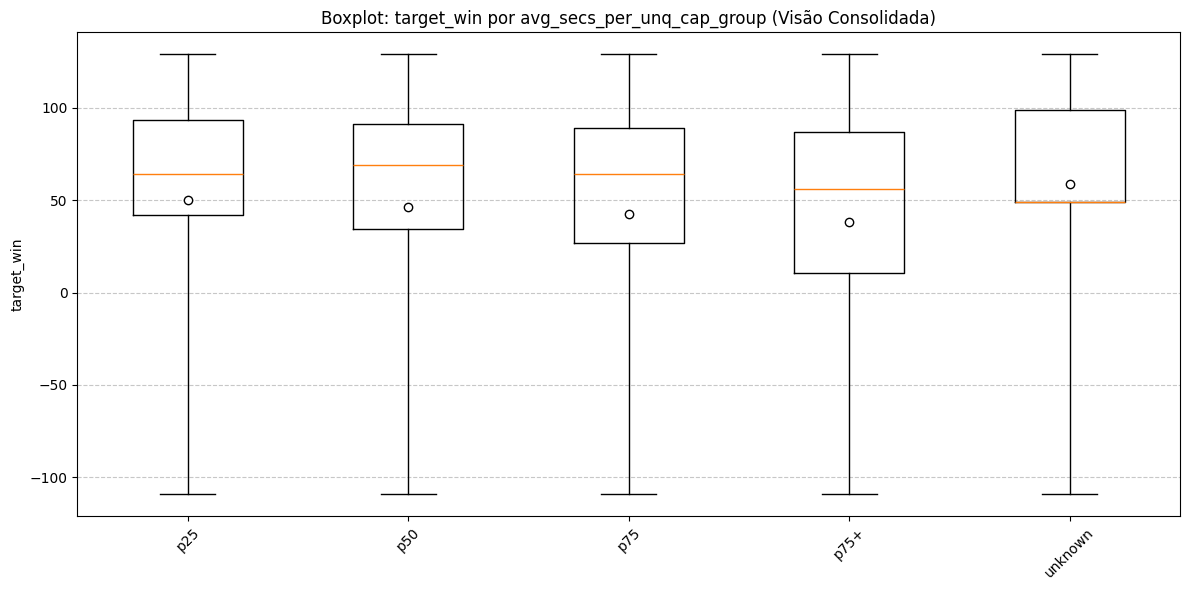


--- Estatísticas: avg_secs_per_unq_cap_group (Visão Consolidada) ---


avg_secs_per_unq_cap_group         min         q1        med       mean  \
0                        p25 -108.964925  41.861596  63.927131  50.304066   
4                        p50 -108.964925  34.417364  69.270302  46.489987   
2                        p75 -108.964925  26.852644  64.044408  42.727295   
3                       p75+ -108.964925  10.548187  56.028176  38.141249   
1                    unknown -108.964925  49.000000  49.000000  58.826712   

          q3         max  
0  93.500876  128.953521  
4  91.240601  128.953521  
2  89.190420  128.953521  
3  87.156328  128.953521  
1  99.000000  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["avg_secs_per_unq_cap_group"], "target_win", table=True)

#### Conclusao

`avg_secs_per_unq`, depois do cap e do agrupamento, apresentou relacao negativa clara com a target, refletindo maior custo medio de consumo por item. Apesar da baixa correlacao linear global, seu efeito emerge de forma consistente em regimes comportamentais, sendo informativa para modelos lineares regularizados e essencial para modelos nao lineares. Levar para feature engineering.

### 8.1.6. plays_per_unq

Plays por musica (intensidade). RF e LightGBM capturam bons thresholds e apos transformar da pra usar no elastic net

In [ ]:
df_base_logs = df_base_logs.withColumn("plays_per_unq", F.when(F.col("num_unq") > 0, F.col("num_100") / F.col("num_unq")).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("plays_per_unq").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|     plays_per_unq|
+-------+------------------+
|  count|          11242865|
|   mean|0.9334199641487592|
| stddev|1.7138072687322223|
|    min|               0.0|
|     1%|               0.0|
|     5%|               0.0|
|    25%|0.5719512195121951|
|    50%|0.8518518518518519|
|    75%|1.0454545454545454|
|    95%|1.7857142857142858|
|  99.5%| 7.145772594752186|
|    max|            871.75|
+-------+------------------+



Distribuicao bem assimetrica a direita

In [ ]:
df_base_logs.select("plays_per_unq", "target").corr("plays_per_unq", "target")

-0.01866538221161783

In [ ]:
df_base_logs.select("plays_per_unq", "target_win").corr("plays_per_unq", "target_win")

-0.025806740358633715

Nao existe relacao linear valida, o que torna uma variavel ruim para elastic net. Porem, da pra tratar para demais casos.

In [ ]:
# Winsorizar pra cima, no p995
df_base_logs = df_base_logs.withColumn("plays_per_unq_cap",
    F.when(F.col("plays_per_unq") > 7.14, 7.14).otherwise(F.col("plays_per_unq")))

#### Agrupamento por quartis

In [ ]:
df_base_logs.select("plays_per_unq_cap").summary("count", "mean", "stddev", "min", "25%", "50%", "75%", "max").show()

+-------+------------------+
|summary| plays_per_unq_cap|
+-------+------------------+
|  count|          11242865|
|   mean|0.8834730591295731|
| stddev|0.7726093126137725|
|    min|               0.0|
|    25%|0.5719512195121951|
|    50%|0.8518518518518519|
|    75%|1.0454545454545454|
|    max|              7.14|
+-------+------------------+



In [ ]:
df_base_logs = df_base_logs.withColumn("plays_per_unq_cap_group",
    F.when(F.col("flag_has_logs").isin(0), "unknown")\
    .when((F.col("plays_per_unq_cap") >= 0) & (F.col("plays_per_unq_cap") <= 0.5719), "p25")\
    .when((F.col("plays_per_unq_cap") > 0.5719) & (F.col("plays_per_unq_cap") <= 0.8518), "p50")\
    .when((F.col("plays_per_unq_cap") > 0.8518) & (F.col("plays_per_unq_cap") <= 1.045), "p75")\
    .otherwise("p75+"))

In [ ]:
calcular_distribuicao(df_base_logs, ["plays_per_unq_cap_group"])

+-----------------------+-------+---------+
|plays_per_unq_cap_group|total  |pct_total|
+-----------------------+-------+---------+
|p75+                   |2815339|25.04    |
|p50                    |2809320|24.99    |
|p75                    |2808014|24.98    |
|p25                    |1543207|13.73    |
|unknown                |1266985|11.27    |
+-----------------------+-------+---------+



DataFrame[plays_per_unq_cap_group: string, total: bigint, pct_total: double]

Processando estatísticas para: plays_per_unq_cap_group...


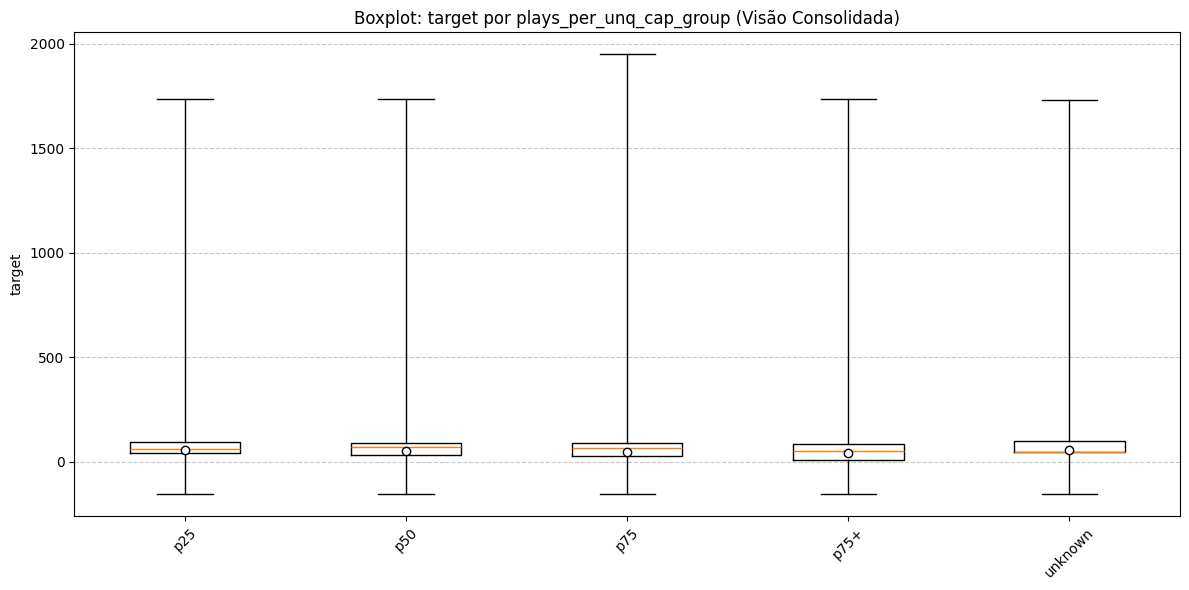


--- Estatísticas: plays_per_unq_cap_group (Visão Consolidada) ---


plays_per_unq_cap_group       min         q1        med       mean  \
0                     p25 -152.5452  42.797811  62.055705  54.864552   
4                     p50 -152.5452  34.198184  69.836618  51.114125   
2                     p75 -152.5452  28.504832  64.806716  47.640133   
3                    p75+ -152.5452   7.980188  54.715091  40.524290   
1                 unknown -152.5452  49.000000  49.000000  59.177692   

          q3          max  
0  93.983821  1737.859653  
4  91.116295  1737.947047  
2  89.518001  1950.000000  
3  86.528988  1737.041373  
1  99.000000  1733.833386

In [ ]:
plot_boxplot(df_base_logs, ["plays_per_unq_cap_group"], "target", table=True)

Processando estatísticas para: plays_per_unq_cap_group...


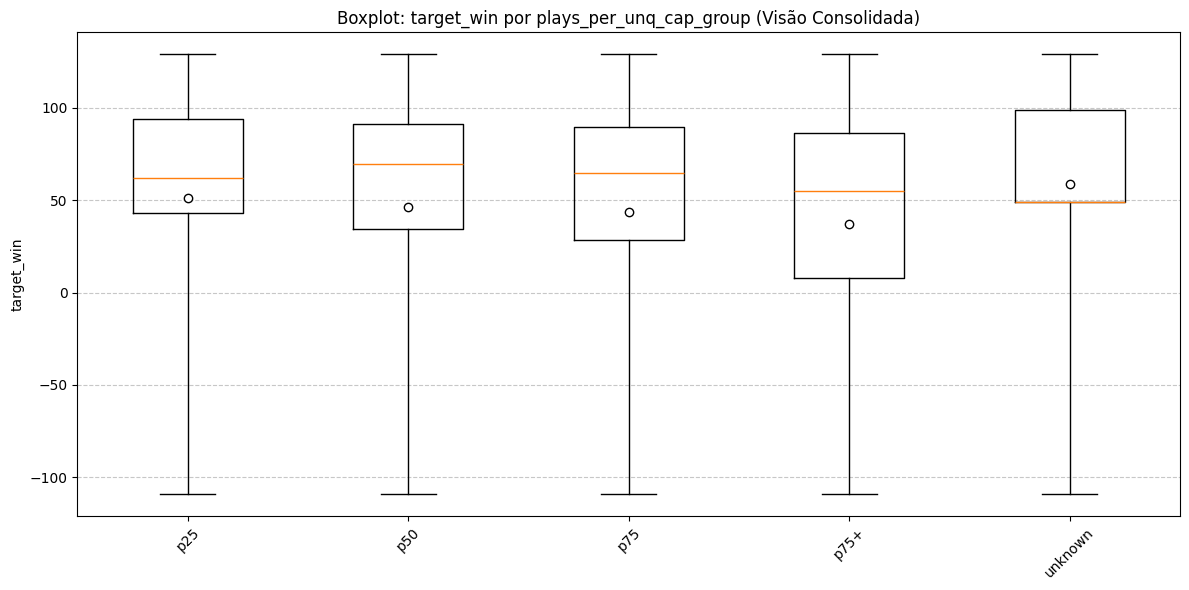


--- Estatísticas: plays_per_unq_cap_group (Visão Consolidada) ---


plays_per_unq_cap_group         min         q1        med       mean  \
0                     p25 -108.964925  42.797811  62.055705  51.023214   
4                     p50 -108.964925  34.198184  69.836618  46.493361   
2                     p75 -108.964925  28.504832  64.806716  43.437247   
3                    p75+ -108.964925   7.980188  54.715091  37.063461   
1                 unknown -108.964925  49.000000  49.000000  58.826712   

          q3         max  
0  93.983821  128.953521  
4  91.116295  128.953521  
2  89.518001  128.953521  
3  86.528988  128.953521  
1  99.000000  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["plays_per_unq_cap_group"], "target_win", table=True)

O agrupamento por quartil nao me parece fazer sentido nesse caso. Quero que a variavel me diga se o usuario tende a repetir ou explorar musicas, e nao a faixa de distribuicao que ele cai pra cada um dos subcasos. Vamos tentar outra abordagem.

#### Agrupando semanticamente - ideal

In [ ]:
df_base_logs = df_base_logs.withColumn("plays_per_unq_behavior",
    F.when(F.col("flag_has_logs").isin(0), "00_unknown")
    .when((F.col("plays_per_unq_cap") >= 0) & (F.col("plays_per_unq_cap") < 1.1), "01_explorer")
    .when((F.col("plays_per_unq_cap") >= 1.1) & (F.col("plays_per_unq_cap") < 1.5), "02_light_repeat")
    .when((F.col("plays_per_unq_cap") >= 1.5) & (F.col("plays_per_unq_cap") < 3.0), "03_repeat")
    .otherwise("04_heavy_repeat"))

In [ ]:
calcular_distribuicao(df_base_logs, ["plays_per_unq_behavior"])

+----------------------+-------+---------+
|plays_per_unq_behavior|total  |pct_total|
+----------------------+-------+---------+
|01_explorer           |7634463|67.9     |
|02_light_repeat       |1470819|13.08    |
|00_unknown            |1266985|11.27    |
|03_repeat             |665352 |5.92     |
|04_heavy_repeat       |205246 |1.83     |
+----------------------+-------+---------+



DataFrame[plays_per_unq_behavior: string, total: bigint, pct_total: double]

Processando estatísticas para: plays_per_unq_behavior...


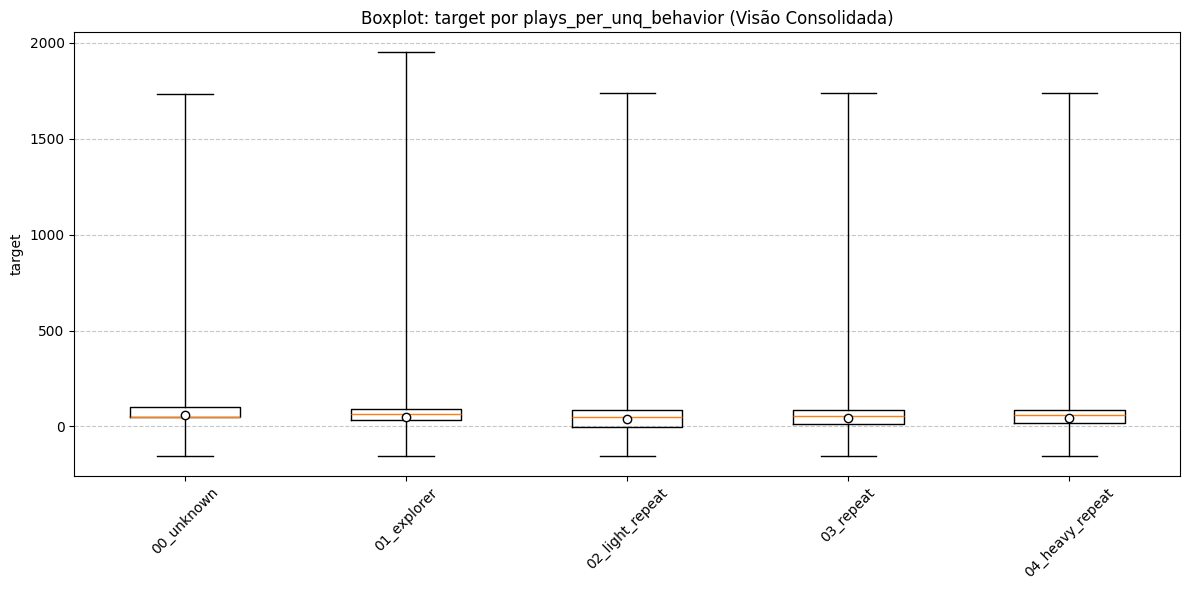


--- Estatísticas: plays_per_unq_behavior (Visão Consolidada) ---


plays_per_unq_behavior       min         q1        med       mean  \
4             00_unknown -152.5452  49.000000  49.000000  59.177692   
1            01_explorer -152.5452  33.464282  66.396955  50.099908   
2        02_light_repeat -152.5452  -1.299418  51.556471  38.343983   
3              03_repeat -152.5452  14.007144  55.626256  42.166822   
0        04_heavy_repeat -152.5452  17.997014  57.453219  43.509551   

          q3          max  
4  99.000000  1733.833386  
1  90.921769  1950.000000  
2  85.778611  1736.835211  
3  87.161385  1736.374073  
0  88.354067  1737.041373

In [ ]:
plot_boxplot(df_base_logs, ["plays_per_unq_behavior"], "target", table=True)

Processando estatísticas para: plays_per_unq_behavior...


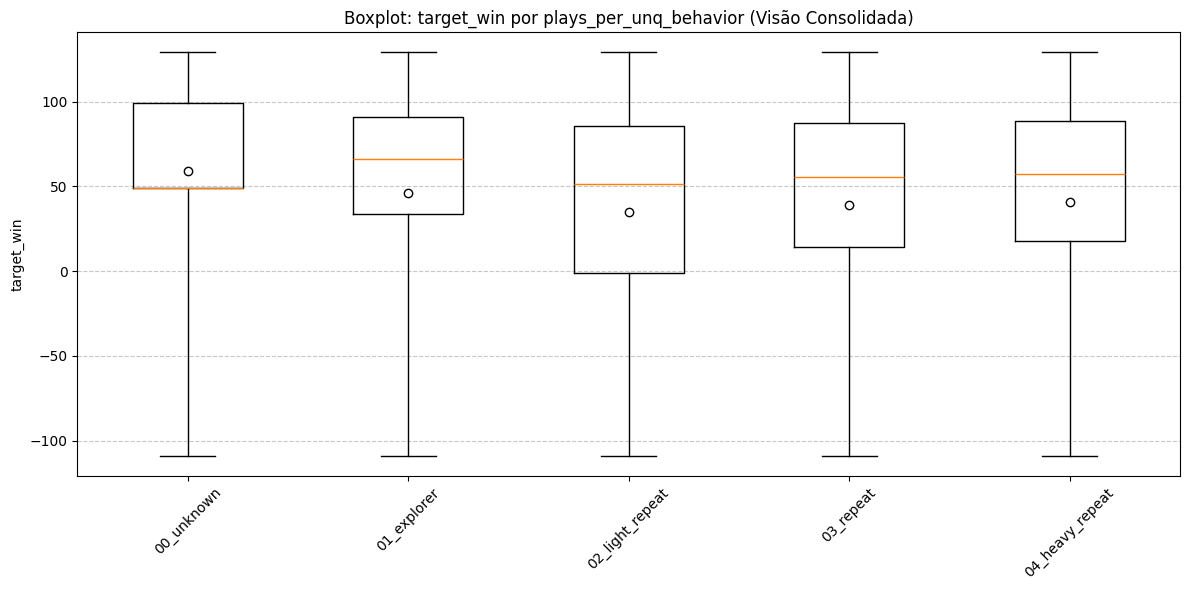


--- Estatísticas: plays_per_unq_behavior (Visão Consolidada) ---


plays_per_unq_behavior         min         q1        med       mean  \
4             00_unknown -108.964925  49.000000  49.000000  58.826712   
1            01_explorer -108.964925  33.464282  66.396955  45.817970   
2        02_light_repeat -108.964925  -1.299418  51.556471  34.983622   
3              03_repeat -108.964925  14.007144  55.626256  38.707490   
0        04_heavy_repeat -108.964925  17.997014  57.453219  40.866520   

          q3         max  
4  99.000000  128.953521  
1  90.921769  128.953521  
2  85.778611  128.953521  
3  87.161385  128.953521  
0  88.354067  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["plays_per_unq_behavior"], "target_win", table=True)

#### Conclusao

O agrupamento por regime comportamental de repeticao se mostra mais adequado do que quartis porque `plays_per_unq` nao representa intensidade continua, mas sim padroes discretos de consumo. Quartis fragmentam artificialmente a populacao e misturam comportamentos distintos dentro da mesma classe, reduzindo interpretabilidade e poder explicativo. `plays_per_unq_behavior` captura regimes de comportamento que nao sao explicados por volume ou tempo total de consumo, oferecendo ganho de informacao complementar e itnerpretavel para todos os modelos considerados no projeto. Levar para feature engineering.

### 8.1.7. plays_behavior_vs_volume

Cruzamento entre `plays_per_unq_behaviour` e `total_plays_group`. O objetivo: separar usuarios com mesmo volume total, mas comportamentos de repeticao diferentes.

Ex.: baixo volume + explorer, alto volume + heavy_repeat

In [ ]:
df_base_logs = df_base_logs.withColumn("plays_behavior_vs_volume",
    F.concat_ws("_", F.col("plays_per_unq_behavior"), F.col("total_plays_group")))

In [ ]:
calcular_distribuicao(df_base_logs, ["plays_behavior_vs_volume"], n_show=25)

+------------------------------------+-------+---------+
|plays_behavior_vs_volume            |total  |pct_total|
+------------------------------------+-------+---------+
|01_explorer_01_casual_listener      |2179718|19.39    |
|01_explorer_02_regular_listener     |2015185|17.92    |
|01_explorer_03_frequent_listener    |1906038|16.95    |
|01_explorer_04_power_user           |1533522|13.64    |
|00_unknown_00_unknown               |1266985|11.27    |
|02_light_repeat_04_power_user       |603188 |5.37     |
|02_light_repeat_03_frequent_listener|387566 |3.45     |
|02_light_repeat_02_regular_listener |304258 |2.71     |
|03_repeat_04_power_user             |271306 |2.41     |
|02_light_repeat_01_casual_listener  |175807 |1.56     |
|03_repeat_03_frequent_listener      |158865 |1.41     |
|03_repeat_02_regular_listener       |131869 |1.17     |
|03_repeat_01_casual_listener        |103312 |0.92     |
|04_heavy_repeat_04_power_user       |85671  |0.76     |
|04_heavy_repeat_01_casual_list

DataFrame[plays_behavior_vs_volume: string, total: bigint, pct_total: double]

Processando estatísticas para: plays_behavior_vs_volume...


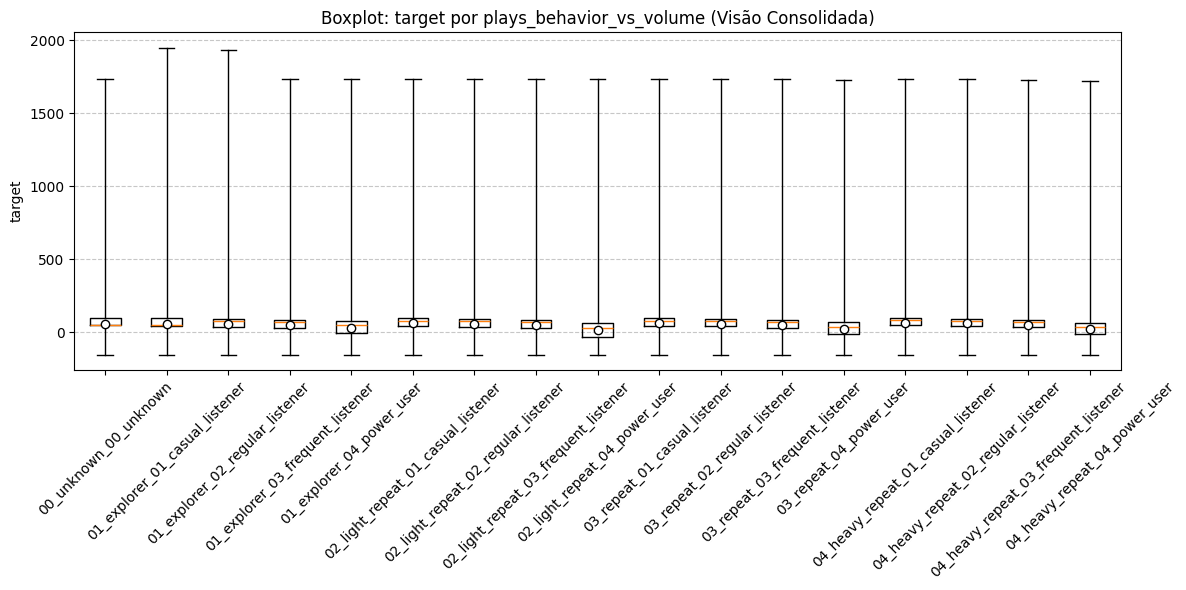


--- Estatísticas: plays_behavior_vs_volume (Visão Consolidada) ---


plays_behavior_vs_volume       min         q1        med  \
6                  00_unknown_00_unknown -152.5452  49.000000  49.000000   
11        01_explorer_01_casual_listener -152.5452  46.214381  49.000000   
0        01_explorer_02_regular_listener -152.5452  39.169019  78.465469   
2       01_explorer_03_frequent_listener -152.5452  27.889035  73.665545   
3              01_explorer_04_power_user -152.5452  -4.038993  53.591662   
7     02_light_repeat_01_casual_listener -152.5452  45.752592  78.495220   
12   02_light_repeat_02_regular_listener -152.5452  39.286901  79.945016   
5   02_light_repeat_03_frequent_listener -152.5452  28.254581  72.061216   
10         02_light_repeat_04_power_user -152.5452 -31.820184  30.053257   
16          03_repeat_01_casual_listener -152.5452  46.390330  78.928849   
14         03_repeat_02_regular_listener -152.5452  40.442198  80.878012   
13        03_repeat_03_frequent_listener -152.5452  30.754320  73.040431   
9                03_repeat_04_power_user -152.5452  -9.279213  37.507139   
15    04_heavy_repeat_01_casual_listener -152.5452  47.444377  87.161739   
4    04_heavy_repeat_02_regular_listener -152.5452  43.205639  80.242414   
1   04_heavy_repeat_03_frequent_listener -152.5452  34.620558  71.019404   
8          04_heavy_repeat_04_power_user -152.5452  -8.875781  37.820981   

         mean         q3          max  
6   59.177692  99.000000  1733.833386  
11  58.630713  96.755751  1950.000000  
0   55.869866  93.099059  1936.799455  
2   48.971521  87.266072  1736.541069  
3   32.711685  75.355310  1735.146209  
7   60.927141  96.858051  1736.835211  
12  56.538343  93.022058  1735.032432  
5   48.501377  86.614173  1734.140378  
10  16.579230  67.057576  1732.840396  
16  61.471305  97.268736  1734.154509  
14  57.599496  93.593744  1736.374073  
13  50.698812  87.455888  1734.872871  
9   23.025309  69.352397  1731.871480  
15  63.977910  97.629844  1737.041373  
4   60.700417  93.894581  1736.048807  
1   52.716810  88.030601  1726.230960  
8   22.194435  66.747661  1723.032881

In [ ]:
plot_boxplot(df_base_logs, ["plays_behavior_vs_volume"], "target", table=True)

Processando estatísticas para: plays_behavior_vs_volume...


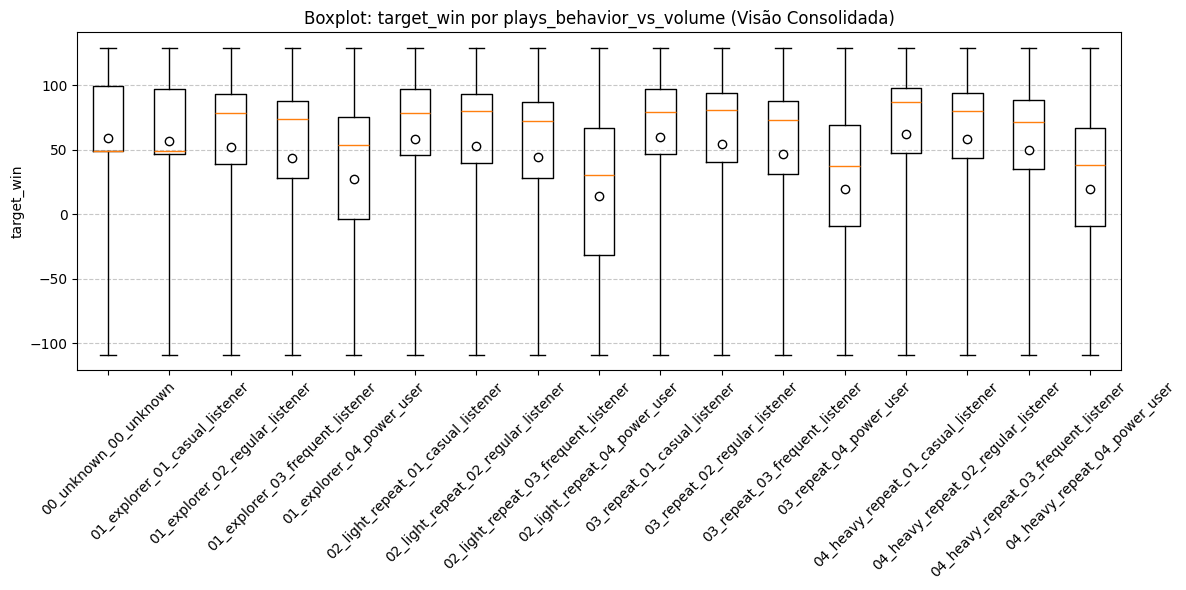


--- Estatísticas: plays_behavior_vs_volume (Visão Consolidada) ---


plays_behavior_vs_volume         min         q1        med  \
6                  00_unknown_00_unknown -108.964925  49.000000  49.000000   
11        01_explorer_01_casual_listener -108.964925  46.214381  49.000000   
0        01_explorer_02_regular_listener -108.964925  39.169019  78.465469   
2       01_explorer_03_frequent_listener -108.964925  27.889035  73.665545   
3              01_explorer_04_power_user -108.964925  -4.038993  53.591662   
7     02_light_repeat_01_casual_listener -108.964925  45.752592  78.495220   
12   02_light_repeat_02_regular_listener -108.964925  39.286901  79.945016   
5   02_light_repeat_03_frequent_listener -108.964925  28.254581  72.061216   
10         02_light_repeat_04_power_user -108.964925 -31.820184  30.053257   
16          03_repeat_01_casual_listener -108.964925  46.390330  78.928849   
14         03_repeat_02_regular_listener -108.964925  40.442198  80.878012   
13        03_repeat_03_frequent_listener -108.964925  30.754320  73.040431   
9                03_repeat_04_power_user -108.964925  -9.279213  37.507139   
15    04_heavy_repeat_01_casual_listener -108.964925  47.444377  87.161739   
4    04_heavy_repeat_02_regular_listener -108.964925  43.205639  80.242414   
1   04_heavy_repeat_03_frequent_listener -108.964925  34.620558  71.019404   
8          04_heavy_repeat_04_power_user -108.964925  -8.875781  37.820981   

         mean         q3         max  
6   58.826712  99.000000  128.953521  
11  56.269536  96.755751  128.953521  
0   51.668398  93.099059  128.953521  
2   43.739824  87.266072  128.953521  
3   26.960411  75.355310  128.953521  
7   58.476126  96.858051  128.953521  
12  53.030498  93.022058  128.953521  
5   44.200633  86.614173  128.953521  
10  13.641503  67.057576  128.953521  
16  59.570182  97.268736  128.953521  
14  54.338200  93.593744  128.953521  
13  46.400770  87.455888  128.953521  
9   19.406706  69.352397  128.953521  
15  62.276180  97.629844  128.953521  
4   58.312439  93.894581  128.953521  
1   49.644019  88.030601  128.953521  
8   19.177723  66.747661  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["plays_behavior_vs_volume"], "target_win", table=True)

À primeira vista, a variável `plays_behavior_vs_volume` pode parecer over engineering, por ser uma junção direta de duas variáveis já existentes (`plays_per_unq_behavior` e volume / perfil de consumo). No entanto, as variáveis originais, isoladamente, não capturam o mesmo fenômeno que o cruzamento revela. Embora os valores medios entre algumas classes sejam próximos, a variável cruzada explicita uma interação não linear que nao é aditiva nao é monotonica e nao seria bem representada por coeficientes lineares separados. Para modelos bagging e boosting, se mostra bem construida, mas exige adaptacoes para modelos lineares.

Manter a variavel como esta, permite acelerar o aprendizado ao explicitar a interação logo no primeiro nível da árvore, ou seja, reduz a profundidade necessária para capturar o padrão, o que significa menos splits = menor latência de inferência. O que podemos aplicar, diante da distribuicao da variavel, seria colapsar categorias raras (menos de 1% da base), para melhor performance da RF.

In [ ]:
# Colapsar categorias raras (< 1% da base) para RF/QRF
# LightGBM lida bem com raras, mas RF pode sofrer em bootstrap

total_logs = df_base_logs.count()

threshold = 0.01  # 1%
freq_table = df_base_logs.groupBy("plays_behavior_vs_volume").count()
freq_table = freq_table.withColumn("pct", F.col("count") / total_logs)

rare_categories = (freq_table
    .filter(F.col("pct") < threshold)
    .select("plays_behavior_vs_volume")
    .rdd.flatMap(lambda x: x).collect())

df_base_logs = df_base_logs.withColumn("plays_behavior_vs_volume_collapsed",
    F.when(F.col("plays_behavior_vs_volume").isin(rare_categories), "99_other")
    .otherwise(F.col("plays_behavior_vs_volume")))

In [ ]:
calcular_distribuicao(df_base_logs, ["plays_behavior_vs_volume_collapsed"], n_show=25)

+------------------------------------+-------+---------+
|plays_behavior_vs_volume_collapsed  |total  |pct_total|
+------------------------------------+-------+---------+
|01_explorer_01_casual_listener      |2179718|19.39    |
|01_explorer_02_regular_listener     |2015185|17.92    |
|01_explorer_03_frequent_listener    |1906038|16.95    |
|01_explorer_04_power_user           |1533522|13.64    |
|00_unknown_00_unknown               |1266985|11.27    |
|02_light_repeat_04_power_user       |603188 |5.37     |
|02_light_repeat_03_frequent_listener|387566 |3.45     |
|99_other                            |308558 |2.74     |
|02_light_repeat_02_regular_listener |304258 |2.71     |
|03_repeat_04_power_user             |271306 |2.41     |
|02_light_repeat_01_casual_listener  |175807 |1.56     |
|03_repeat_03_frequent_listener      |158865 |1.41     |
|03_repeat_02_regular_listener       |131869 |1.17     |
+------------------------------------+-------+---------+



DataFrame[plays_behavior_vs_volume_collapsed: string, total: bigint, pct_total: double]

Processando estatísticas para: plays_behavior_vs_volume_collapsed...


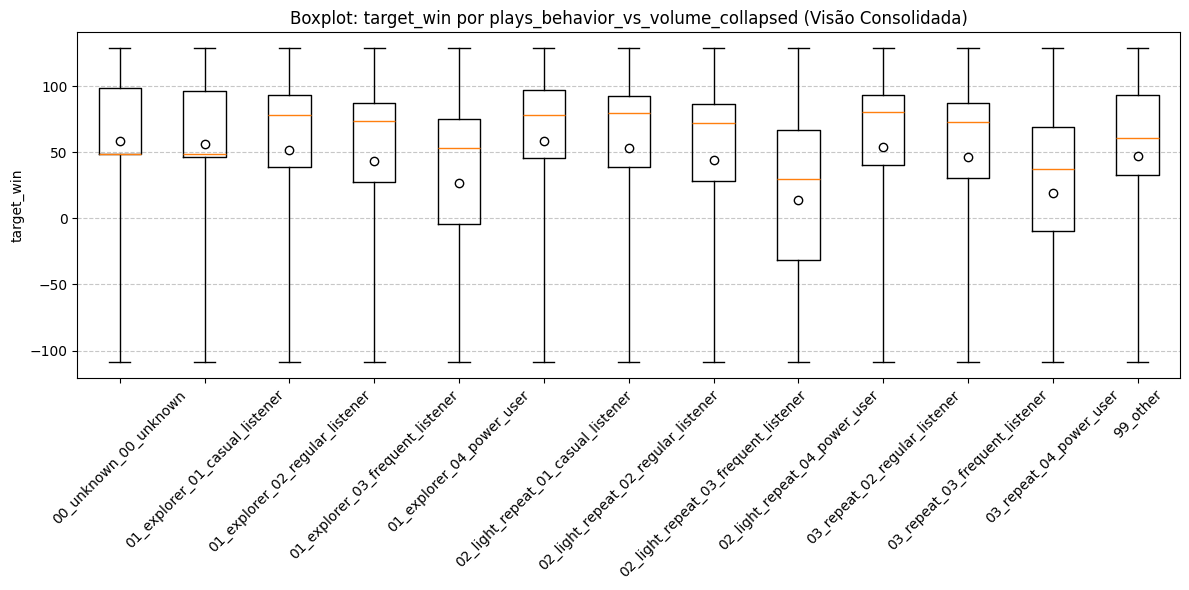


--- Estatísticas: plays_behavior_vs_volume_collapsed (Visão Consolidada) ---


plays_behavior_vs_volume_collapsed         min         q1        med  \
4                  00_unknown_00_unknown -108.964925  49.000000  49.000000   
9         01_explorer_01_casual_listener -108.964925  46.214381  49.000000   
0        01_explorer_02_regular_listener -108.964925  39.169019  78.465469   
1       01_explorer_03_frequent_listener -108.964925  27.889035  73.665545   
2              01_explorer_04_power_user -108.964925  -4.038993  53.591662   
6     02_light_repeat_01_casual_listener -108.964925  45.752592  78.495220   
10   02_light_repeat_02_regular_listener -108.964925  39.286901  79.945016   
3   02_light_repeat_03_frequent_listener -108.964925  28.254581  72.061216   
8          02_light_repeat_04_power_user -108.964925 -31.820184  30.053257   
12         03_repeat_02_regular_listener -108.964925  40.442198  80.878012   
11        03_repeat_03_frequent_listener -108.964925  30.754320  73.040431   
7                03_repeat_04_power_user -108.964925  -9.279213  37.507139   
5                               99_other -108.964925  32.961968  60.507344   

         mean         q3         max  
4   58.826712  99.000000  128.953521  
9   56.269536  96.755751  128.953521  
0   51.668398  93.099059  128.953521  
1   43.739824  87.266072  128.953521  
2   26.960411  75.355310  128.953521  
6   58.476126  96.858051  128.953521  
10  53.030498  93.022058  128.953521  
3   44.200633  86.614173  128.953521  
8   13.641503  67.057576  128.953521  
12  54.338200  93.593744  128.953521  
11  46.400770  87.455888  128.953521  
7   19.406706  69.352397  128.953521  
5   46.984186  93.661620  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["plays_behavior_vs_volume_collapsed"], "target_win", table=True)

Pra Elastic Net, vou optar pelo One Hot Encoding das duas variaveis raw, dado que algum outro tratamento seria trazer complexidade que pode se mostrar desnecessaria.

### 8.1.8. plays_behavior_vs_completion

Cruzamento entre `plays_per_unq_behaviour` e `completed_songs_rate_group`. O objetivo: diferenciar exploracao superficial de exploracao "qualificada".

In [ ]:
df_base_logs = df_base_logs.withColumn("plays_behavior_vs_completion", F.concat_ws("_", F.col("plays_per_unq_behavior"), F.col("completed_songs_rate_group")))

In [ ]:
calcular_distribuicao(df_base_logs, ["plays_behavior_vs_completion"], n_show=25)

+------------------------------------+-------+---------+
|plays_behavior_vs_completion        |total  |pct_total|
+------------------------------------+-------+---------+
|01_explorer_02_skipping_listener    |2582106|22.97    |
|01_explorer_03_engaged_listener     |2085466|18.55    |
|01_explorer_04_completionist        |1572874|13.99    |
|01_explorer_01_bouncer              |1394017|12.4     |
|00_unknown_00_unknown               |1266985|11.27    |
|02_light_repeat_04_completionist    |831674 |7.4      |
|02_light_repeat_03_engaged_listener |474983 |4.22     |
|03_repeat_04_completionist          |393622 |3.5      |
|03_repeat_03_engaged_listener       |209330 |1.86     |
|04_heavy_repeat_04_completionist    |166684 |1.48     |
|02_light_repeat_02_skipping_listener|160246 |1.43     |
|03_repeat_02_skipping_listener      |61204  |0.54     |
|04_heavy_repeat_03_engaged_listener |35810  |0.32     |
|02_light_repeat_01_bouncer          |3916   |0.03     |
|04_heavy_repeat_02_skipping_li

DataFrame[plays_behavior_vs_completion: string, total: bigint, pct_total: double]

Processando estatísticas para: plays_behavior_vs_completion...


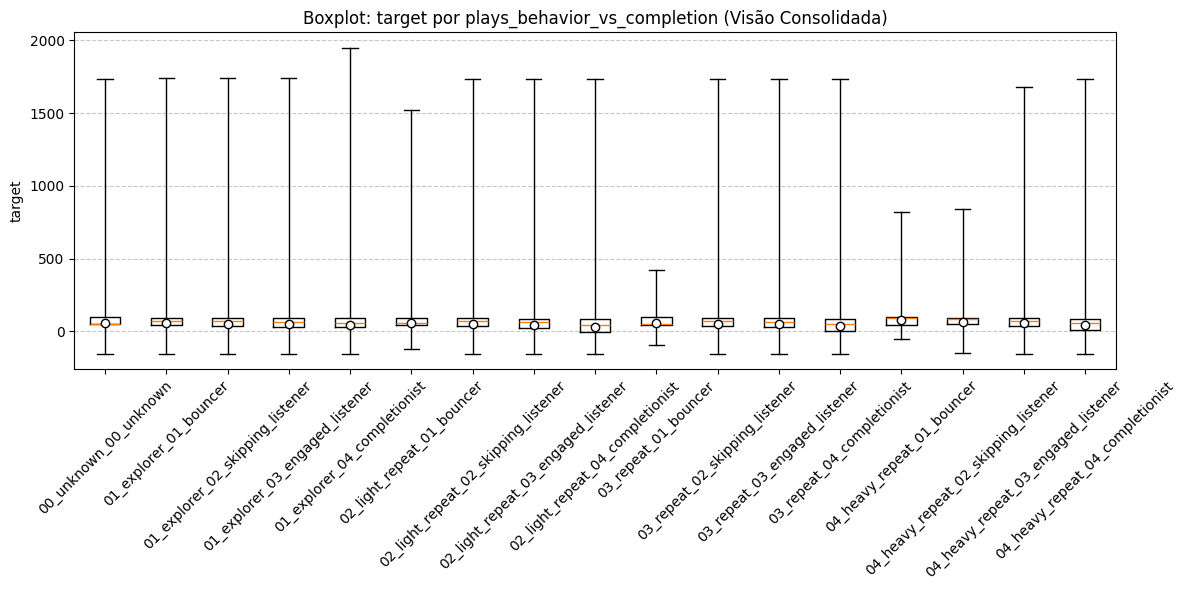


--- Estatísticas: plays_behavior_vs_completion (Visão Consolidada) ---


plays_behavior_vs_completion         min         q1        med  \
9                  00_unknown_00_unknown -152.545200  49.000000  49.000000   
14                01_explorer_01_bouncer -152.545200  41.904914  68.881134   
0       01_explorer_02_skipping_listener -152.545200  33.623792  69.655266   
1        01_explorer_03_engaged_listener -152.545200  28.703267  66.668945   
15          01_explorer_04_completionist -152.545200  29.448625  54.522620   
13            02_light_repeat_01_bouncer -121.131346  42.927304  53.893583   
7   02_light_repeat_02_skipping_listener -152.545200  34.942259  69.217471   
12   02_light_repeat_03_engaged_listener -152.545200  21.829411  64.133545   
10      02_light_repeat_04_completionist -152.545200  -3.545200  46.113688   
8                   03_repeat_01_bouncer  -95.561743  45.556342  49.000000   
6         03_repeat_02_skipping_listener -152.545200  38.638552  68.285445   
3          03_repeat_03_engaged_listener -152.545200  29.738476  66.357642   
11            03_repeat_04_completionist -152.545200   2.603474  48.940250   
4             04_heavy_repeat_01_bouncer  -55.654617  45.896249  88.984306   
16  04_heavy_repeat_02_skipping_listener -145.961100  48.162212  87.234535   
2    04_heavy_repeat_03_engaged_listener -152.545200  37.799963  69.285528   
5       04_heavy_repeat_04_completionist -152.545200  10.632800  54.615218   

         mean         q3          max  
9   59.177692  99.000000  1733.833386  
14  55.355141  93.863099  1737.947047  
0   51.003020  90.729018  1737.859653  
1   48.053611  89.598966  1737.929378  
15  46.744548  90.084392  1950.000000  
13  55.613547  95.061518  1518.763682  
7   51.981705  90.563214  1735.032432  
12  45.666006  87.607069  1733.827442  
10  31.571402  82.814711  1736.835211  
8   53.887820  95.794939   423.247290  
6   53.886423  92.020910  1736.374073  
3   49.209238  89.616214  1734.314575  
11  36.721866  84.374551  1735.612685  
4   79.307562  97.682831   817.826907  
16  66.521618  93.519566   843.339009  
2   54.072363  91.556933  1680.134612  
5   40.912316  87.082652  1737.041373

In [ ]:
plot_boxplot(df_base_logs, ["plays_behavior_vs_completion"], "target", table=True)

Processando estatísticas para: plays_behavior_vs_completion...


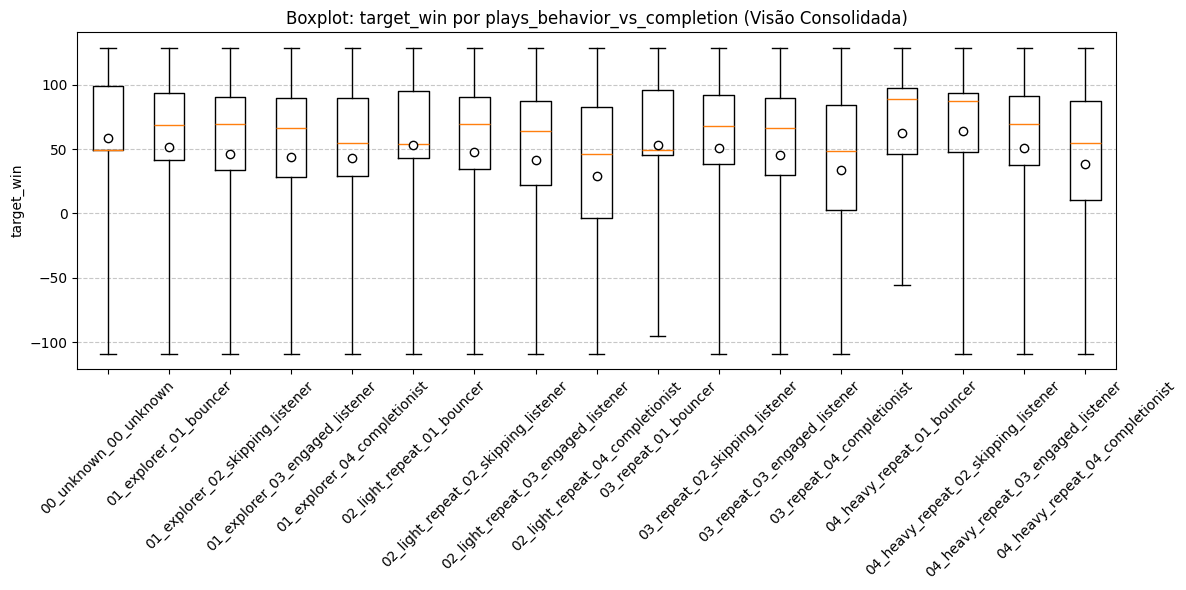


--- Estatísticas: plays_behavior_vs_completion (Visão Consolidada) ---


plays_behavior_vs_completion         min         q1        med  \
9                  00_unknown_00_unknown -108.964925  49.000000  49.000000   
14                01_explorer_01_bouncer -108.964925  41.904914  68.881134   
0       01_explorer_02_skipping_listener -108.964925  33.623792  69.655266   
1        01_explorer_03_engaged_listener -108.964925  28.703267  66.668945   
15          01_explorer_04_completionist -108.964925  29.448625  54.522620   
13            02_light_repeat_01_bouncer -108.964925  42.927304  53.893583   
7   02_light_repeat_02_skipping_listener -108.964925  34.942259  69.217471   
12   02_light_repeat_03_engaged_listener -108.964925  21.829411  64.133545   
10      02_light_repeat_04_completionist -108.964925  -3.545200  46.113688   
8                   03_repeat_01_bouncer  -95.561743  45.556342  49.000000   
6         03_repeat_02_skipping_listener -108.964925  38.638552  68.285445   
3          03_repeat_03_engaged_listener -108.964925  29.738476  66.357642   
11            03_repeat_04_completionist -108.964925   2.603474  48.940250   
4             04_heavy_repeat_01_bouncer  -55.654617  45.896249  88.984306   
16  04_heavy_repeat_02_skipping_listener -108.964925  48.162212  87.234535   
2    04_heavy_repeat_03_engaged_listener -108.964925  37.799963  69.285528   
5       04_heavy_repeat_04_completionist -108.964925  10.632800  54.615218   

         mean         q3         max  
9   58.826712  99.000000  128.953521  
14  51.342202  93.863099  128.953521  
0   46.338807  90.729018  128.953521  
1   43.554958  89.598966  128.953521  
15  43.159527  90.084392  128.953521  
13  53.164761  95.061518  128.953521  
7   48.001702  90.563214  128.953521  
12  41.431446  87.607069  128.953521  
10  28.818655  82.814711  128.953521  
8   53.179968  95.794939  128.953521  
6   50.609403  92.020910  128.953521  
3   45.354010  89.616214  128.953521  
11  33.436580  84.374551  128.953521  
4   62.549088  97.682831  128.953521  
16  64.108226  93.519566  128.953521  
2   51.258640  91.556933  128.953521  
5   38.308231  87.082652  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["plays_behavior_vs_completion"], "target_win", table=True)

Observações-chave:

> Inversão de Monotonicidade:
- explorer_bouncer:        55.4 (média)
- explorer_skipping:       51.0
- explorer_engaged:        48.1
- explorer_completionist:  46.7: MENOR margem

Contra-intuitivo: Quem completa músicas tem margem menor que quem pula. Explicação provável: Completionists ouvem mais segundos, implicando maior custo variável (formula dada).

> Heavy Repeat + Bouncer = Anomalia:
- heavy_repeat_bouncer: 79.3 (média) com apenas 101 casos. Margem altíssima, mas estatisticamente instável. Pode ser ruído ou comportamento de teste/bot.

> Padrão Geral:
- bouncer → margens altas (baixo consumo de segundos)
- completionist → margens médias/baixas (alto consumo)
- Mas a interação com plays_behavior não é aditiva

A variável `completed_songs_rate_group` apresenta relação não-monotônica com a target devido à estrutura de custo. Usuários 'completionists' têm maior consumo de segundos (t), elevando o custo variável. Modelos lineares (Elastic Net) não capturam essa inversão sem transformações adicionais.

Vamos tratar a variavel tambem, considerando o que foi aplicado na variavel acima (uniao das classes que representam menos de 1% da base para LGBM e RF, OHE para Elastic Net):

In [ ]:
freq_table = df_base_logs.groupBy("plays_behavior_vs_completion").count()
freq_table = freq_table.withColumn("pct", F.col("count") / total_logs)

rare_categories = (freq_table
    .filter(F.col("pct") < threshold)
    .select("plays_behavior_vs_completion")
    .rdd.flatMap(lambda x: x).collect())

df_base_logs = df_base_logs.withColumn("plays_behavior_vs_completion_collapsed",
    F.when(F.col("plays_behavior_vs_completion").isin(rare_categories), "99_other")
    .otherwise(F.col("plays_behavior_vs_completion")))

In [ ]:
calcular_distribuicao(df_base_logs, ["plays_behavior_vs_completion_collapsed"], n_show=25)

+--------------------------------------+-------+---------+
|plays_behavior_vs_completion_collapsed|total  |pct_total|
+--------------------------------------+-------+---------+
|01_explorer_02_skipping_listener      |2582106|22.97    |
|01_explorer_03_engaged_listener       |2085466|18.55    |
|01_explorer_04_completionist          |1572874|13.99    |
|01_explorer_01_bouncer                |1394017|12.4     |
|00_unknown_00_unknown                 |1266985|11.27    |
|02_light_repeat_04_completionist      |831674 |7.4      |
|02_light_repeat_03_engaged_listener   |474983 |4.22     |
|03_repeat_04_completionist            |393622 |3.5      |
|03_repeat_03_engaged_listener         |209330 |1.86     |
|04_heavy_repeat_04_completionist      |166684 |1.48     |
|02_light_repeat_02_skipping_listener  |160246 |1.43     |
|99_other                              |104878 |0.93     |
+--------------------------------------+-------+---------+



DataFrame[plays_behavior_vs_completion_collapsed: string, total: bigint, pct_total: double]

Processando estatísticas para: plays_behavior_vs_completion_collapsed...


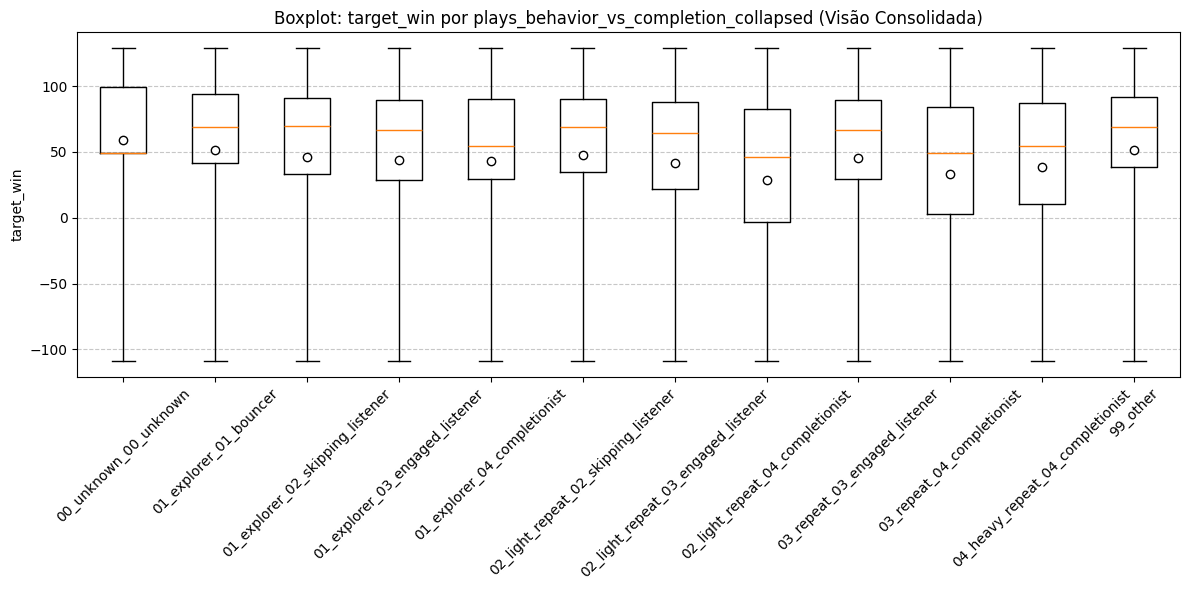


--- Estatísticas: plays_behavior_vs_completion_collapsed (Visão Consolidada) ---


plays_behavior_vs_completion_collapsed         min         q1        med  \
5                   00_unknown_00_unknown -108.964925  49.000000  49.000000   
10                 01_explorer_01_bouncer -108.964925  41.904914  68.881134   
0        01_explorer_02_skipping_listener -108.964925  33.623792  69.655266   
1         01_explorer_03_engaged_listener -108.964925  28.703267  66.668945   
11           01_explorer_04_completionist -108.964925  29.448625  54.522620   
4    02_light_repeat_02_skipping_listener -108.964925  34.942259  69.217471   
9     02_light_repeat_03_engaged_listener -108.964925  21.829411  64.133545   
7        02_light_repeat_04_completionist -108.964925  -3.545200  46.113688   
2           03_repeat_03_engaged_listener -108.964925  29.738476  66.357642   
8              03_repeat_04_completionist -108.964925   2.603474  48.940250   
3        04_heavy_repeat_04_completionist -108.964925  10.632800  54.615218   
6                                99_other -108.964925  38.853453  69.004259   

         mean         q3         max  
5   58.826712  99.000000  128.953521  
10  51.342202  93.863099  128.953521  
0   46.338807  90.729018  128.953521  
1   43.554958  89.598966  128.953521  
11  43.159527  90.084392  128.953521  
4   48.001702  90.563214  128.953521  
9   41.431446  87.607069  128.953521  
7   28.818655  82.814711  128.953521  
2   45.354010  89.616214  128.953521  
8   33.436580  84.374551  128.953521  
3   38.308231  87.082652  128.953521  
6   51.279754  92.095744  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["plays_behavior_vs_completion_collapsed"], "target_win", table=True)

### 8.1.9. catalog_exploration_ratio

Indice de exploracao de catalogo. Se `num_unq` = 100 e `num_100` = 10, significa que o usuário explorou 100 músicas diferentes, mas só 10 delas ele ouviu até o fim, apresentando risco de custo: o usuário é o "pesadelo" da lucratividade. Ele gera custo de únicas em 100 músicas, mas só gera retenção/engajamento real em 10.

In [ ]:
df_base_logs = df_base_logs.withColumn("catalog_exploration_ratio", F.when(F.col("num_100") > 0, F.col("num_unq") / F.col("num_100")).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("catalog_exploration_ratio").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-------------------------+
|summary|catalog_exploration_ratio|
+-------+-------------------------+
|  count|                 11242865|
|   mean|       1.2416204554900776|
| stddev|        2.733478915236974|
|    min|                      0.0|
|     1%|                      0.0|
|     5%|                      0.0|
|    25%|       0.7872340425531915|
|    50%|       1.0569620253164558|
|    75%|        1.352189781021898|
|    95%|       2.5555555555555554|
|  99.5%|        9.666666666666666|
|    max|                   1409.5|
+-------+-------------------------+



A média é 1.24, mas o Max de 1409 indica um outlier extremo ou um bot de exploração. O 75º percentil (1.35) mostra que a maioria é estável.

In [ ]:
df_base_logs.select("catalog_exploration_ratio", "target").corr("catalog_exploration_ratio", "target")

0.007390192064511299

In [ ]:
df_base_logs.select("catalog_exploration_ratio", "target_win").corr("catalog_exploration_ratio", "target_win")

0.007591387615717569

#### Conclusao

Embora a correlação linear seja baixa (0.007), ela captura o custo de aquisição de catálogo. Um usuário com ratio alto consome muitos `num_unq` (caros) para poucos `total_secs` (baratos), o que achata a margem de forma não linear. Vamos somente winsorizar para tratar o outlier encontrado.

In [ ]:
# Calcular o p99.5 de catalog_exploration_ratio
p995_value = df_base_logs.approxQuantile("catalog_exploration_ratio", [0.995], 0.001)[0]

# # Winsorizar no p99.5
df_base_logs = df_base_logs.withColumn("catalog_exploration_ratio_cap",
    F.when(F.col("catalog_exploration_ratio") > p995_value, p995_value)
    .otherwise(F.col("catalog_exploration_ratio")))

### 8.1.10. early_drop_rate

Mede a proporção de rejeição imediata. Valor alto = usuário abandona músicas cedo

In [ ]:
df_base_logs = df_base_logs.withColumn("early_drop_rate",
    F.when(F.col("flag_has_logs").isin(1), ((F.col("num_25") + F.col("num_50")) / F.col("total_plays"))).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("early_drop_rate").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-------------------+
|summary|    early_drop_rate|
+-------+-------------------+
|  count|           11242865|
|   mean| 0.2187835716667449|
| stddev| 0.1924394433941058|
|    min|                0.0|
|     1%|                0.0|
|     5%|                0.0|
|    25%|0.07142857142857142|
|    50%| 0.1795774647887324|
|    75%|0.31841216216216217|
|    95%| 0.5870967741935483|
|  99.5%|                1.0|
|    max|                1.0|
+-------+-------------------+



* Média 0.2188: Usuário típico abandona ~22% das músicas antes de 50%
* Mediana: 0.1796: Metade dos usuários abandona < 18%
* Distribuição bem espalhada de 0 a 1

In [ ]:
df_base_logs.select("early_drop_rate", "target").corr("early_drop_rate", "target")

0.027585258493752995

In [ ]:
df_base_logs.select("early_drop_rate", "target_win").corr("early_drop_rate", "target_win")

0.029375331701637936

#### Agrupamento por buckets semanticos

Entendo que a distribuicao por quartis nao se enquadraria tao bem aqui, entao me basearei em benchmarks de mercado de plataformas similares.

In [ ]:
df_base_logs = df_base_logs.withColumn(
    "early_drop_rate_group",
    F.when(F.col("flag_has_logs").isin(0), "00_unknown")
    .when(F.col("early_drop_rate") == 0.0, "01_completionist") # Ouvinte Passivo/Fiel: Ouve 100% do que começa.
    .when(F.col("early_drop_rate") <= 0.20, "02_engaged") # Ouvinte Engajado: Pula até 1 em cada 5 músicas.
    .when(F.col("early_drop_rate") <= 0.5, "03_explorer") # Explorador: Pula entre 20% e 50%. Está ativamente buscando novas músicas ou pulando o que não conhece.
    .otherwise("04_skipping_heavy")) # Skipper Crônico: Pula mais da metade do que começa

In [ ]:
calcular_distribuicao(df_base_logs, ["early_drop_rate_group"], n_show=5)

+---------------------+-------+---------+
|early_drop_rate_group|total  |pct_total|
+---------------------+-------+---------+
|03_mid_drop          |4019658|35.75    |
|02_low_drop          |3461894|30.79    |
|04_high_drop         |2344556|20.85    |
|00_unknown           |1266985|11.27    |
|01_no_drops          |149772 |1.33     |
+---------------------+-------+---------+



DataFrame[early_drop_rate_group: string, total: bigint, pct_total: double]

In [ ]:
calcular_distribuicao(df_base_logs, ["early_drop_rate_group"], n_show=5)

+---------------------+-------+---------+
|early_drop_rate_group|total  |pct_total|
+---------------------+-------+---------+
|02_engaged           |4713736|41.93    |
|03_explorer          |4179512|37.17    |
|00_unknown           |1266985|11.27    |
|04_skipping_heavy    |932860 |8.3      |
|01_completionist     |149772 |1.33     |
+---------------------+-------+---------+



DataFrame[early_drop_rate_group: string, total: bigint, pct_total: double]

Processando estatísticas para: early_drop_rate_group...


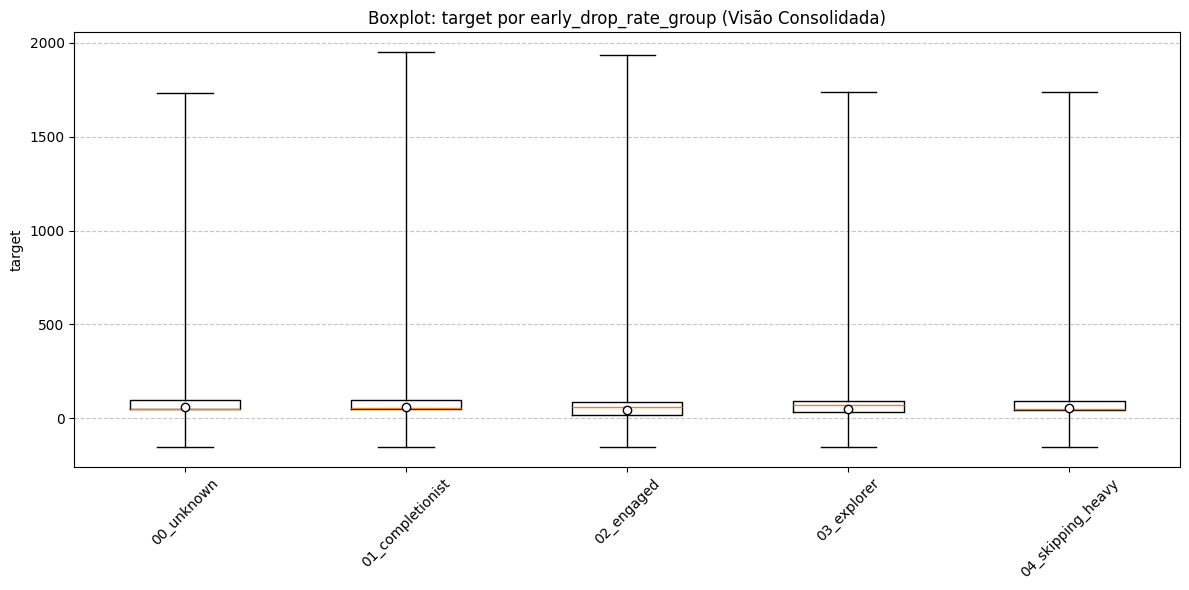


--- Estatísticas: early_drop_rate_group (Visão Consolidada) ---


early_drop_rate_group       min         q1        med       mean         q3  \
3            00_unknown -152.5452  49.000000  49.000000  59.177692  99.000000   
4      01_completionist -152.5452  47.909256  52.531569  59.778722  98.079942   
0            02_engaged -152.5452  15.447453  57.945166  43.065701  88.114122   
1           03_explorer -152.5452  33.682963  69.070284  50.960407  90.766410   
2     04_skipping_heavy -152.5452  43.751409  49.000000  55.236123  94.193216   

           max  
3  1733.833386  
4  1950.000000  
0  1936.799455  
1  1737.947047  
2  1737.640612

In [ ]:
plot_boxplot(df_base_logs, ["early_drop_rate_group"], "target", table=True)

Processando estatísticas para: early_drop_rate_group...


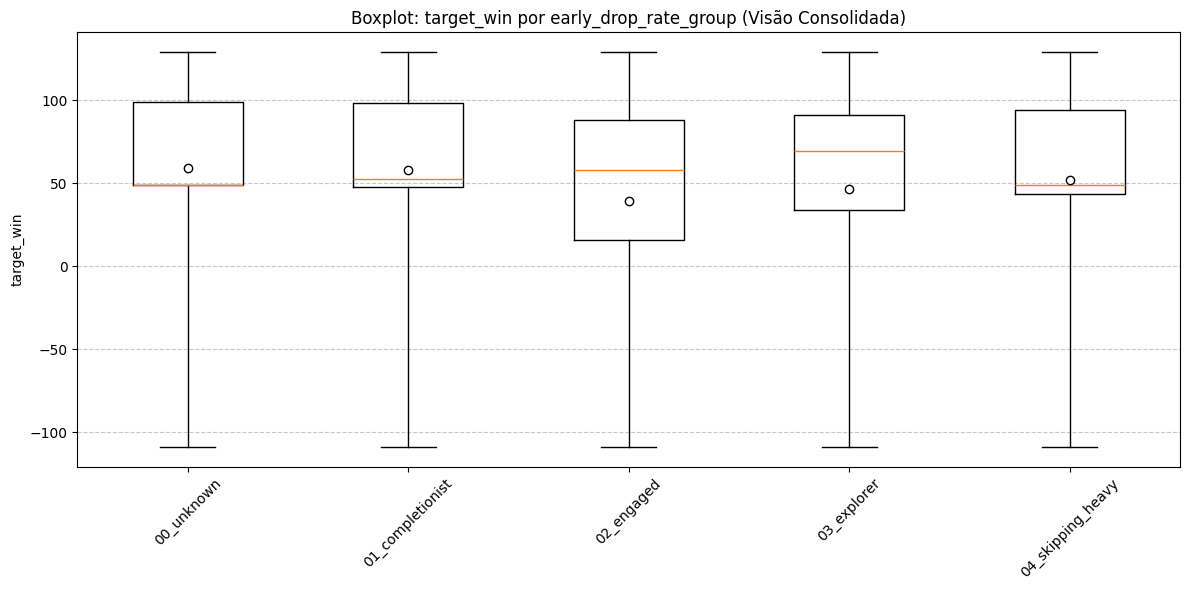


--- Estatísticas: early_drop_rate_group (Visão Consolidada) ---


early_drop_rate_group         min         q1        med       mean  \
3            00_unknown -108.964925  49.000000  49.000000  58.826712   
4      01_completionist -108.964925  47.909256  52.531569  58.109204   
0            02_engaged -108.964925  15.447453  57.945166  39.299785   
1           03_explorer -108.964925  33.682963  69.070284  46.388026   
2     04_skipping_heavy -108.964925  43.751409  49.000000  51.688403   

          q3         max  
3  99.000000  128.953521  
4  98.079942  128.953521  
0  88.114122  128.953521  
1  90.766410  128.953521  
2  94.193216  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["early_drop_rate_group"], "target_win", table=True)

Conforme o early_drop_rate aumenta, a margem melhora. Isso ocorre porque o custo de streaming é altamente sensível ao tempo total escutado (`total_secs`). O usuário 'skipper' gera muitas transações de início de música, mas como ele abandona a maioria rapidamente, o custo acumulado de tempo é baixo, preservando a margem líquida.

#### Conclusao

Levar a variavel para feature engineering, considerando que traz uma diferenciacao muito boa entre quem paga mais e menos atraves da atividade (musicas terminadas entre 25% e 50% de sua duracao)

### 8.1.11. completion_efficiency

Engajamento profundo. Proporção de músicas completadas entre as que chegaram perto do final

In [ ]:
df_base_logs = df_base_logs.withColumn("completion_efficiency",
    F.when(F.col("flag_has_logs").isin(1), (F.col("num_100") / (F.col("num_75") + F.col("num_985") + F.col("num_100")))).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("completion_efficiency").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+---------------------+
|summary|completion_efficiency|
+-------+---------------------+
|  count|             11162609|
|   mean|   0.7935542094731889|
| stddev|   0.3082002886413479|
|    min|                  0.0|
|     1%|                  0.0|
|     5%|                  0.0|
|    25%|    0.830379746835443|
|    50%|   0.9187935034802784|
|    75%|   0.9606060606060606|
|    95%|   0.9933692498963945|
|  99.5%|                  1.0|
|    max|                  1.0|
+-------+---------------------+



Pela distribuicao, aqui talvez faca mais sentido trabalhar com uma flag do que com agrupamento para mais de uma categoria

In [ ]:
df_base_logs.select("completion_efficiency", "target").corr("completion_efficiency", "target")

-0.026618318843222976

In [ ]:
df_base_logs.select("completion_efficiency", "target_win").corr("completion_efficiency", "target_win")

-0.054077500832352896

#### flag_near_completion

In [ ]:
df_base_logs = df_base_logs.withColumn("flag_near_completion", F.when(F.col("completion_efficiency") > 0.0, 1).otherwise(0))

In [ ]:
calcular_distribuicao(df_base_logs, ["flag_near_completion"], n_show=2)

+--------------------+-------+---------+
|flag_near_completion|total  |pct_total|
+--------------------+-------+---------+
|1                   |9833018|87.46    |
|0                   |1409847|12.54    |
+--------------------+-------+---------+



DataFrame[flag_near_completion: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_near_completion...


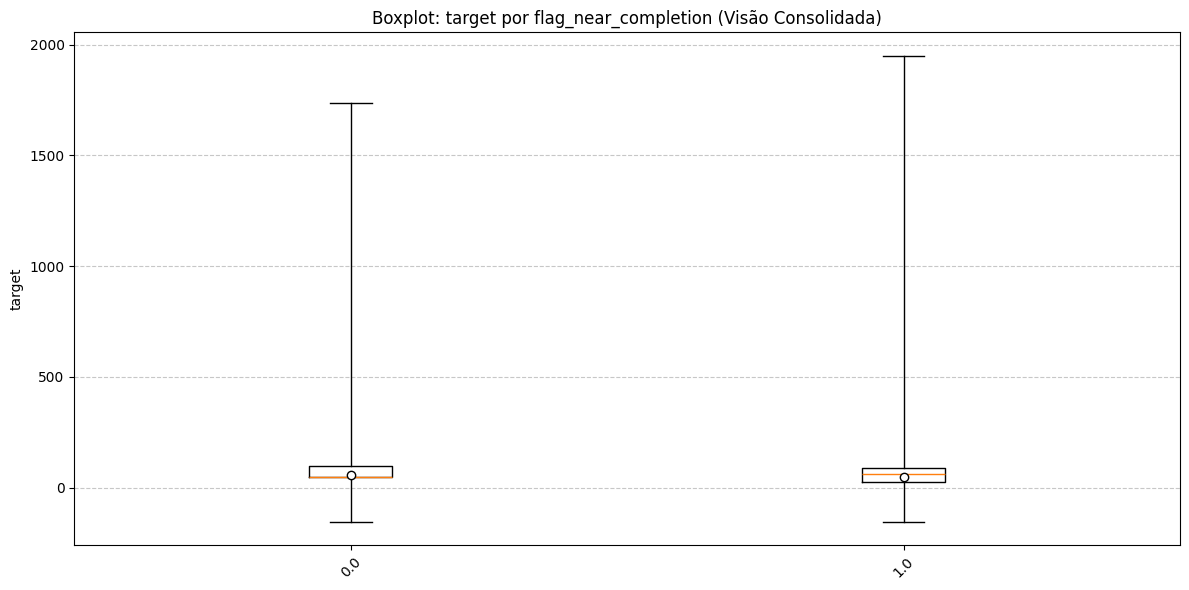


--- Estatísticas: flag_near_completion (Visão Consolidada) ---


flag_near_completion       min         q1        med       mean         q3  \
1                     0 -152.5452  49.000000  49.000000  58.720001  99.000000   
0                     1 -152.5452  27.704808  63.644117  47.615418  90.030962   

           max  
1  1736.522159  
0  1950.000000

In [ ]:
plot_boxplot(df_base_logs, ["flag_near_completion"], "target", table=True)

Processando estatísticas para: flag_near_completion...


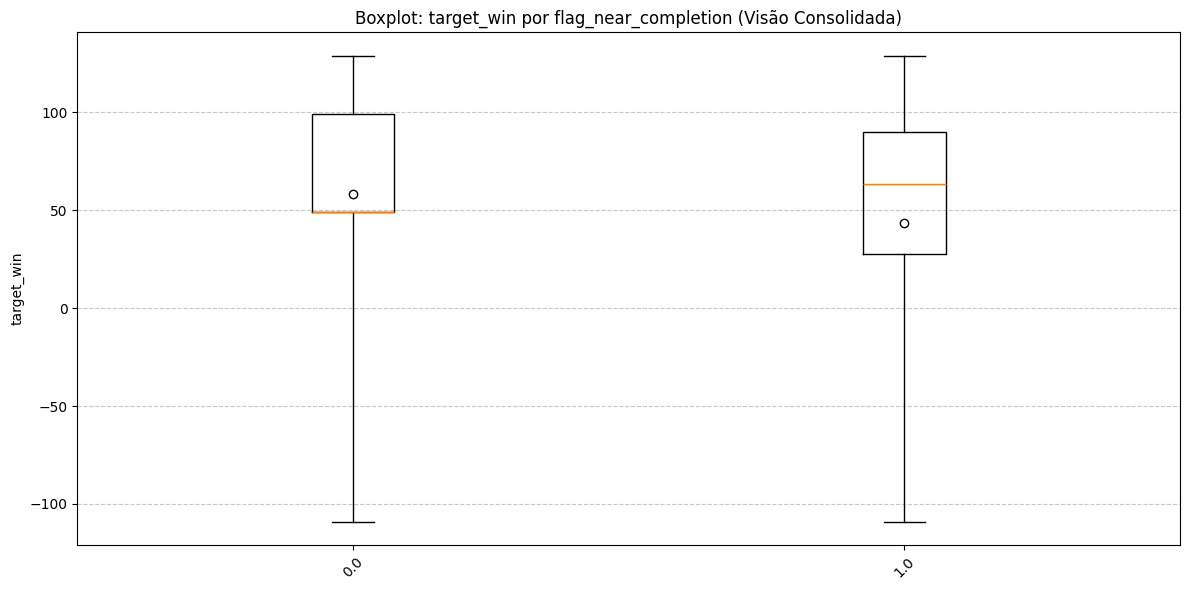


--- Estatísticas: flag_near_completion (Visão Consolidada) ---


flag_near_completion         min         q1        med       mean  \
1                     0 -108.964925  49.000000  49.000000  58.312417   
0                     1 -108.964925  27.704808  63.644117  43.522534   

          q3         max  
1  99.000000  128.953521  
0  90.030962  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["flag_near_completion"], "target_win", table=True)

Nao me pareceu boa. Nao agrega em poder preditivo (distribuicao "desequilibrada) ou com informacao nova: por capturar os casos que nao existem registros de logs, se torna extremamente semelhante a `flag_has_logs`. Desconsiderar a flag.

#### Agrupamento semantico (talvez nao tao bom)

In [ ]:
df_base_logs = df_base_logs.withColumn("completion_efficiency_group",
    F.when(F.col("flag_has_logs") == 0, "00_unknown")
     .when(F.col("completion_efficiency") == 0, "01_never_complete")
     .when(F.col("completion_efficiency") <= 0.5, "02_partial_complete")
     .when(F.col("completion_efficiency") <= 0.8, "03_mostly_complete")
     .otherwise("04_full_complete"))

In [ ]:
calcular_distribuicao(df_base_logs, ["completion_efficiency_group"], n_show=5)

+---------------------------+-------+---------+
|completion_efficiency_group|total  |pct_total|
+---------------------------+-------+---------+
|04_full_complete           |8818471|78.44    |
|00_unknown                 |1266985|11.27    |
|03_mostly_complete         |934663 |8.31     |
|02_partial_complete        |160140 |1.42     |
|01_never_complete          |62606  |0.56     |
+---------------------------+-------+---------+



DataFrame[completion_efficiency_group: string, total: bigint, pct_total: double]

Processando estatísticas para: completion_efficiency_group...


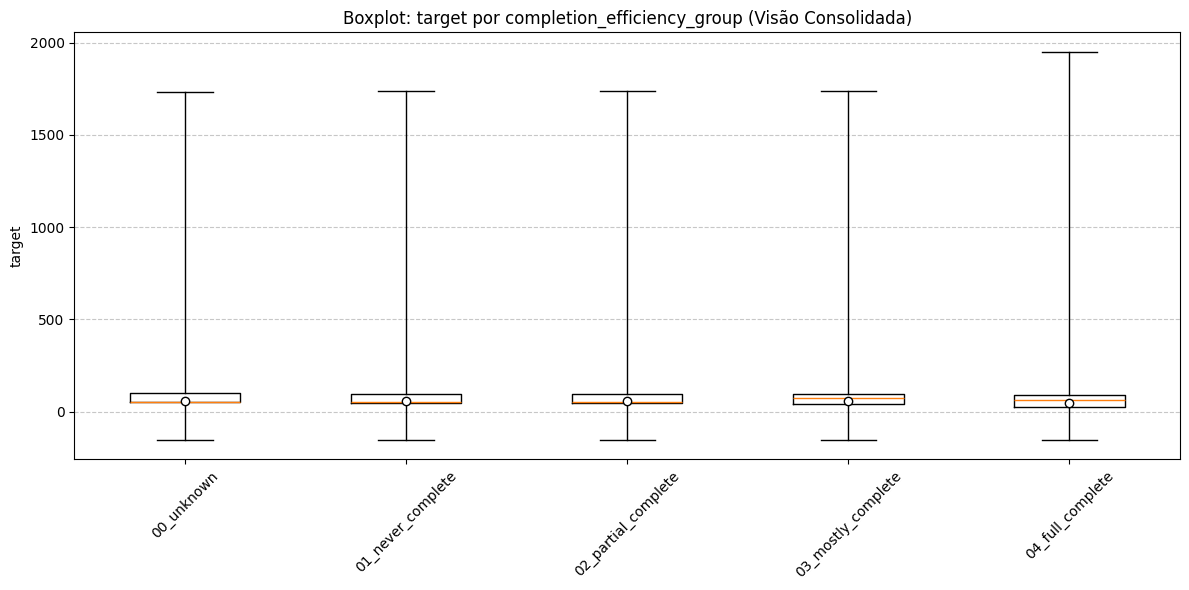


--- Estatísticas: completion_efficiency_group (Visão Consolidada) ---


completion_efficiency_group       min         q1        med       mean  \
3                  00_unknown -152.5452  49.000000  49.000000  59.177692   
2           01_never_complete -152.5452  48.423280  49.000000  55.701827   
4         02_partial_complete -152.5452  47.061359  49.000000  57.001885   
0          03_mostly_complete -152.5452  42.430658  72.575104  56.269346   
1            04_full_complete -152.5452  25.318736  62.944739  46.596456   

          q3          max  
3  99.000000  1733.833386  
2  97.665799  1736.522159  
4  97.025667  1736.130944  
0  94.386882  1737.640612  
1  89.344136  1950.000000

In [ ]:
plot_boxplot(df_base_logs, ["completion_efficiency_group"], "target", table=True)

Processando estatísticas para: completion_efficiency_group...


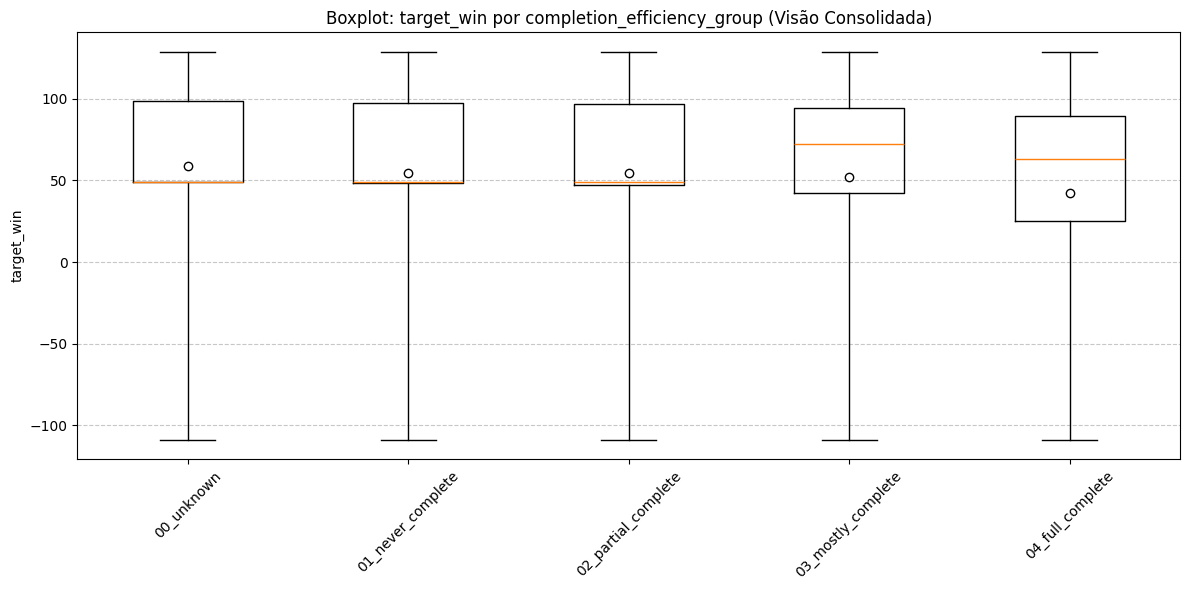


--- Estatísticas: completion_efficiency_group (Visão Consolidada) ---


completion_efficiency_group         min         q1        med       mean  \
3                  00_unknown -108.964925  49.000000  49.000000  58.826712   
2           01_never_complete -108.964925  48.423280  49.000000  54.449724   
4         02_partial_complete -108.964925  47.061359  49.000000  54.646151   
0          03_mostly_complete -108.964925  42.430658  72.575104  52.399756   
1            04_full_complete -108.964925  25.318736  62.944739  42.475046   

          q3         max  
3  99.000000  128.953521  
2  97.665799  128.953521  
4  97.025667  128.953521  
0  94.386882  128.953521  
1  89.344136  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["completion_efficiency_group"], "target_win", table=True)

Variavel altamente concentrada, e os valores nos permitem concluir relacao notoria com a flag. Os tres primeiros grupos possuem valores muito proximos para a `flag_near_completion` == 0, e os demais `flag_near_completion` == 1. Ate existe uma relacao clara: quanto maior a eficiência de conclusão, menor a margem. Porem, a separação só acontece no extremo (full_complete, demais), evidenciando que os grupos intermediarios nao se diferenciam. Nem a flag nem a versão agrupada adicionam poder preditivo real.

#### Conclusao

A taxa de eficiência de conclusão foi inicialmente discretizada para análise exploratória. Entretanto, observou-se forte concentração no grupo de conclusão total (>78%) e baixa separação de margem nos demais grupos. Dado isso, a variável foi mantida em sua forma contínua, e eventualmente sera sujeita a transformações temporais (média, razão e estabilidade), buscando ampliar p poder explicativo e interpretabilidade.

Se o usuário dá play em muitas músicas únicas mas a grande maioria cai no bin `num_25` (menos de 25% da música), ele está procurando algo que não acha.

In [ ]:
df_base_logs = df_base_logs.withColumn("frustration_index", F.when(F.col("flag_has_logs").isin(1), (F.col("num_25") / F.col("num_unq"))).otherwise(0.0))

#### Descritivas + correlacao com target

In [ ]:
df_base_logs.select("frustration_index").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-------------------+
|summary|  frustration_index|
+-------+-------------------+
|  count|           11242865|
|   mean| 0.2306981666446601|
| stddev|  0.251566060885176|
|    min|                0.0|
|     1%|                0.0|
|     5%|                0.0|
|    25%|0.06716417910447761|
|    50%|0.18058690744920994|
|    75%|0.32947976878612717|
|    95%| 0.6226993865030674|
|  99.5%| 1.1443298969072164|
|    max|  90.33333333333333|
+-------+-------------------+



In [ ]:
df_base_logs.select("frustration_index", "target").corr("frustration_index", "target")

0.01750115038300395

In [ ]:
df_base_logs.select("frustration_index", "target_win").corr("frustration_index", "target_win")

0.019564472496029384

### 8.1.12. long_listening_flag

Demarcar usuarios que escutam por muitas horas (10h, no caso)

In [ ]:
df_base_logs = df_base_logs.withColumn("long_listening_flag", F.when(F.col("total_secs") >= 36000, 1).otherwise(0))  # 10h/mês

In [ ]:
calcular_distribuicao(df_base_logs, ["long_listening_flag"], n_show=2)

+-------------------+-------+---------+
|long_listening_flag|total  |pct_total|
+-------------------+-------+---------+
|1                  |7107380|63.22    |
|0                  |4135485|36.78    |
+-------------------+-------+---------+



DataFrame[long_listening_flag: int, total: bigint, pct_total: double]

Processando estatísticas para: long_listening_flag...


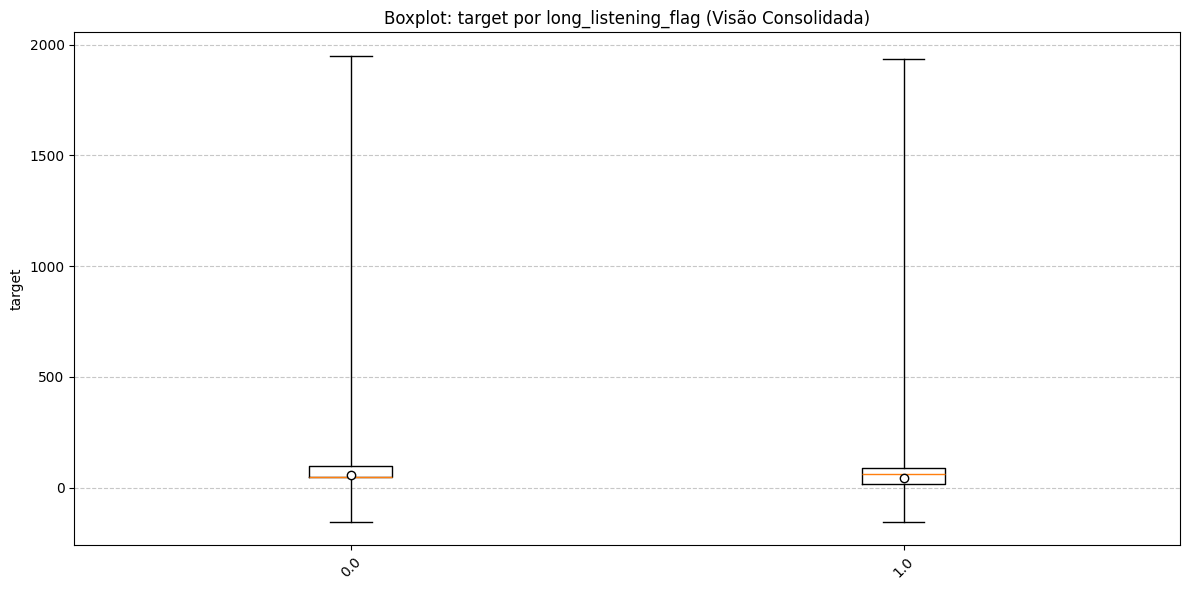


--- Estatísticas: long_listening_flag (Visão Consolidada) ---


long_listening_flag       min         q1        med       mean         q3  \
1                    0 -152.5452  47.113233  49.000000  58.945791  97.288186   
0                    1 -152.5452  14.945088  63.166128  43.450361  86.763500   

           max  
1  1950.000000  
0  1936.799455

In [ ]:
plot_boxplot(df_base_logs, ["long_listening_flag"], "target", table=True)

Processando estatísticas para: long_listening_flag...


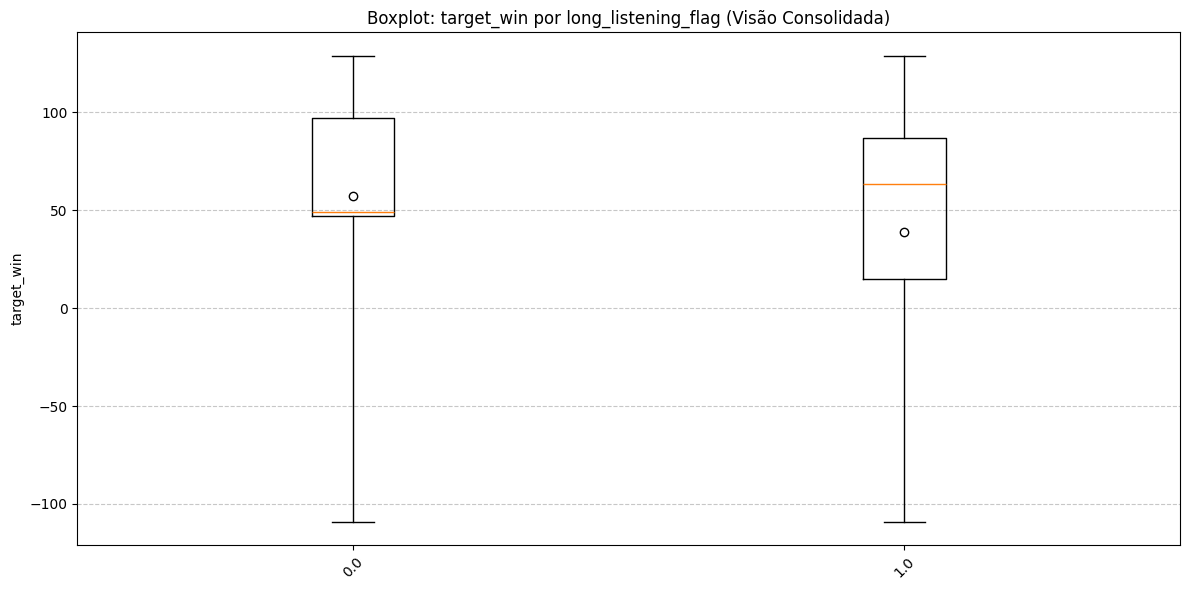


--- Estatísticas: long_listening_flag (Visão Consolidada) ---


long_listening_flag         min         q1        med       mean  \
1                    0 -108.964925  47.113233  49.000000  57.039820   
0                    1 -108.964925  14.945088  63.166128  38.819726   

          q3         max  
1  97.288186  128.953521  
0  86.763500  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["long_listening_flag"], "target_win", table=True)

#### Conclusao

Tambem se mostra muito proxima da `flag_has_logs`. Nao vou levar para feature engineering.

### 8.1.13. flag_shallow_user

Consumo superficial. Publico que teoricamente gera pouco custo: paga mas nao usa

In [ ]:
df_base_logs = df_base_logs.withColumn("flag_shallow_user", F.when((F.col("num_25") > 0) & (F.col("num_100") == 0), 1).otherwise(0))

In [ ]:
calcular_distribuicao(df_base_logs, ["flag_shallow_user"], n_show=2)

+-----------------+--------+---------+
|flag_shallow_user|total   |pct_total|
+-----------------+--------+---------+
|0                |11124479|98.95    |
|1                |118386  |1.05     |
+-----------------+--------+---------+



DataFrame[flag_shallow_user: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_shallow_user...


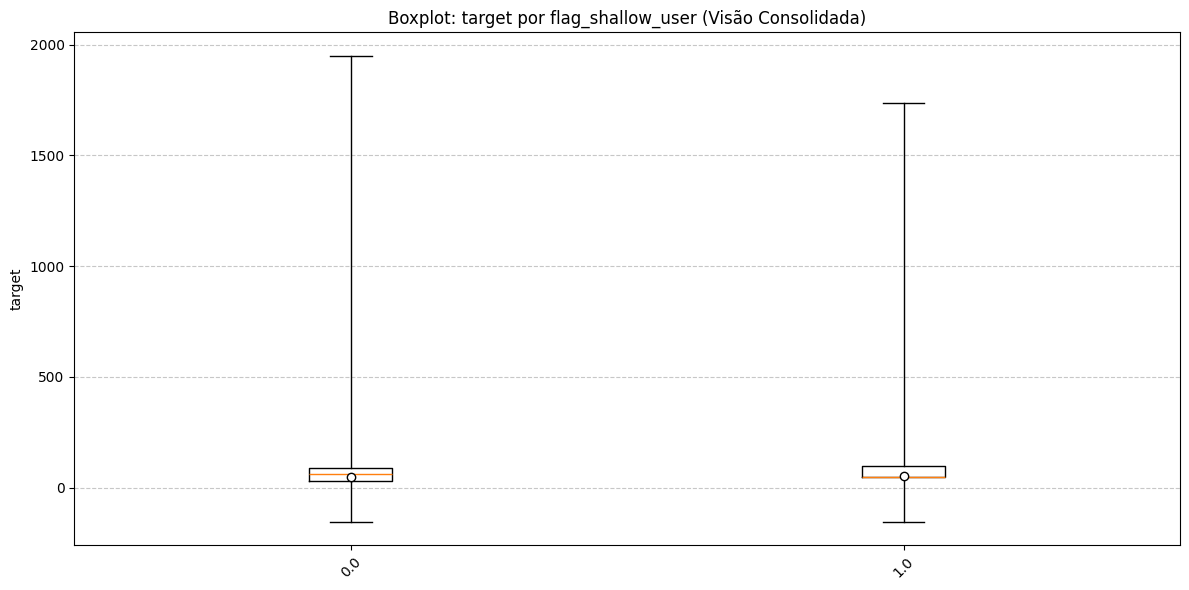


--- Estatísticas: flag_shallow_user (Visão Consolidada) ---


flag_shallow_user       min         q1        med       mean         q3  \
1                  0 -152.5452  32.332491  60.918663  48.820812  90.846064   
0                  1 -152.5452  48.509472  49.000000  53.715153  96.299630   

           max  
1  1950.000000  
0  1736.522159

In [ ]:
plot_boxplot(df_base_logs, ["flag_shallow_user"], "target", table=True)

Processando estatísticas para: flag_shallow_user...


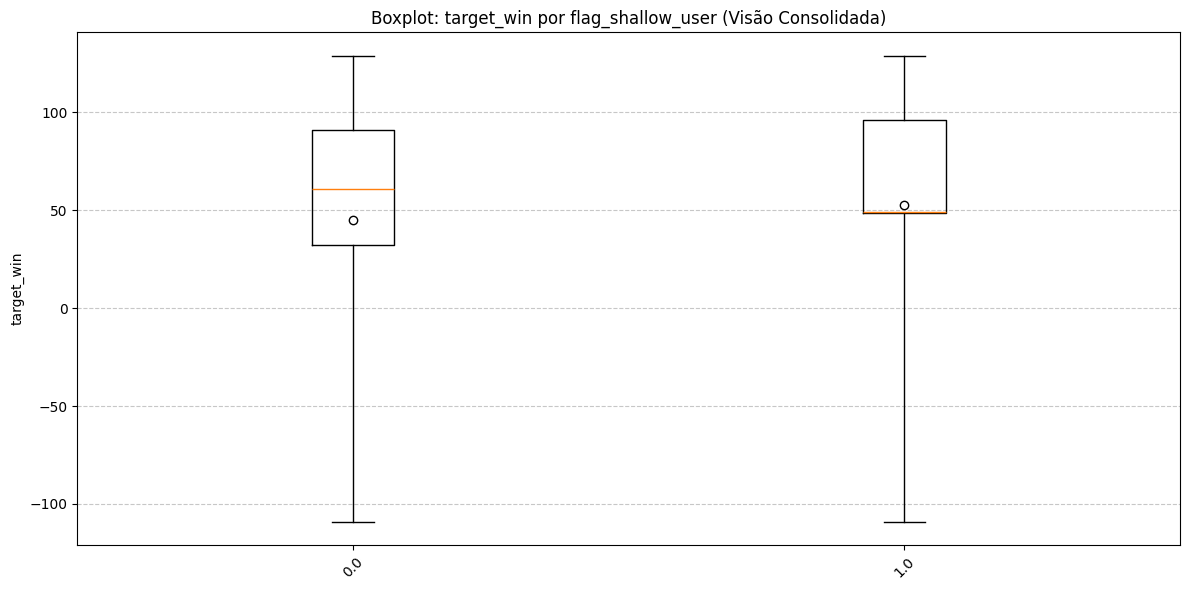


--- Estatísticas: flag_shallow_user (Visão Consolidada) ---


flag_shallow_user         min         q1        med       mean         q3  \
1                  0 -108.964925  32.332491  60.918663  45.118069  90.846064   
0                  1 -108.964925  48.509472  49.000000  52.792964  96.299630   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_logs, ["flag_shallow_user"], "target_win", table=True)

#### Conclusao

Shallow users pagam assinatura mas geram baixo custo variável (pouco tempo de escuta). Importante levar pela diferenca entre os valores descritivos.

## 8.2. Transactions

In [ ]:
transactions_vars = [
    "payment_method_id",
    "payment_plan_days",
    "plan_list_price",
    "actual_amount_paid",
    "is_auto_renew",
    "transaction_date",
    "membership_expire_date",
    "is_cancel",
    "flag_expire_invalido",
]

df_base_trans = df_base.select("msno", "safra", "target", "target_win", *transactions_vars)

### 8.2.1. flag_has_transactions

In [ ]:
df_base_trans = df_base_trans.withColumn("flag_has_transactions", F.when(F.col("payment_method_id").isNull(), 0).otherwise(1))

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_has_transactions"], n_show=2)

+---------------------+-------+---------+
|flag_has_transactions|total  |pct_total|
+---------------------+-------+---------+
|1                    |9390483|83.52    |
|0                    |1852382|16.48    |
+---------------------+-------+---------+



DataFrame[flag_has_transactions: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_has_transactions...


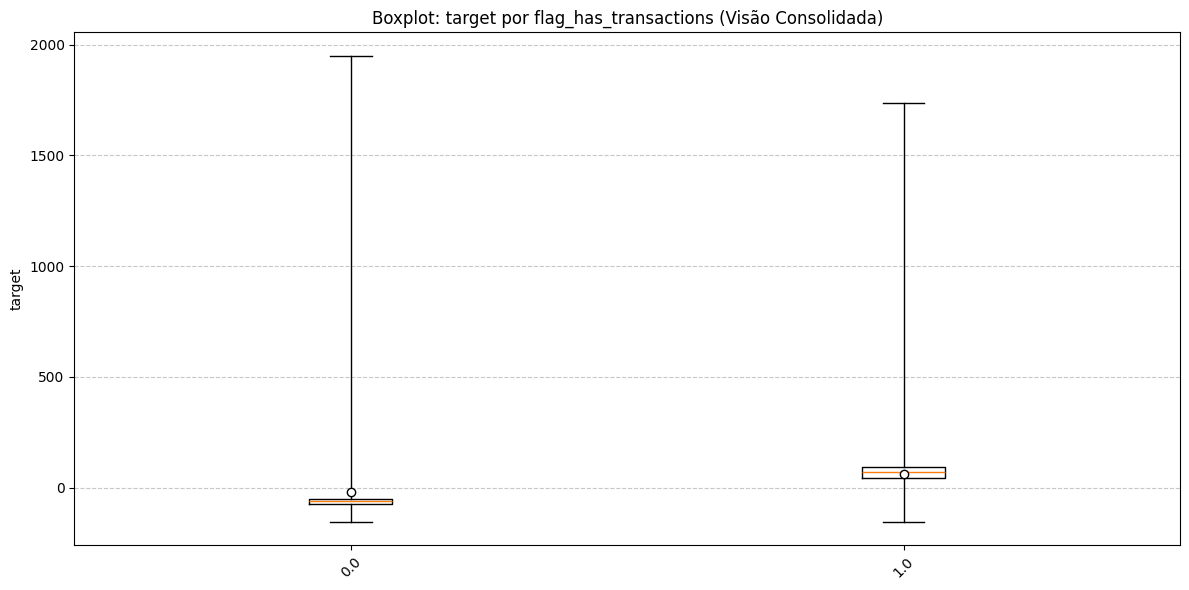


--- Estatísticas: flag_has_transactions (Visão Consolidada) ---


flag_has_transactions       min         q1        med       mean  \
1                      0 -152.5452 -71.491939 -58.890695 -21.018945   
0                      1 -152.5452  45.088921  71.995375  62.083651   

          q3          max  
1 -50.309033  1950.000000  
0  92.325581  1737.859653

In [ ]:
plot_boxplot(df_base_trans, ["flag_has_transactions"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_has_transactions...


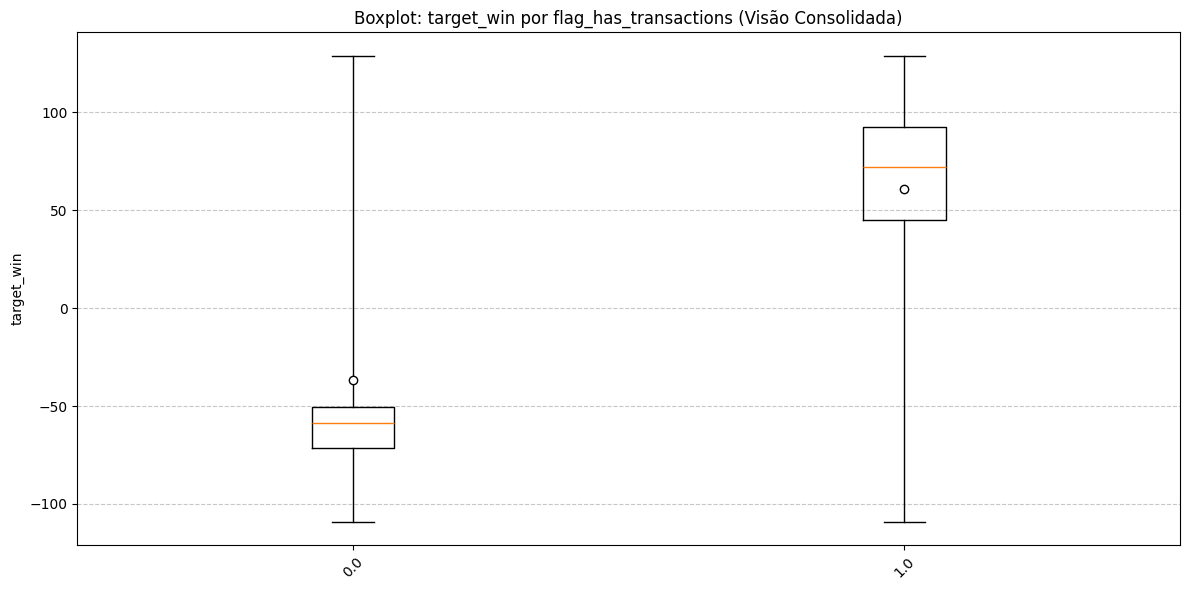


--- Estatísticas: flag_has_transactions (Visão Consolidada) ---


flag_has_transactions         min         q1        med       mean  \
1                      0 -108.964925 -71.491939 -58.890695 -36.612835   
0                      1 -108.964925  45.088921  71.995375  60.658898   

          q3         max  
1 -50.309033  128.953521  
0  92.325581  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["flag_has_transactions"], "target_win", agrupar_por_safra=False, table=True)

Naturalmente, usuarios que nao possuem registros de transacoes nao possuem pagamento registrado, o que implica em valores negativos de margem liquida pelo custo padrao de 50 reais e pelos possiveis acrescimos neste valor nos casos em que existe registros de uso (logs).

### 8.2.2. transaction_date

Quando os pagamentos sao feitos? Pelo que foi visto no EDA inicial, nao existe dia fixo. Sendo assim, nao aparenta ser uma boa ideia considerar o uso de `actual_amount_paid` para o modelo prever resultados. Tambem existe essa complicacao para a tabela de logs, que registra a utilizacao do usuario na plataforma.

In [ ]:
df_base_trans = df_base_trans.withColumn("payment_day", F.dayofmonth(F.to_date(F.col("transaction_date"), "yyyyMMdd")))

In [ ]:
df_base_trans.filter(F.col("payment_day").isNull()).show(5, truncate=False)

+--------------------------------------------+------+---------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----------------+-----------+
|msno                                        |safra |margem_liquida_mensal|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|flag_plano_mensal|payment_day|
+--------------------------------------------+------+---------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+-----------------+-----------+
|++9l7+WGOZ96gNp0TDXxHAydOlXYE0CiuqWFTxA6zZI=|201606|-85.15690500000001   |NULL             |NULL             |NULL           |NULL              |NULL         |NULL            |NULL                  |NULL     |0                |NULL       |
|++I1wsXaVBTTZE3gwzQ5qBWLcMMCxSInWe2

In [ ]:
calcular_distribuicao(df_base_trans, ["payment_day"], n_show=31)

+-----------+-------+---------+
|payment_day|total  |pct_total|
+-----------+-------+---------+
|NULL       |1852382|16.48    |
|31         |1092679|9.72     |
|30         |596721 |5.31     |
|9          |287773 |2.56     |
|6          |287075 |2.55     |
|4          |286865 |2.55     |
|16         |283210 |2.52     |
|11         |283116 |2.52     |
|21         |282850 |2.52     |
|5          |282462 |2.51     |
|20         |281859 |2.51     |
|19         |281180 |2.5      |
|7          |277675 |2.47     |
|26         |277434 |2.47     |
|25         |275923 |2.45     |
|17         |274890 |2.45     |
|15         |274216 |2.44     |
|10         |273710 |2.43     |
|13         |273598 |2.43     |
|22         |272501 |2.42     |
|12         |272173 |2.42     |
|8          |271910 |2.42     |
|3          |271356 |2.41     |
|18         |270381 |2.4      |
|27         |267152 |2.38     |
|14         |261385 |2.32     |
|23         |260645 |2.32     |
|24         |260475 |2.32     |
|2      

DataFrame[payment_day: int, total: bigint, pct_total: double]

### 8.2.3. payment_plan_days + actual_amount_paid

#### 8.2.3.1. flags

**Cobrança Válida** - `valid_fee`

In [ ]:
df_base_trans = (df_base_trans
    .withColumn("flag_valid_fee", # Flag: cobrança válida (plano real)
        F.when((F.col("payment_plan_days") > 0) & (F.col("plan_list_price") > 0), 1).otherwise(0)))

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_valid_fee"])

+--------------+-------+---------+
|flag_valid_fee|total  |pct_total|
+--------------+-------+---------+
|1             |9081504|80.78    |
|0             |2161361|19.22    |
+--------------+-------+---------+



DataFrame[flag_valid_fee: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_valid_fee...


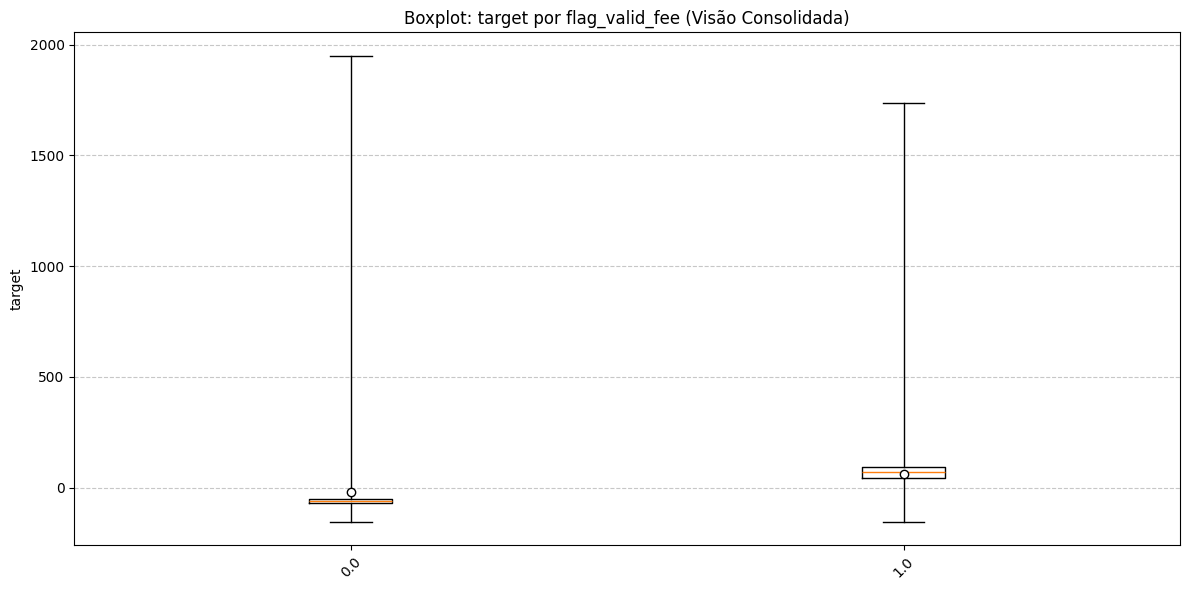


--- Estatísticas: flag_valid_fee (Visão Consolidada) ---


flag_valid_fee       min         q1        med       mean         q3  \
1               0 -152.5452 -71.081910 -58.479486 -19.786860 -50.033419   
0               1 -152.5452  45.212528  72.097178  62.316011  92.335408   

           max  
1  1950.000000  
0  1737.859653

In [ ]:
plot_boxplot(df_base_trans, ["flag_valid_fee"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_valid_fee...


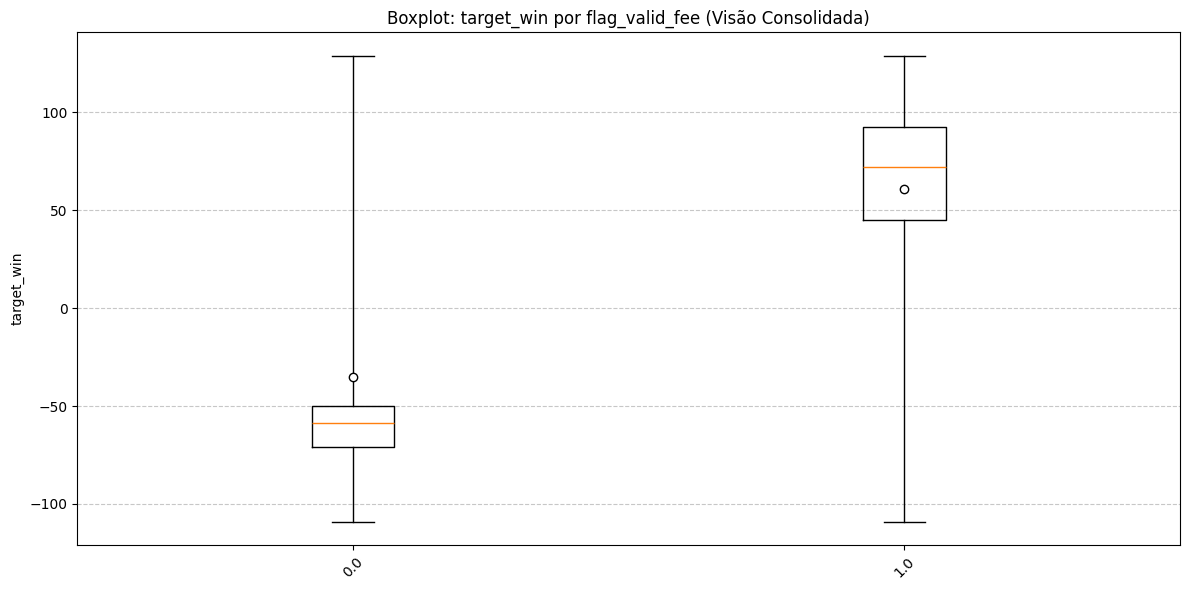


--- Estatísticas: flag_valid_fee (Visão Consolidada) ---


flag_valid_fee         min         q1        med       mean         q3  \
1               0 -108.964925 -71.081910 -58.479486 -35.254039 -50.033419   
0               1 -108.964925  45.212528  72.097178  60.947213  92.335408   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["flag_valid_fee"], "target_win", agrupar_por_safra=False, table=True)

* Separação forte
* Diferença estrutural clara entre regimes
* Alta estabilidade estatística (volume alto)

**Sem Cobrança** - `no_flee`

In [ ]:
df_base_trans = (df_base_trans
    .withColumn("flag_no_fee", # Flag: sem cobrança (estado administrativo)
        F.when(F.col("payment_plan_days") == 0, 1).otherwise(0)))

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_no_fee"])

+-----------+--------+---------+
|flag_no_fee|total   |pct_total|
+-----------+--------+---------+
|0          |11242865|100.0    |
+-----------+--------+---------+



DataFrame[flag_no_fee: int, total: bigint, pct_total: double]

In [ ]:
df_base_trans.filter(F.col("payment_plan_days").isin(0)).show(5, truncate=False)

+----+-----+---------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------------+-----------+--------------+---------------+---------------------------+
|msno|safra|margem_liquida_mensal|payment_method_id|payment_plan_days|plan_list_price|actual_amount_paid|is_auto_renew|transaction_date|membership_expire_date|is_cancel|flag_valid_fee|flag_no_fee|flag_exemption|flag_no_payment|flag_payment_without_charge|
+----+-----+---------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------------+-----------+--------------+---------------+---------------------------+
+----+-----+---------------------+-----------------+-----------------+---------------+------------------+-------------+----------------+----------------------+---------+--------------+-----------+--------------+---------------+-----

Descartar.

**Isenção** - `exemption`

In [ ]:
df_base_trans = (df_base_trans
    .withColumn("flag_exemption", # Flag: isenção (nem cobrou nem pagou, sem cancelamento)
        F.when((F.col("actual_amount_paid") == 0) & (F.col("plan_list_price") == 0) & (F.col("is_cancel") == 0), 1).otherwise(0)))

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_exemption"])

+--------------+--------+---------+
|flag_exemption|total   |pct_total|
+--------------+--------+---------+
|0             |10933887|97.25    |
|1             |308978  |2.75     |
+--------------+--------+---------+



DataFrame[flag_exemption: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_exemption...


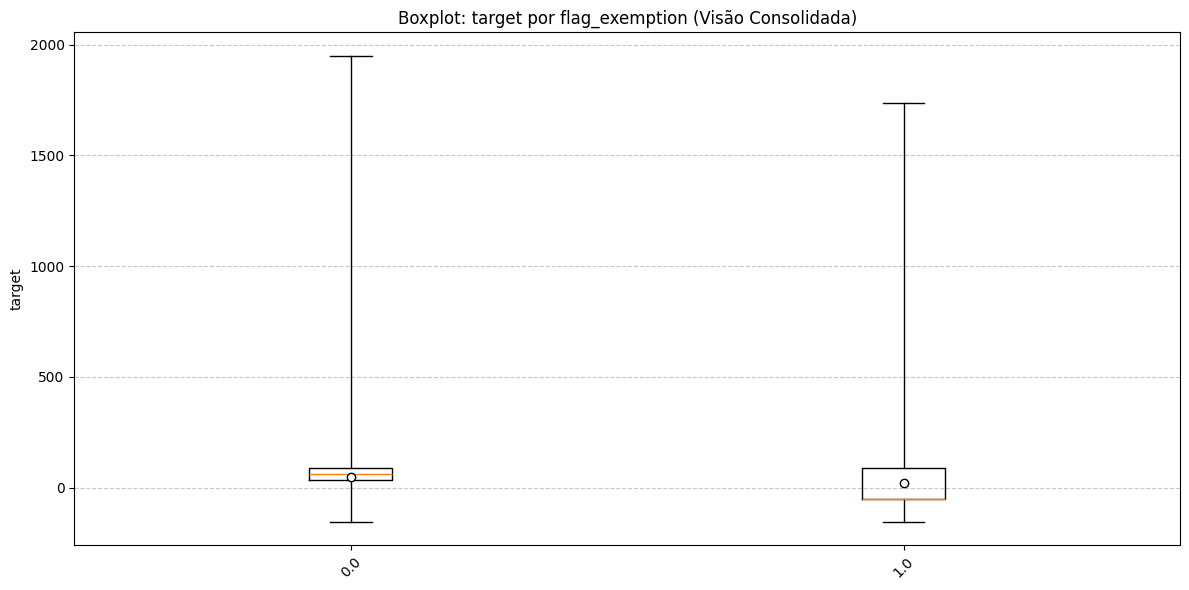


--- Estatísticas: flag_exemption (Visão Consolidada) ---


flag_exemption       min         q1        med       mean         q3  \
1               0 -152.5452  32.992890  60.572939  48.994570  90.865147   
0               1 -152.5452 -52.148538 -50.000000  21.331289  89.127693   

           max  
1  1950.000000  
0  1735.412335

In [ ]:
plot_boxplot(df_base_trans, ["flag_exemption"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_exemption...


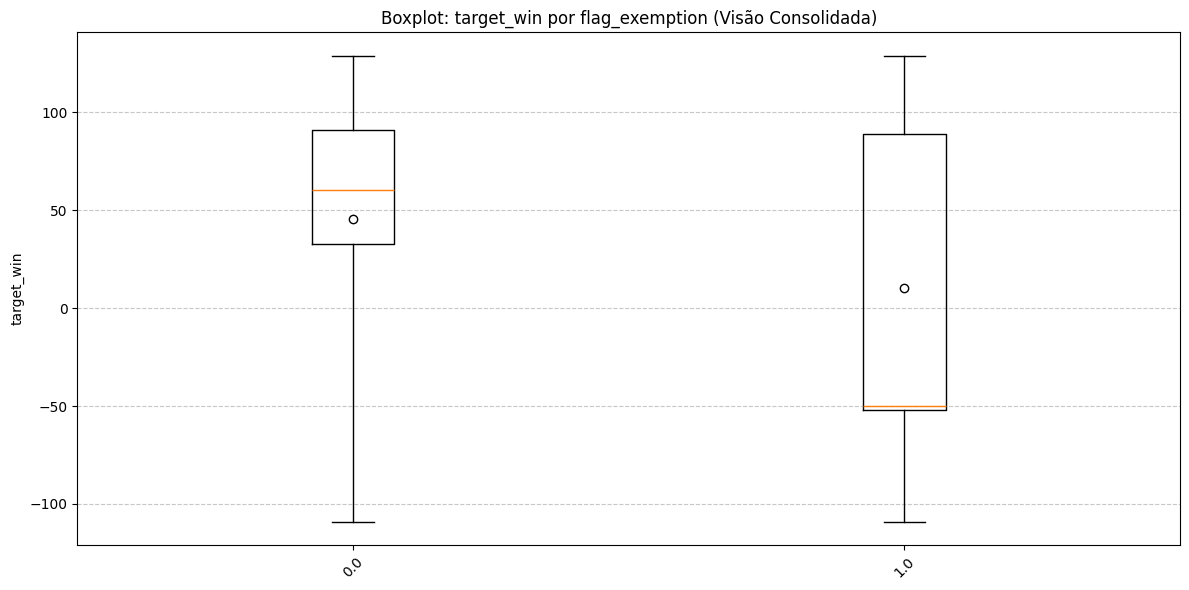


--- Estatísticas: flag_exemption (Visão Consolidada) ---


flag_exemption         min         q1        med       mean         q3  \
1               0 -108.964925  32.992890  60.572939  45.351834  90.865147   
0               1 -108.964925 -52.148538 -50.000000  10.092382  89.127693   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["flag_exemption"], "target_win", agrupar_por_safra=False, table=True)

Pelas medianas:

* Apesar do volume pequeno (2,75%), o comportamento é coerente e distinto
* Representa um estado operacional específico, não ruído

**Cobrança sem pagamento** - `no_payment`

In [ ]:
df_base_trans = (df_base_trans
    .withColumn("flag_no_payment", # Flag: cobrança sem pagamento (possível falha / desconto / churn latente)
        F.when((F.col("actual_amount_paid") <= 0) & (F.col("plan_list_price") > 0), 1).otherwise(0)))

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_no_payment"])

+---------------+--------+---------+
|flag_no_payment|total   |pct_total|
+---------------+--------+---------+
|0              |11187843|99.51    |
|1              |55022   |0.49     |
+---------------+--------+---------+



DataFrame[flag_no_payment: int, total: bigint, pct_total: double]

* Volume muito baixo (0.49%)
* Pode confundir com outros regimes (cancelamento, atraso)

Descartar

**Pagamento sem cobrança** - `payment_without_charge`

In [ ]:
df_base_trans = (df_base_trans
    .withColumn("flag_payment_without_charge", # Flag: pagamento sem cobrança (ajuste operacional)
        F.when((F.col("actual_amount_paid") > 0) & (F.col("plan_list_price") == 0), 1).otherwise(0)))

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_payment_without_charge"])

+---------------------------+--------+---------+
|flag_payment_without_charge|total   |pct_total|
+---------------------------+--------+---------+
|0                          |11242864|100.0    |
|1                          |1       |0.0      |
+---------------------------+--------+---------+



DataFrame[flag_payment_without_charge: int, total: bigint, pct_total: double]

Descartar

#### 8.2.3.2. pagamento mensal

**Grupo plano**

In [ ]:
df_base_trans = df_base_trans.withColumn("grupo_plano_final",
    F.when(F.col("flag_valid_fee") == 0, "00_Sem_Cobranca")
     .when(F.col("payment_plan_days") < 30, "01_Curto")
     .when(F.col("payment_plan_days").isin(30, 31), "02_Mensal")
     .otherwise("03_Longo"))

In [ ]:
calcular_distribuicao(df_base_trans, ["grupo_plano_final"])

+-----------------+-------+---------+
|grupo_plano_final|total  |pct_total|
+-----------------+-------+---------+
|02_Mensal        |8952209|79.63    |
|00_Sem_Cobranca  |2161361|19.22    |
|03_Longo         |126477 |1.12     |
|01_Curto         |2818   |0.03     |
+-----------------+-------+---------+



DataFrame[grupo_plano_final: string, total: bigint, pct_total: double]

Processando estatísticas para: grupo_plano_final...


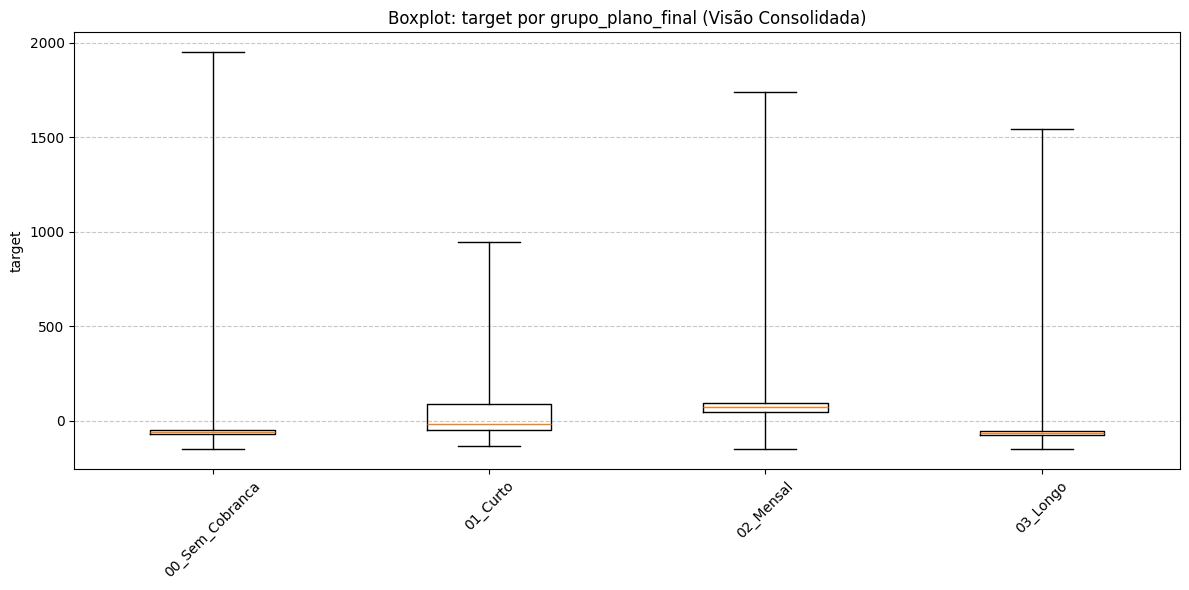


--- Estatísticas: grupo_plano_final (Visão Consolidada) ---


grupo_plano_final         min         q1        med         q3          max
3   00_Sem_Cobranca -152.545200 -71.081910 -58.479486 -50.033419  1950.000000
2          01_Curto -133.591014 -50.690076 -20.688140  86.539581   945.658211
1         02_Mensal -152.545200  45.939913  73.072146  92.534515  1737.859653
0          03_Longo -152.545200 -77.973307 -65.152461 -57.391381  1541.641613

In [ ]:
plot_boxplot(df_base_trans, ["grupo_plano_final"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: grupo_plano_final...


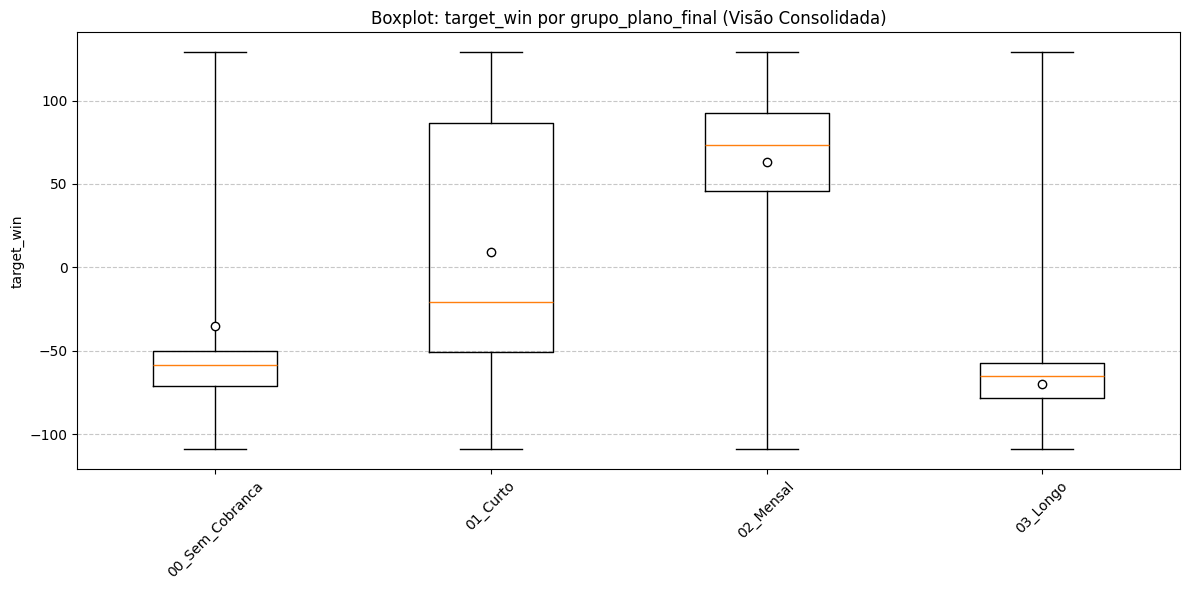


--- Estatísticas: grupo_plano_final (Visão Consolidada) ---


grupo_plano_final         min         q1        med       mean         q3  \
3   00_Sem_Cobranca -108.964925 -71.081910 -58.479486 -35.254039 -50.033419   
2          01_Curto -108.964925 -50.690076 -20.688140   9.456909  86.539581   
1         02_Mensal -108.964925  45.939913  73.072146  62.986019  92.534515   
0          03_Longo -108.964925 -77.973307 -65.152461 -69.579926 -57.391381   

          max  
3  128.953521  
2  128.953521  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["grupo_plano_final"], "target_win", agrupar_por_safra=False, table=True)

~80% da base tem plano mensal, uma flag aparenta ser melhor, mesmo que os casos longos tenha estatisticas bem distintas

In [ ]:
df_base_trans = df_base_trans.withColumn("flag_plano_mensal", F.when(F.col("payment_plan_days").isin(30, 31), 1).otherwise(0))

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_plano_mensal"], n_show=2)

+-----------------+-------+---------+
|flag_plano_mensal|total  |pct_total|
+-----------------+-------+---------+
|1                |8952852|79.63    |
|0                |2290013|20.37    |
+-----------------+-------+---------+



DataFrame[flag_plano_mensal: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_plano_mensal...


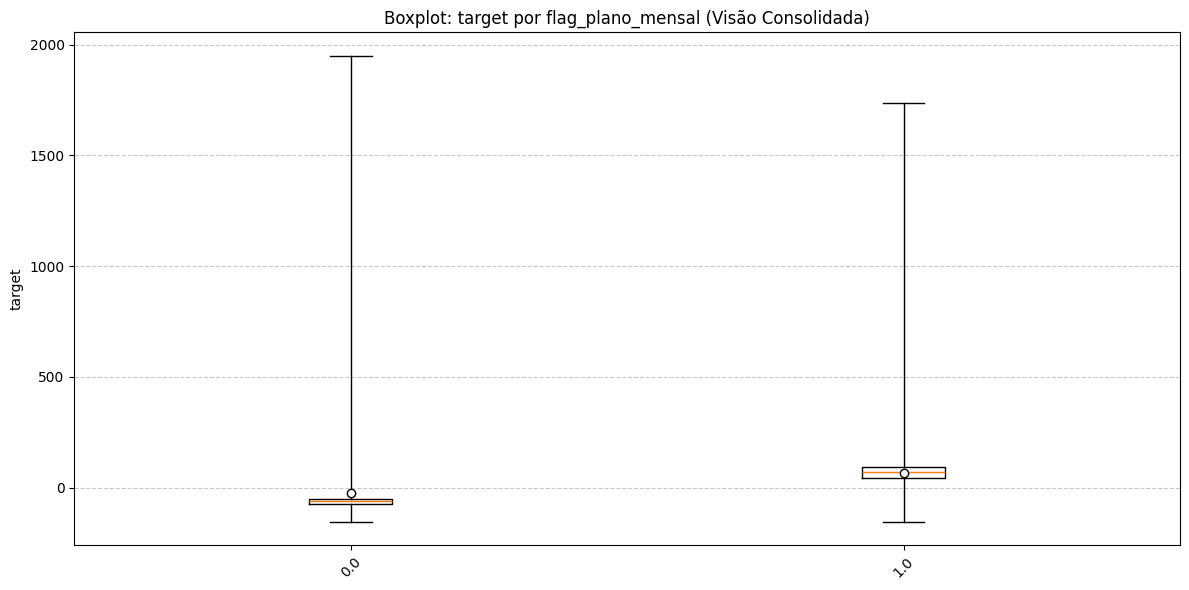


--- Estatísticas: flag_plano_mensal (Visão Consolidada) ---


flag_plano_mensal       min         q1        med       mean         q3  \
1                  0 -152.5452 -71.650163 -59.051857 -23.450302 -50.464816   
0                  1 -152.5452  45.939642  73.070747  64.387989  92.533925   

           max  
1  1950.000000  
0  1737.859653

In [ ]:
plot_boxplot(df_base_trans, ["flag_plano_mensal"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_plano_mensal...


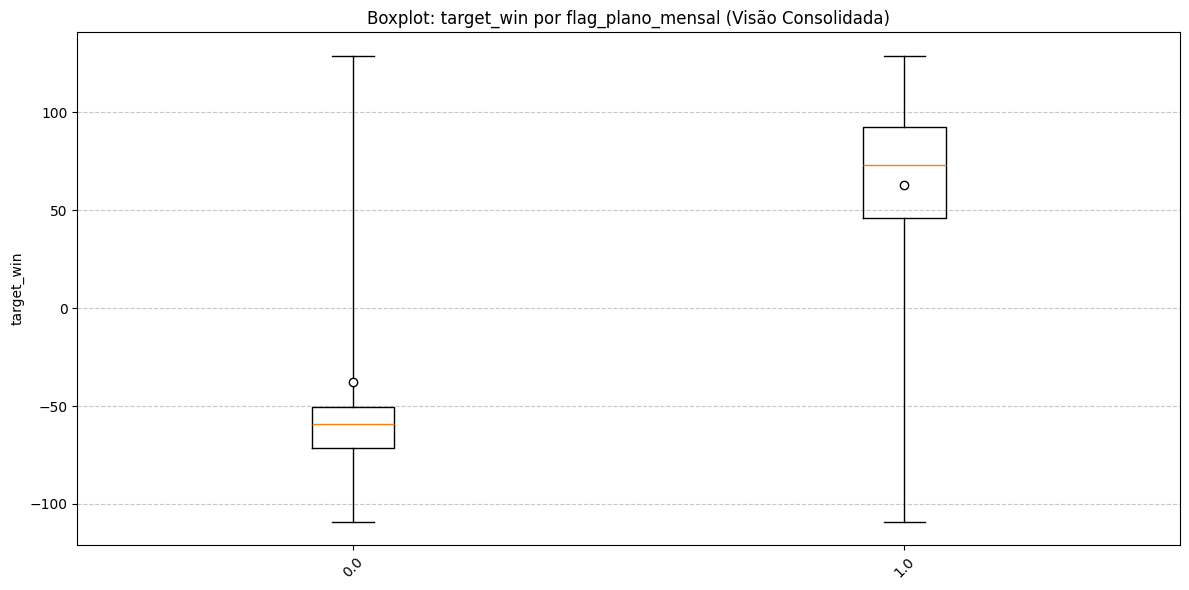


--- Estatísticas: flag_plano_mensal (Visão Consolidada) ---


flag_plano_mensal         min         q1        med       mean         q3  \
1                  0 -108.964925 -71.650163 -59.051857 -37.712949 -50.464816   
0                  1 -108.964925  45.939642  73.070747  62.981315  92.533925   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["flag_plano_mensal"], "target_win", agrupar_por_safra=False, table=True)

Interessante levar somente esta flag, pois substitui bem `grupo_plano_final`

Flag para usuarios longos (talvez nao precise, apenas para ver)

In [ ]:
df_base_trans = df_base_trans.withColumn("is_long_term_user", F.when(F.col("grupo_plano_final") == "03_Longo", 1).otherwise(0))

In [ ]:
calcular_distribuicao(df_base_trans, ["is_long_term_user"], n_show=2)

+-----------------+--------+---------+
|is_long_term_user|total   |pct_total|
+-----------------+--------+---------+
|0                |11116388|98.88    |
|1                |126477  |1.12     |
+-----------------+--------+---------+



DataFrame[is_long_term_user: int, total: bigint, pct_total: double]

Baixa volumetria, acaba ja entrando na `flag_plano_mensal`.

### 8.2.4. daily_revenue_efficiency

Quanto o cliente “gera de receita por dia contratado”

In [ ]:
df_base_trans = df_base_trans.withColumn("daily_revenue_efficiency",
        F.when(F.col("payment_plan_days") > 0, F.col("actual_amount_paid") / F.col("payment_plan_days")).otherwise(F.col("actual_amount_paid")))

#### Descritivas

In [ ]:
df_base_trans.select("daily_revenue_efficiency").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------------+
|summary|daily_revenue_efficiency|
+-------+------------------------+
|  count|                 9390483|
|   mean|      4.2956605469475555|
| stddev|      1.1862952262420043|
|    min|                     0.0|
|     1%|                     0.0|
|     5%|                     3.3|
|    25%|                     3.3|
|    50%|       4.966666666666667|
|    75%|       4.966666666666667|
|    95%|                     6.0|
|  99.5%|                     6.0|
|    max|                     6.0|
+-------+------------------------+



Distribuicao quase discreta, e nao continua, o que faz sentido, porque vimos que tem em esmagadora maioria planos padronizados.

In [ ]:
calcular_distribuicao(df_base_trans, ["daily_revenue_efficiency"])

+------------------------+-------+---------+
|daily_revenue_efficiency|total  |pct_total|
+------------------------+-------+---------+
|4.966666666666667       |5022656|44.67    |
|3.3                     |2705388|24.06    |
|NULL                    |1852382|16.48    |
|4.3                     |515454 |4.58     |
|6.0                     |482787 |4.29     |
|0.0                     |364000 |3.24     |
|5.0                     |144758 |1.29     |
|4.584615384615384       |45103  |0.4      |
|3.3333333333333335      |25959  |0.23     |
|2.977777777777778       |21550  |0.19     |
+------------------------+-------+---------+
only showing top 10 rows



DataFrame[daily_revenue_efficiency: double, total: bigint, pct_total: double]

In [ ]:
df_base_trans.select("daily_revenue_efficiency", "target").corr("daily_revenue_efficiency", "target")

0.398700573287757

In [ ]:
df_base_trans.select("daily_revenue_efficiency", "target_win").corr("daily_revenue_efficiency", "target_win")

0.5995192903605263

A variavel se mostra redundante com `flag_plano_mensal`. Parece uma categorica disfarcada. Apesar da alta correlação, é interessante atentar-se a possibilidade de _leakage_: apesar de eu suspeitar que não seja, mas o motivo de alta correção é ligado ao fato dessas variável estar diretamente ligada com o cálculo de margem líquida.

#### Agrupamento semântico

Agrupamento feito com base nos degraus de preço identificados no EDA.

In [ ]:
df_base_trans = df_base_trans.withColumn("revenue_tier",
    F.when(F.col("flag_has_transactions").isin(0), "00_unknown") # Sem transação
    .when(F.col("daily_revenue_efficiency") == 0, "01_free_isencao") # Isenções/vouchers
    .when(F.col("daily_revenue_efficiency") < 3.0, "02_low_tier") # Planos residuais/testes
    .when(F.col("daily_revenue_efficiency").between(3.0, 3.5), "03_standard_99") # Plano básico (R$ 99/mês)
    .when(F.col("daily_revenue_efficiency").between(4.5, 5.5), "04_premium_149") # Plano mais popular (R$ 149/mês)
    .when(F.col("daily_revenue_efficiency") > 5.5, "05_high_tier") # Planos premium (R$ 180+)
    .otherwise("06_others")) # Planos especiais/promocionais

In [ ]:
calcular_distribuicao(df_base_trans, ["revenue_tier"])

+---------------+-------+---------+
|revenue_tier   |total  |pct_total|
+---------------+-------+---------+
|04_premium_149 |5234015|46.55    |
|03_standard_99 |2736522|24.34    |
|00_unknown     |1852382|16.48    |
|06_others      |551535 |4.91     |
|05_high_tier   |482787 |4.29     |
|01_free_isencao|364000 |3.24     |
|02_low_tier    |21624  |0.19     |
+---------------+-------+---------+



DataFrame[revenue_tier: string, total: bigint, pct_total: double]

Processando estatísticas para: revenue_tier...


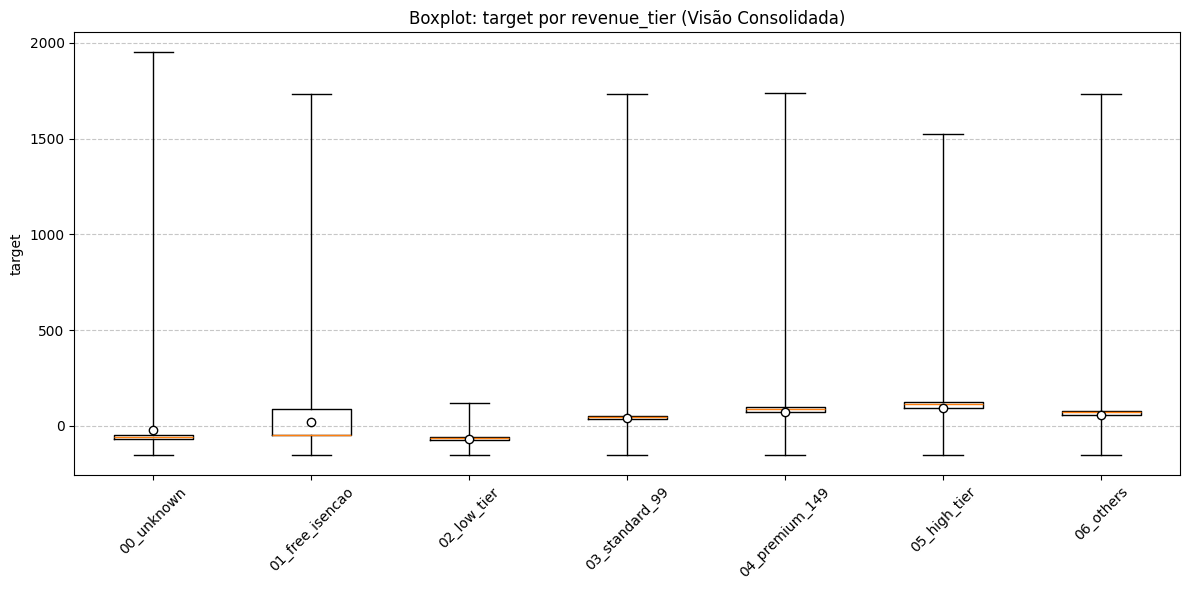


--- Estatísticas: revenue_tier (Visão Consolidada) ---


revenue_tier       min         q1         med       mean          q3  \
3       00_unknown -152.5452 -71.491939  -58.890695 -21.018945  -50.309033   
0  01_free_isencao -152.5452 -50.775706  -50.000000  21.177937   89.921758   
5      02_low_tier -152.5452 -76.106851  -64.322442 -70.277172  -57.319091   
4   03_standard_99 -152.5452  36.320474   45.179627  38.433489   48.806734   
1   04_premium_149 -152.5452  71.254999   87.453640  73.506382   95.572968   
6     05_high_tier -152.5452  94.755995  114.571004  94.853670  123.325999   
2        06_others -152.5452  55.900144   69.415306  57.061065   76.435115   

           max  
3  1950.000000  
0  1735.412335  
5   119.149782  
4  1731.843747  
1  1737.859653  
6  1521.663308  
2  1735.011429

In [ ]:
plot_boxplot(df_base_trans, ["revenue_tier"], "target", table=True)

Processando estatísticas para: revenue_tier...


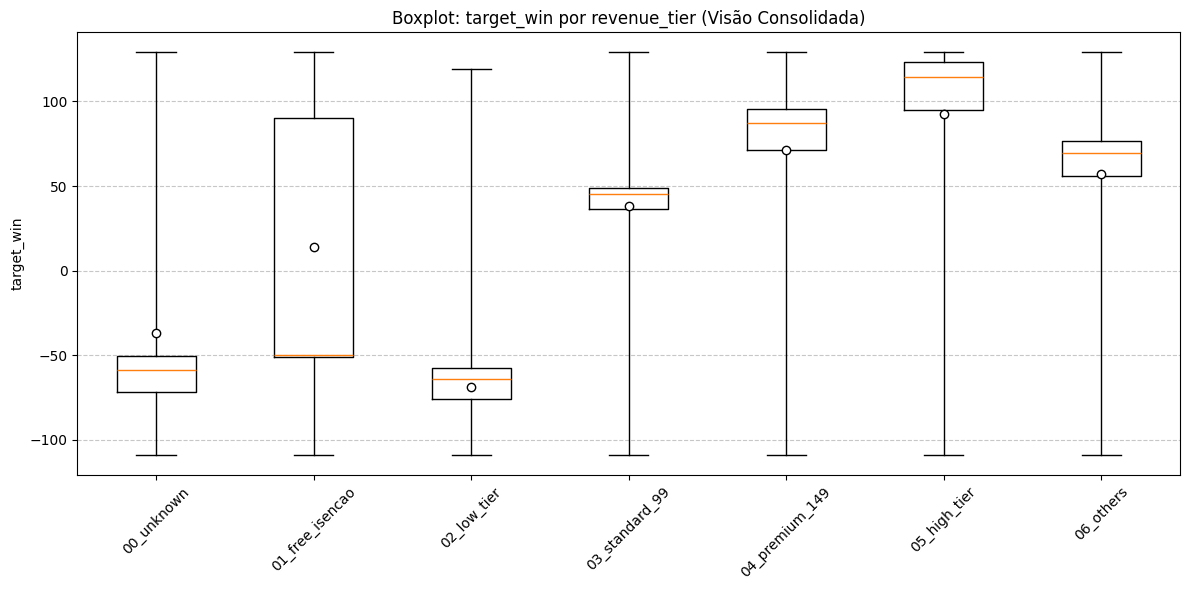


--- Estatísticas: revenue_tier (Visão Consolidada) ---


revenue_tier         min         q1         med       mean          q3  \
3       00_unknown -108.964925 -71.491939  -58.890695 -36.612835  -50.309033   
0  01_free_isencao -108.964925 -50.775706  -50.000000  13.872270   89.921758   
5      02_low_tier -108.964925 -76.106851  -64.322442 -69.046208  -57.319091   
4   03_standard_99 -108.964925  36.320474   45.179627  38.430922   48.806734   
1   04_premium_149 -108.964925  71.254999   87.453640  71.373278   95.572968   
6     05_high_tier -108.964925  94.755995  114.571004  92.362078  123.325999   
2        06_others -108.964925  55.900144   69.415306  57.013605   76.435115   

          max  
3  128.953521  
0  128.953521  
5  119.149782  
4  128.953521  
1  128.953521  
6  128.953521  
2  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["revenue_tier"], "target_win", table=True)

#### Conclusão

Levar. A variável `daily_revenue_efficiency` (receita diária normalizada) apresentou uma distribuição multimodal concentrada em "_price points_" específicos do negócio (R$3.30, R$4.97, R$ 6.00), refletindo a tabela de preços de planos de assinatura.
Para capturar o efeito não-linear da elasticidade de preço na margem líquida, criamos a variável categórica `revenue_tier`, que agrupa clientes em faixas de receita diária:

* 00_unknown: Sem transação
* 01_free_isencao: Isenções/_vouchers_
* 02_low_tier: Planos de baixo valor
* 03_standard_99: Plano básico (R$ 99/mês)
* 04_premium_149: Plano _premium_ (R$ 149/mês)
* 05_high_tier: Planos de alto valor
* 06_others: Planos especiais/promocionais

Estratégia por modelo:
* Elastic Net: Utiliza apenas `revenue_tier` (OHE) para evitar multicolinearidade e capturar não-linearidade.
* LightGBM/RF: Mantém ambas as variáveis, permitindo que o modelo escolha a melhor representação pela _feature importance_.

### 8.2.5. payment_method_id + is_auto_renew

#### 8.2.5.1. is_auto_renew

In [ ]:
calcular_distribuicao(df_base_trans, ["is_auto_renew"], n_show=3)

+-------------+-------+---------+
|is_auto_renew|total  |pct_total|
+-------------+-------+---------+
|1            |7863515|69.94    |
|NULL         |1852382|16.48    |
|0            |1526968|13.58    |
+-------------+-------+---------+



DataFrame[is_auto_renew: int, total: bigint, pct_total: double]

Processando estatísticas para: is_auto_renew...


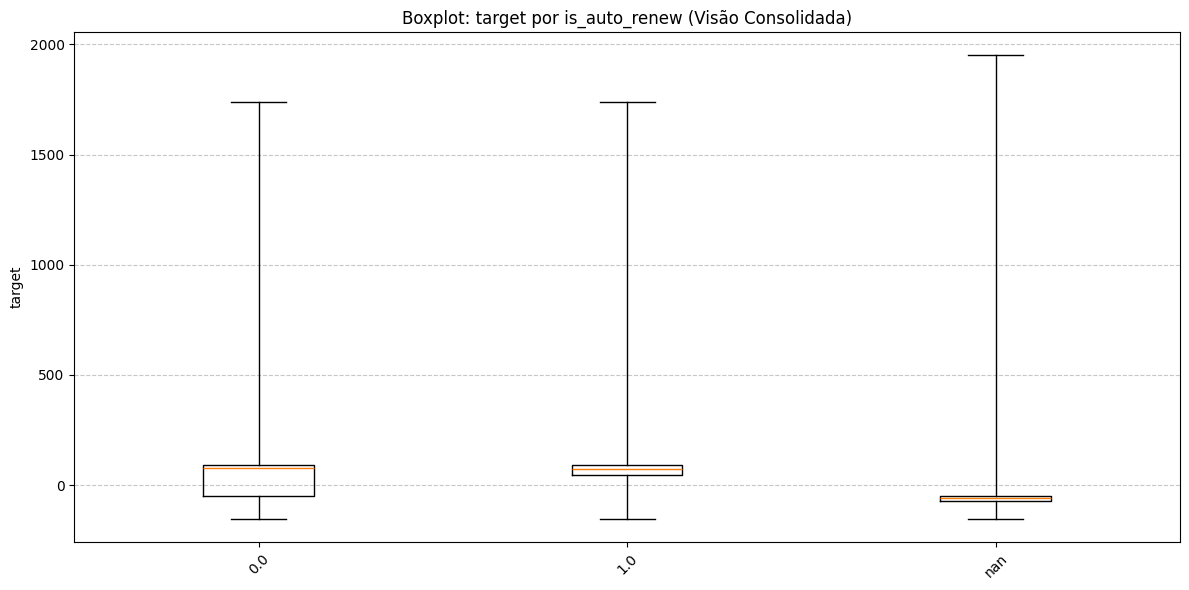


--- Estatísticas: is_auto_renew (Visão Consolidada) ---


is_auto_renew       min         q1        med         q3          max
2            0.0 -152.5452 -51.490648  76.731637  93.358386  1737.859653
1            1.0 -152.5452  45.941681  71.079558  92.169249  1737.041373
0            NaN -152.5452 -71.491939 -58.890695 -50.309033  1950.000000

In [ ]:
plot_boxplot(df_base_trans, ["is_auto_renew"], "target", agrupar_por_safra=False, table=True)

#### 8.2.5.2. payment_method_group

In [ ]:
df_payment_method_group = (
    df_base_trans
    .groupBy("payment_method_id")
    .agg(F.mean("is_auto_renew").alias("pct_auto_renew"))
    .withColumn("payment_method_group",
        F.when(F.col("pct_auto_renew").isNull(), "00_no_transactions")
         .when(F.col("pct_auto_renew") >= 0.90, "01_most_auto")
         .when(F.col("pct_auto_renew") >= 0.30, "02_mixed")
         .otherwise("03_most_manual"))
    .select("payment_method_id", "payment_method_group"))

df_base_trans = (
    df_base_trans
    .join(df_payment_method_group, "payment_method_id", "left"))

df_base_trans = df_base_trans.withColumn("payment_method_group", F.when(F.col("payment_method_group").isNull(), "00_no_transactions").otherwise(F.col("payment_method_group")))

In [ ]:
calcular_distribuicao(df_base_trans, ["payment_method_group"], n_show=5)

+--------------------+-------+---------+
|payment_method_group|total  |pct_total|
+--------------------+-------+---------+
|01_most_auto        |7629976|67.87    |
|00_no_transactions  |1852382|16.48    |
|03_most_manual      |1261339|11.22    |
|02_mixed            |499168 |4.44     |
+--------------------+-------+---------+



DataFrame[payment_method_group: string, total: bigint, pct_total: double]

Processando estatísticas para: payment_method_group...


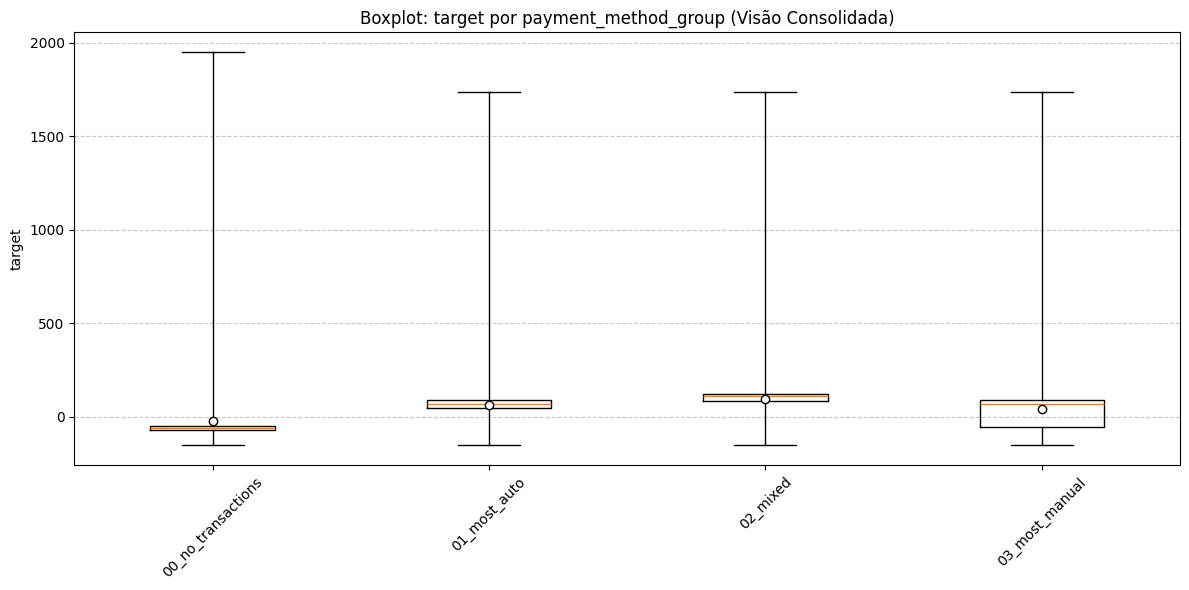


--- Estatísticas: payment_method_group (Visão Consolidada) ---


payment_method_group       min         q1         med       mean  \
0   00_no_transactions -152.5452 -71.492186  -58.890549 -21.018945   
2         01_most_auto -152.5452  45.637513   69.378596  62.808500   
3             02_mixed -152.5452  87.818467  111.897146  93.602949   
1       03_most_manual -152.5452 -53.371603   70.838180  41.530809   

           q3          max  
0  -50.308344  1950.000000  
2   91.288681  1737.041373  
3  122.573745  1737.859653  
1   88.995987  1736.987900

In [ ]:
plot_boxplot(df_base_trans, ["payment_method_group"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: payment_method_group...


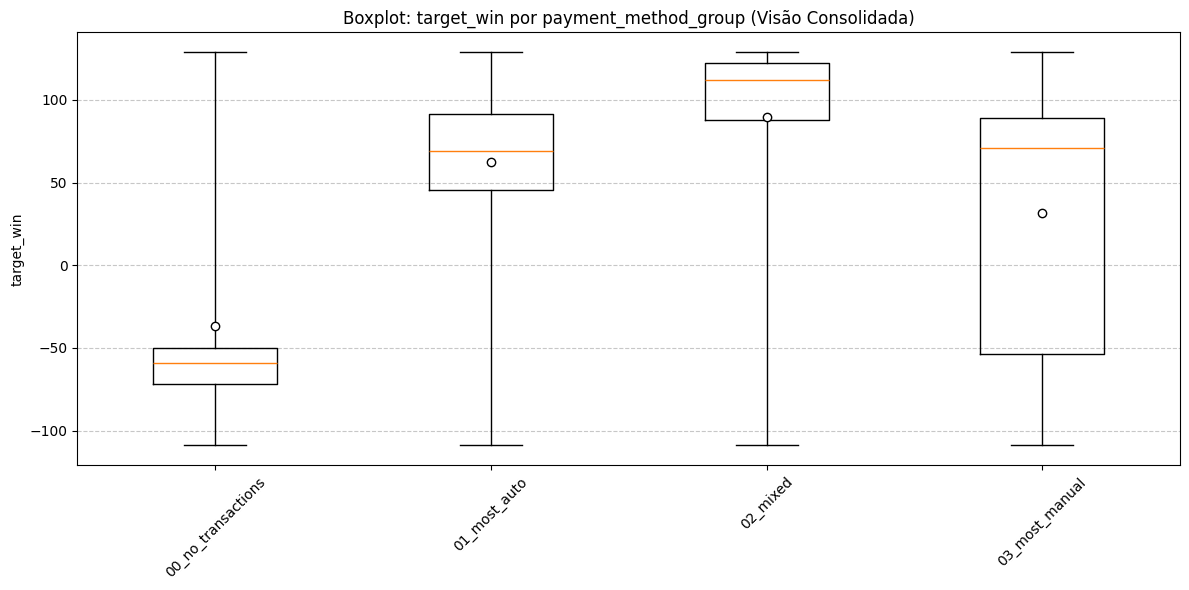


--- Estatísticas: payment_method_group (Visão Consolidada) ---


payment_method_group         min         q1         med       mean  \
0   00_no_transactions -108.964925 -71.492186  -58.890549 -36.612835   
2         01_most_auto -108.964925  45.637513   69.378596  62.608274   
3             02_mixed -108.964925  87.818467  111.897146  89.375366   
1       03_most_manual -108.964925 -53.371603   70.838180  31.897072   

           q3         max  
0  -50.308344  128.953521  
2   91.288681  128.953521  
3  122.573745  128.953521  
1   88.995987  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["payment_method_group"], "target_win", agrupar_por_safra=False, table=True)

**Conclusao**

Levar. A variavel `is_auto_renew` apresenta alta correlacao estrutural com `payment_method_id`, como visto na grafico da correlacao durante o EDA inicial, indicando redundancia informacional entre as duas. Apesar de `is_auto_renew` capturar o estado operacional no mes referencia, ela não representa um comportamento estrutural do cliente, variando conforme eventos pontuais.

Ja a variavel `payment_method_group`, por outro lado, sintetiza o comportamento historico do meio de pagamento, refletindo padroes persistentes de renovacao (auto, manual ou mista). Ao analisar junto da `target`, percebe-se que que o grupo 02_mixed apresenta mediana de margem futura superior as demais, comportamento que nao fica claramente distinguido por `is_auto_renew`.

Alem disso, a categoria 00_no_transactions isola de forma nitida clientes sem atividade financeira no mes, efeito altamente informativo que seria diluído ao utilizar apenas `is_auto_renew`.

### 8.2.6. diferenca entre pagamento e preco

#### versao continua

In [ ]:
# Razão entre pago e preço listado
df_base_trans = df_base_trans.withColumn("payment_price_ratio",
    F.when(F.col("plan_list_price") > 0, F.col("actual_amount_paid") / F.col("plan_list_price")))

In [ ]:
df_base_trans.select("payment_price_ratio").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+-------------------+
|summary|payment_price_ratio|
+-------+-------------------+
|  count|            9081504|
|   mean| 0.9938967180386512|
| stddev|0.07766425629635246|
|    min|                0.0|
|     1%|                1.0|
|     5%|                1.0|
|    25%|                1.0|
|    50%|                1.0|
|    75%|                1.0|
|    95%|                1.0|
|  99.5%|                1.0|
|    max|  1.007936507936508|
+-------+-------------------+



In [ ]:
calcular_distribuicao(df_base_trans, ["payment_price_ratio"])

+-------------------+-------+---------+
|payment_price_ratio|total  |pct_total|
+-------------------+-------+---------+
|1.0                |9024344|80.27    |
|NULL               |2161361|19.22    |
|0.0                |55022  |0.49     |
|0.8657718120805369 |1455   |0.01     |
|0.6644295302013423 |557    |0.0      |
|0.7986577181208053 |113    |0.0      |
|1.007936507936508  |7      |0.0      |
|0.9933333333333333 |3      |0.0      |
|0.9496644295302014 |1      |0.0      |
|0.9955257270693513 |1      |0.0      |
+-------------------+-------+---------+
only showing top 10 rows



DataFrame[payment_price_ratio: double, total: bigint, pct_total: double]

In [ ]:
df_base_trans.select("payment_price_ratio", "target").corr("payment_price_ratio", "target")

0.3564516665931757

Pela correlacao, conclui-se que aa variável carrega sinal, mas o sinal não vem da distribuicao contínua, e sim do regime (pagou / não pagou / não havia preço).

`payment_price_ratio` apresenta alta concentração em 1, com baixa variabilidade contínua. Apesar da correlacao ser moderada, nao significa que traz informacao nova e deve ser obrigatoriamente considerada. Modelos lineares vão tratar 0.95 vs 1 como diferença relevante (errado), arvores vao splitar em valores rarissimos e o efeito real (pagou vs não pagou) fica diluído.

#### versao categorica

In [ ]:
df_base_trans = df_base_trans.withColumn("payment_price_regime",
    F.when(F.col("plan_list_price").isNull(), "unknown")
    .when((F.col("plan_list_price") > 0) & (F.col("actual_amount_paid") == 0), "no_payment")
    .when((F.col("plan_list_price") > 0) & (F.col("actual_amount_paid") == F.col("plan_list_price")), "paid_as_expected")
    .when((F.col("plan_list_price") > 0) & (F.col("actual_amount_paid") > F.col("plan_list_price")), "overpay")
    .otherwise("other"))

In [ ]:
calcular_distribuicao(df_base_trans, ["payment_price_regime"], n_show=5)

+--------------------+-------+---------+
|payment_price_regime|total  |pct_total|
+--------------------+-------+---------+
|paid_as_expected    |9024344|80.27    |
|unknown             |1852382|16.48    |
|other               |311109 |2.77     |
|no_payment          |55022  |0.49     |
|overpay             |8      |0.0      |
+--------------------+-------+---------+



DataFrame[payment_price_regime: string, total: bigint, pct_total: double]

Processando estatísticas para: payment_price_regime...


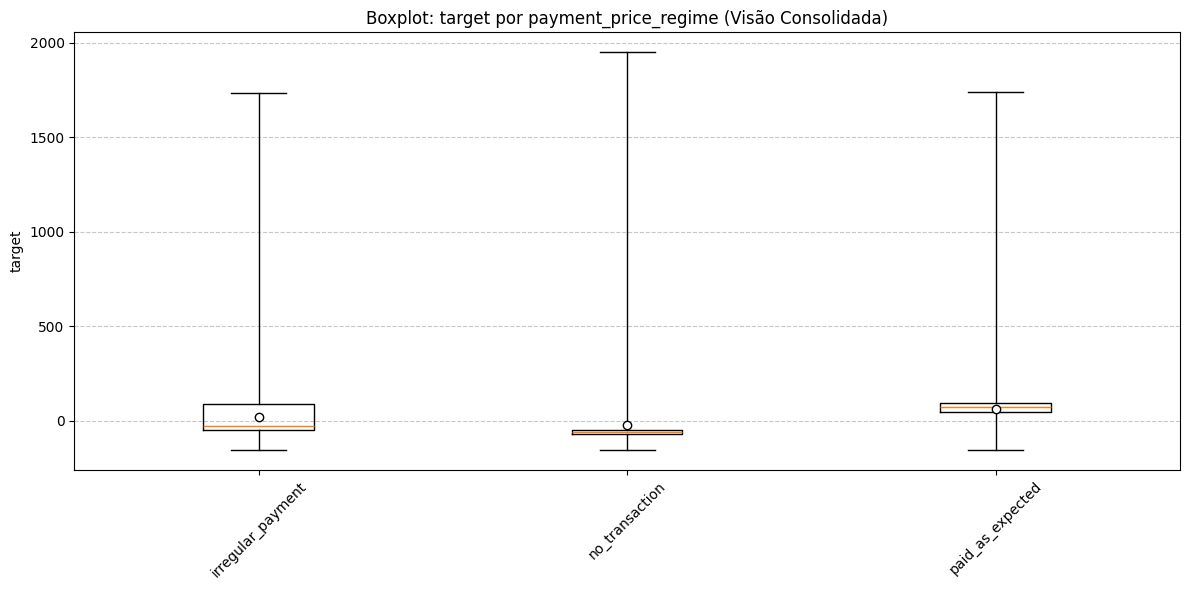


--- Estatísticas: payment_price_regime (Visão Consolidada) ---


payment_price_regime       min         q1        med       mean         q3  \
1    irregular_payment -152.5452 -50.701099 -24.933247  21.725562  89.644202   
2       no_transaction -152.5452 -71.491939 -58.890695 -21.018945 -50.309033   
0     paid_as_expected -152.5452  45.288213  72.160281  62.500997  92.343162   

           max  
1  1735.412335  
2  1950.000000  
0  1737.859653

In [ ]:
plot_boxplot(df_base_trans, ["payment_price_regime"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: payment_price_regime...


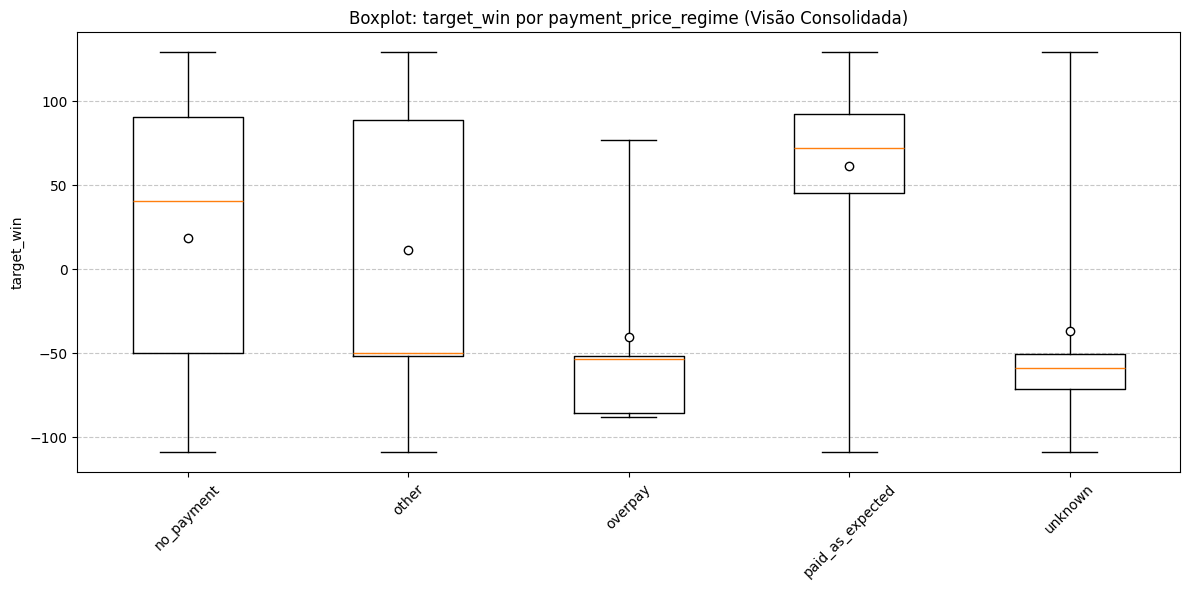


--- Estatísticas: payment_price_regime (Visão Consolidada) ---


payment_price_regime         min         q1        med       mean  \
4           no_payment -108.964925 -50.101257  40.593152  18.753815   
2                other -108.964925 -51.907176 -50.000000  11.370332   
0              overpay  -88.220061 -85.853643 -53.367111 -40.467399   
3     paid_as_expected -108.964925  45.288213  72.160281  61.135881   
1              unknown -108.964925 -71.491939 -58.890695 -36.612835   

          q3         max  
4  90.704765  128.953521  
2  88.472847  128.953521  
0 -51.896180   77.000000  
3  92.343162  128.953521  
1 -50.309033  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["payment_price_regime"], "target_win", agrupar_por_safra=False, table=True)

Apesar dos resultados, a variavel em questao conversa com outras flags ja construidas (como `flag_no_payment`, a qual foi descartada, e `flag_valid_fee`, que contempla distribuicao muito similar com a categoria paid_as_expected). Ela nao cria um novo eixo explicativo, apenas reforca um ja existente. Ela compensa para responder a pergunta: *“Esse usuário costuma pagar exatamente o que foi precificado?”*, portanto seu papel esta mais relacionado a refinamento comportamental, nao estrutura principal. Decisao: refinar um pouco mais sua construcao, ja que na etapa de feature selection sera definido se compensa ou nao ir para o modelo escolhido.

In [ ]:
df_base_trans = df_base_trans.withColumn("payment_price_regime",
    F.when((F.col("plan_list_price") > 0) & (F.col("actual_amount_paid") == F.col("plan_list_price")), "paid_as_expected")
    .when(F.col("plan_list_price").isNull(), "no_transaction")
    .otherwise("irregular_payment"))

In [ ]:
calcular_distribuicao(df_base_trans, ["payment_price_regime"], n_show=5)

+--------------------+-------+---------+
|payment_price_regime|total  |pct_total|
+--------------------+-------+---------+
|paid_as_expected    |9024344|80.27    |
|no_transaction      |1852382|16.48    |
|irregular_payment   |366139 |3.26     |
+--------------------+-------+---------+



DataFrame[payment_price_regime: string, total: bigint, pct_total: double]

Processando estatísticas para: payment_price_regime...


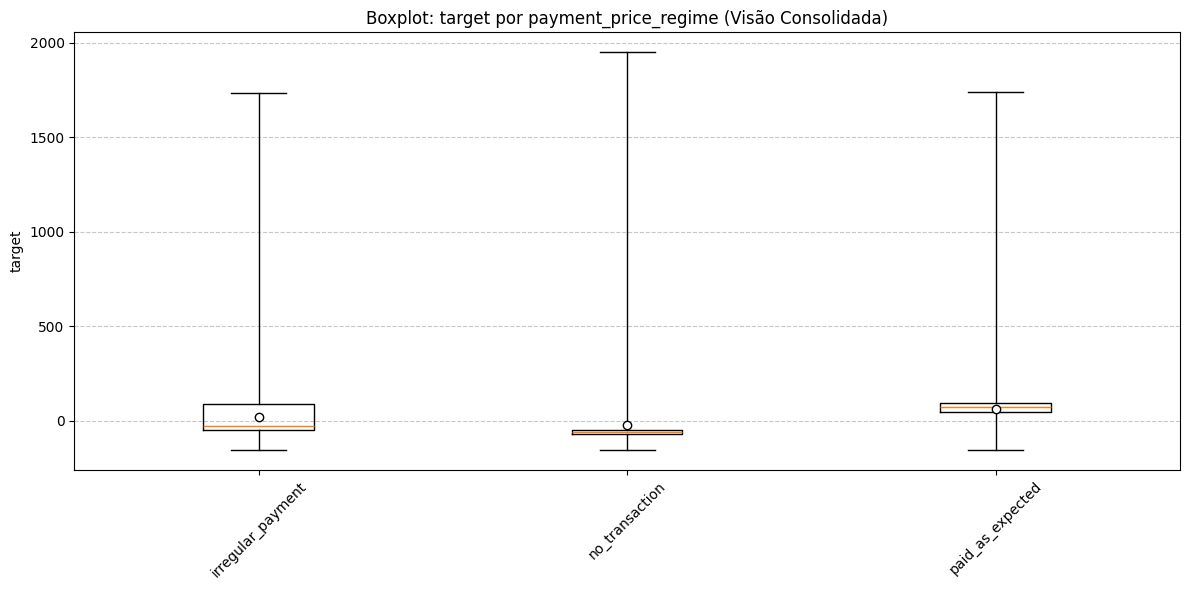


--- Estatísticas: payment_price_regime (Visão Consolidada) ---


payment_price_regime       min         q1        med       mean         q3  \
1    irregular_payment -152.5452 -50.701099 -24.933247  21.725562  89.644202   
2       no_transaction -152.5452 -71.491939 -58.890695 -21.018945 -50.309033   
0     paid_as_expected -152.5452  45.288213  72.160281  62.500997  92.343162   

           max  
1  1735.412335  
2  1950.000000  
0  1737.859653

In [ ]:
plot_boxplot(df_base_trans, ["payment_price_regime"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: payment_price_regime...


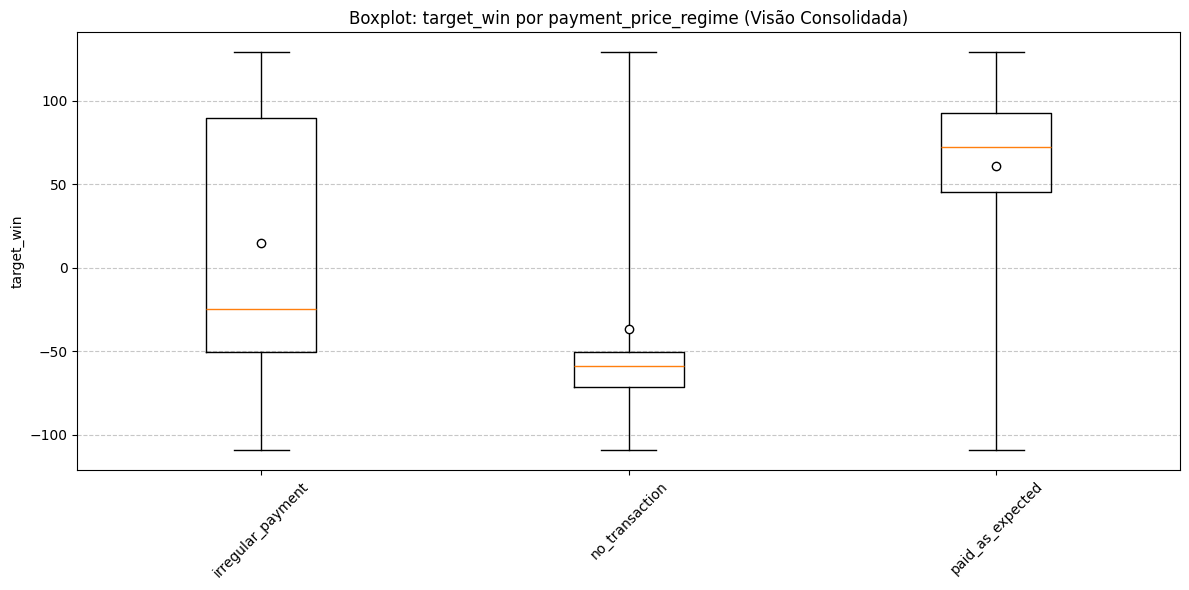


--- Estatísticas: payment_price_regime (Visão Consolidada) ---


payment_price_regime         min         q1        med       mean  \
1    irregular_payment -108.964925 -50.701099 -24.933247  14.533862   
2       no_transaction -108.964925 -71.491939 -58.890695 -36.612835   
0     paid_as_expected -108.964925  45.288213  72.160281  61.135881   

          q3         max  
1  89.644202  128.953521  
2 -50.309033  128.953521  
0  92.343162  128.953521

In [ ]:
plot_boxplot(df_base_trans, ["payment_price_regime"], "target_win", agrupar_por_safra=False, table=True)

### 8.2.7. expire date invalida

In [ ]:
calcular_distribuicao(df_base_trans, ["flag_expire_invalido"], n_show=3)

+--------------------+-------+---------+
|flag_expire_invalido|total  |pct_total|
+--------------------+-------+---------+
|0                   |9390439|83.52    |
|NULL                |1852382|16.48    |
|1                   |44     |0.0      |
+--------------------+-------+---------+



DataFrame[flag_expire_invalido: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_expire_invalido...


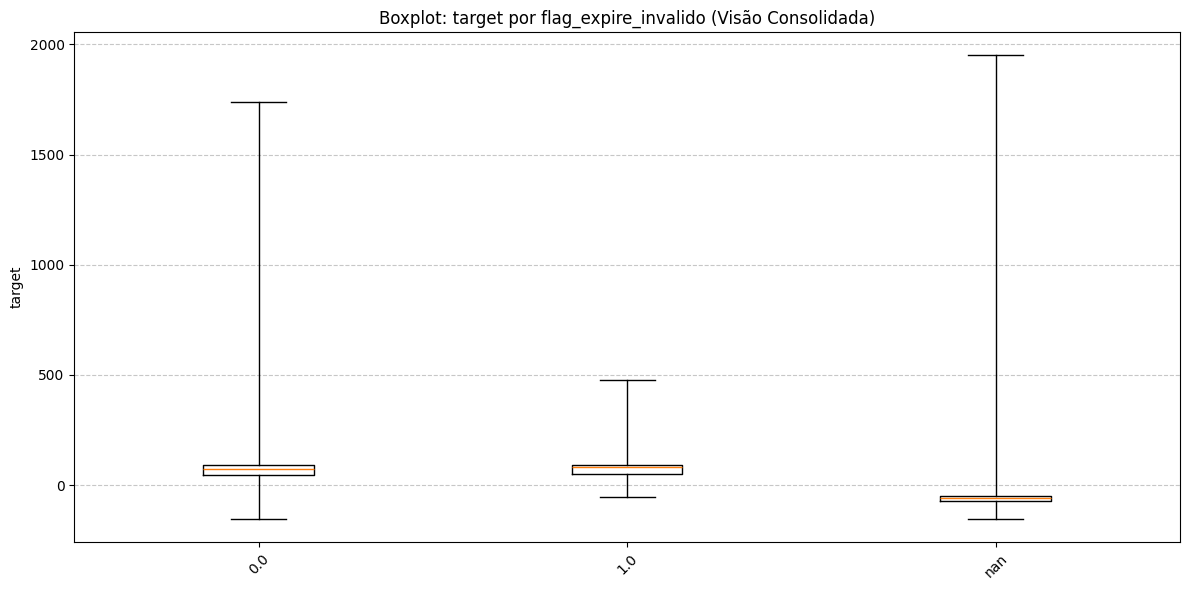


--- Estatísticas: flag_expire_invalido (Visão Consolidada) ---


flag_expire_invalido         min         q1        med         q3  \
2                   0.0 -152.545200  45.088921  71.993359  92.325581   
1                   1.0  -55.752099  52.318236  82.121130  90.683575   
0                   NaN -152.545200 -71.491939 -58.890695 -50.309033   

           max  
2  1737.859653  
1   476.451660  
0  1950.000000

In [ ]:
plot_boxplot(df_base_trans, ["flag_expire_invalido"], "target", agrupar_por_safra=False, table=True)

Olhando a `flag_expire_invalido`, construida para os casos em que a data do final da assinatura do cliente estava com valores estranhos, vi que faria mais sentido separar entre os casos em que existe data e casos em que nao (nao houve transacao). E ai reparei que acaba se tornando mais uma variavel que distingue quando nao ha transacao, pois todas as analises de `target` giram em torno das estatisticas com valores de -50, com excecao do maximo em 1950. Nao compensa, no final das contas, somente uma variavel que determina se tem ou nao tem transacao? O que pode se aplicar para logs, naturalmente.

## 8.3. Members

In [ ]:
members_vars = [
    "bd",
    "gender",
    "city",
    "registered_via",
    "registration_init_time",
    "idade_clean",
    "flag_idade_invalida",
    "gender_clean",
]

df_base_members = df_base.select("msno", "safra", "target", "target_win", *members_vars)

### 8.3.1. bd (idade)

In [ ]:
df_base_members = df_base_members.withColumn("faixa_idade",
    F.when(F.col("flag_idade_invalida") == 1, "Desconhecido")
        .when((F.col("idade_clean") >= 16) & (F.col("idade_clean") <= 22), "16-22")
        .when((F.col("idade_clean") >= 23) & (F.col("idade_clean") <= 34), "23-34")
        .when((F.col("idade_clean") >= 35) & (F.col("idade_clean") <= 44), "35-44")
        .when((F.col("idade_clean") >= 45) & (F.col("idade_clean") <= 52), "45-52")
        .otherwise("53+"))

In [ ]:
calcular_distribuicao(df_base_members, ["faixa_idade"], n_show=5)

+------------+-------+---------+
|faixa_idade |total  |pct_total|
+------------+-------+---------+
|Desconhecido|5478302|48.73    |
|23-34       |3192274|28.39    |
|16-22       |1118450|9.95     |
|35-44       |1020164|9.07     |
|45-52       |301403 |2.68     |
+------------+-------+---------+
only showing top 5 rows



DataFrame[faixa_idade: string, total: bigint, pct_total: double]

Processando estatísticas para: faixa_idade...


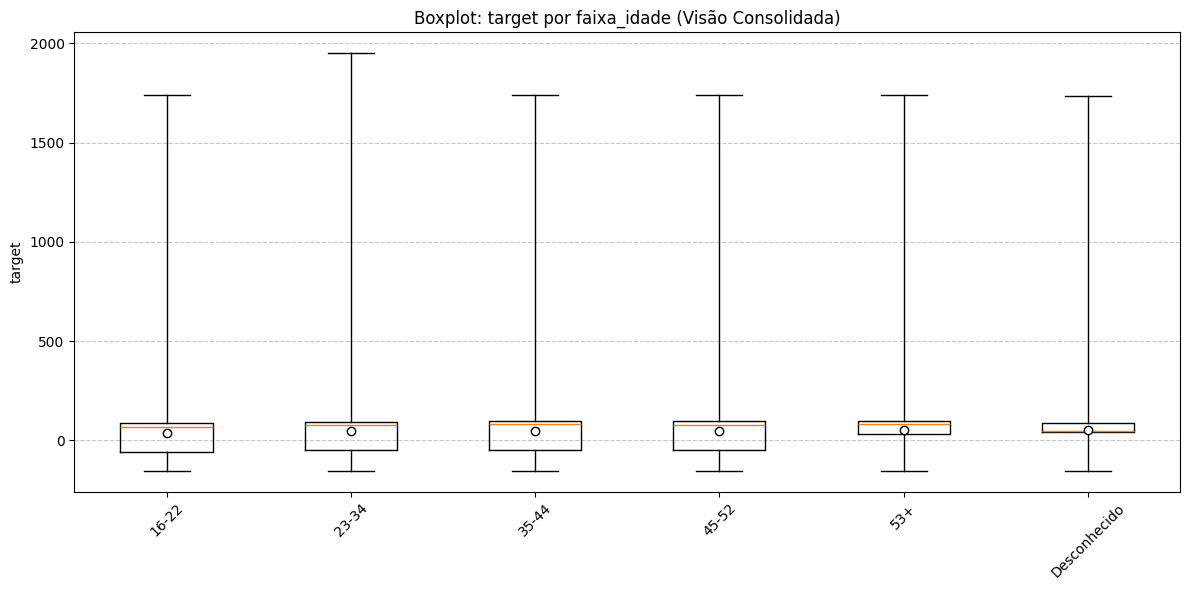


--- Estatísticas: faixa_idade (Visão Consolidada) ---


faixa_idade       min         q1        med       mean         q3  \
5         16-22 -152.5452 -56.433437  66.439765  38.842285  88.639285   
0         23-34 -152.5452 -50.146468  75.977863  46.142643  92.559926   
3         35-44 -152.5452 -50.000000  80.585296  47.606177  95.623010   
2         45-52 -152.5452 -50.000000  79.176308  47.673092  95.283569   
4           53+ -152.5452  32.142554  84.064988  54.183717  97.022703   
1  Desconhecido -152.5452  40.672108  49.000000  52.681467  86.293879   

           max  
5  1736.987900  
0  1950.000000  
3  1737.929378  
2  1737.947047  
4  1737.137480  
1  1736.347631

In [ ]:
plot_boxplot(df_base_members, ["faixa_idade"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: faixa_idade...


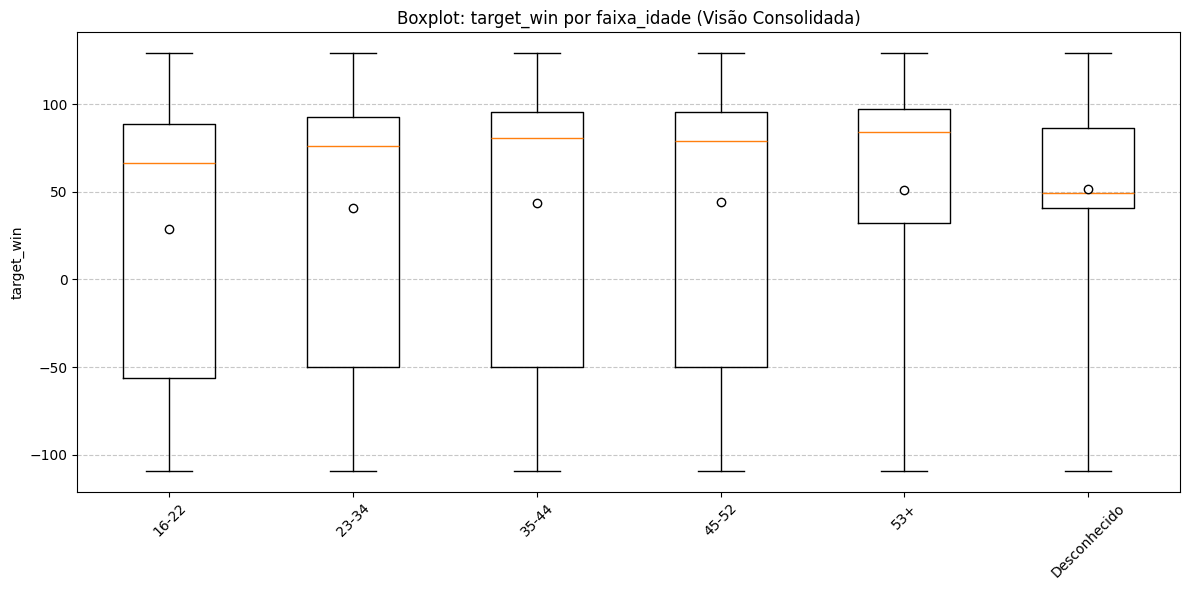


--- Estatísticas: faixa_idade (Visão Consolidada) ---


faixa_idade         min         q1        med       mean         q3  \
5         16-22 -108.964925 -56.433437  66.439765  29.026862  88.639285   
0         23-34 -108.964925 -50.146468  75.977863  40.767472  92.559926   
3         35-44 -108.964925 -50.000000  80.585296  43.565887  95.623010   
2         45-52 -108.964925 -50.000000  79.176308  43.912887  95.283569   
4           53+ -108.964925  32.142554  84.064988  51.082567  97.022703   
1  Desconhecido -108.964925  40.672108  49.000000  51.311194  86.293879   

          max  
5  128.953521  
0  128.953521  
3  128.953521  
2  128.953521  
4  128.953521  
1  128.953521

In [ ]:
plot_boxplot(df_base_members, ["faixa_idade"], "target_win", agrupar_por_safra=False, table=True)

Faixas 35-44 e 45-52 sao proximas. Mesmo pela volumetria, entendo que seja interessante juntar.

In [ ]:
df_base_members = df_base_members.withColumn("faixa_idade",
    F.when(F.col("flag_idade_invalida") == 1, "Desconhecido")
        .when((F.col("idade_clean") >= 16) & (F.col("idade_clean") <= 22), "16-22")
        .when((F.col("idade_clean") >= 23) & (F.col("idade_clean") <= 34), "23-34")
        .when((F.col("idade_clean") >= 35) & (F.col("idade_clean") <= 52), "35-52")
        .otherwise("53+"))

In [ ]:
calcular_distribuicao(df_base_members, ["faixa_idade"], n_show=5)

+------------+-------+---------+
|faixa_idade |total  |pct_total|
+------------+-------+---------+
|Desconhecido|5478302|48.73    |
|23-34       |3192274|28.39    |
|35-52       |1321567|11.75    |
|16-23       |1118450|9.95     |
|53+         |132272 |1.18     |
+------------+-------+---------+



DataFrame[faixa_idade: string, total: bigint, pct_total: double]

Processando estatísticas para: faixa_idade...


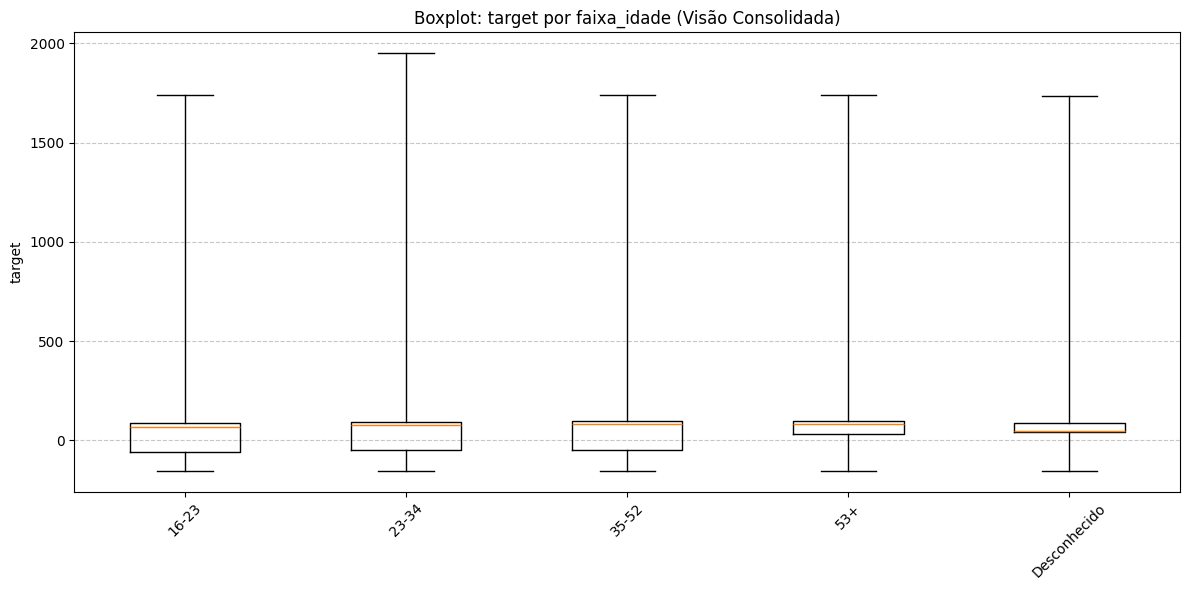


--- Estatísticas: faixa_idade (Visão Consolidada) ---


faixa_idade       min         q1        med         q3          max
1         16-23 -152.5452 -56.433437  66.439765  88.639285  1736.987900
0         23-34 -152.5452 -50.146468  75.977863  92.559926  1950.000000
4         35-52 -152.5452 -50.000000  80.246616  95.552088  1737.947047
3           53+ -152.5452  32.142554  84.064988  97.022703  1737.137480
2  Desconhecido -152.5452  40.672108  49.000000  86.293879  1736.347631

In [ ]:
plot_boxplot(df_base_members, ["faixa_idade"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: faixa_idade...


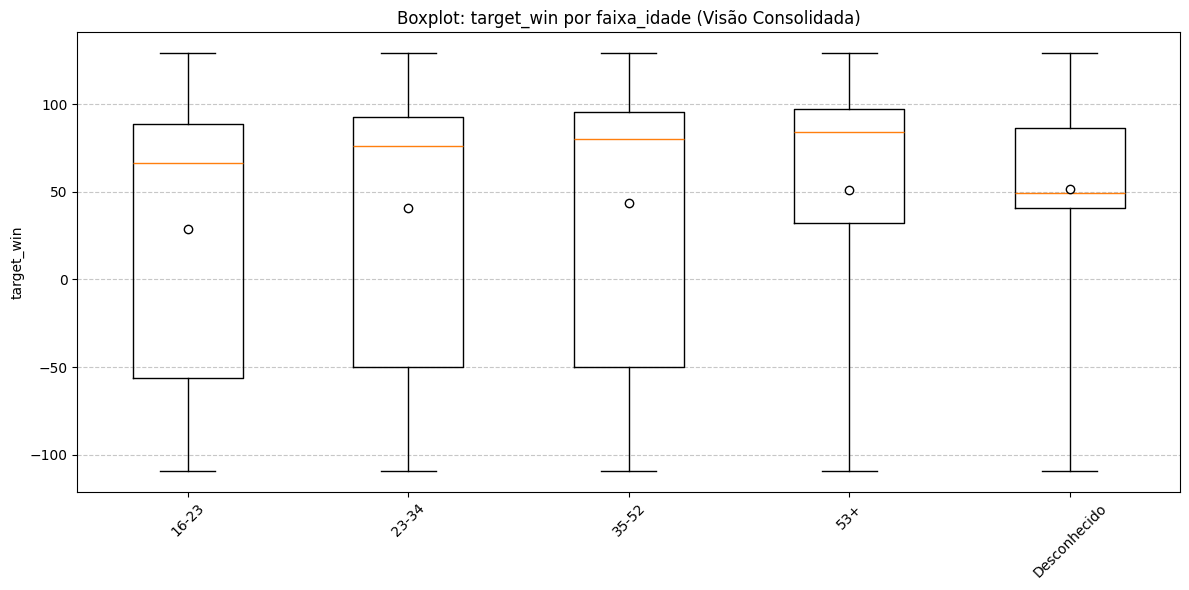


--- Estatísticas: faixa_idade (Visão Consolidada) ---


faixa_idade         min         q1        med       mean         q3  \
1         16-23 -108.964925 -56.433437  66.439765  29.026862  88.639285   
0         23-34 -108.964925 -50.146468  75.977863  40.767472  92.559926   
4         35-52 -108.964925 -50.000000  80.246616  43.645246  95.552088   
3           53+ -108.964925  32.142554  84.064988  51.082567  97.022703   
2  Desconhecido -108.964925  40.672108  49.000000  51.311194  86.293879   

          max  
1  128.953521  
0  128.953521  
4  128.953521  
3  128.953521  
2  128.953521

In [ ]:
plot_boxplot(df_base_members, ["faixa_idade"], "target_win", agrupar_por_safra=False, table=True)

Essa vai ser a versao final, considerando principalmente as medianas

### 8.3.2. city

In [ ]:
calcular_distribuicao(df_base_members, ["city"], n_show=25)

+----+-------+---------+
|city|total  |pct_total|
+----+-------+---------+
|1   |4986145|44.35    |
|13  |1481765|13.18    |
|5   |1097664|9.76     |
|4   |714795 |6.36     |
|15  |624620 |5.56     |
|22  |603971 |5.37     |
|6   |368930 |3.28     |
|14  |293125 |2.61     |
|12  |176023 |1.57     |
|9   |157790 |1.4      |
|11  |122816 |1.09     |
|8   |113924 |1.01     |
|18  |112453 |1.0      |
|10  |96482  |0.86     |
|21  |80295  |0.71     |
|3   |75874  |0.67     |
|17  |74709  |0.66     |
|7   |35673  |0.32     |
|16  |13862  |0.12     |
|20  |9965   |0.09     |
|19  |1984   |0.02     |
+----+-------+---------+



DataFrame[city: int, total: bigint, pct_total: double]

Processando estatísticas para: city...


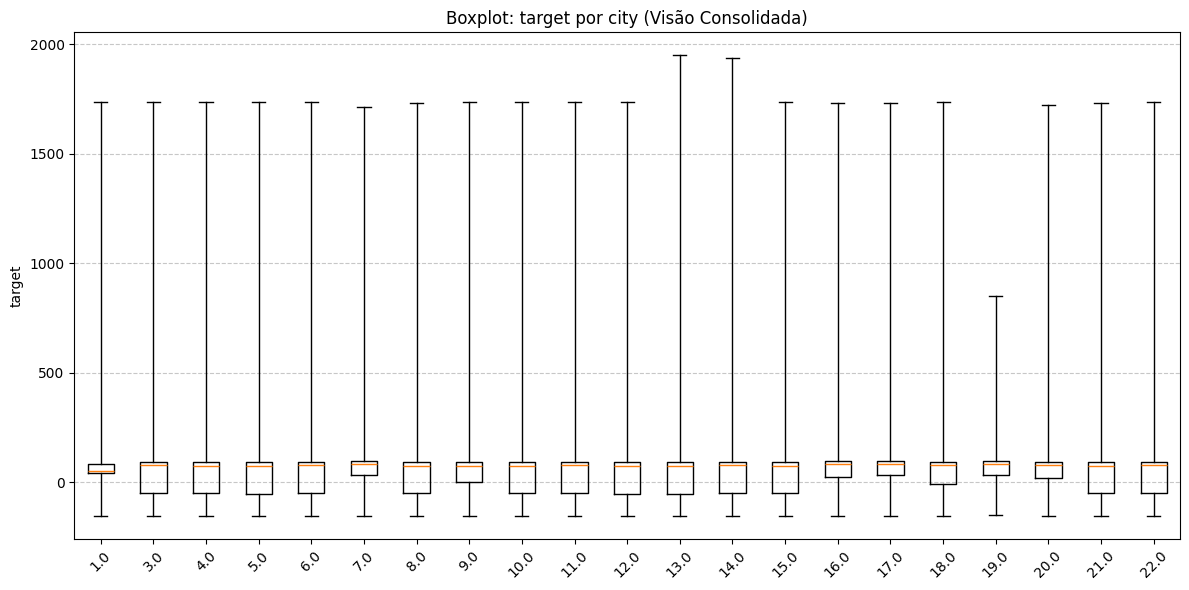

In [ ]:
plot_boxplot(df_base_members, ["city"], "target", agrupar_por_safra=False)

Estrutura de quatro niveis:

In [ ]:
df_base_members = df_base_members.withColumn("city_group",
    F.when(F.col("city").isin(1), "city_one")\
    .when(F.col("city").isin([13, 5, 4]), "top_cities")\
    .when(F.col("city").isin([15, 22, 6, 14]), "mid_cities")\
    .otherwise("other_cities"))

In [ ]:
calcular_distribuicao(df_base_members, ["city_group"])

+------------+-------+---------+
|city_group  |total  |pct_total|
+------------+-------+---------+
|city_one    |4986145|44.35    |
|top_cities  |3294224|29.3     |
|mid_cities  |1890646|16.82    |
|other_cities|1071850|9.53     |
+------------+-------+---------+



DataFrame[city_group: string, total: bigint, pct_total: double]

Processando estatísticas para: city_group...


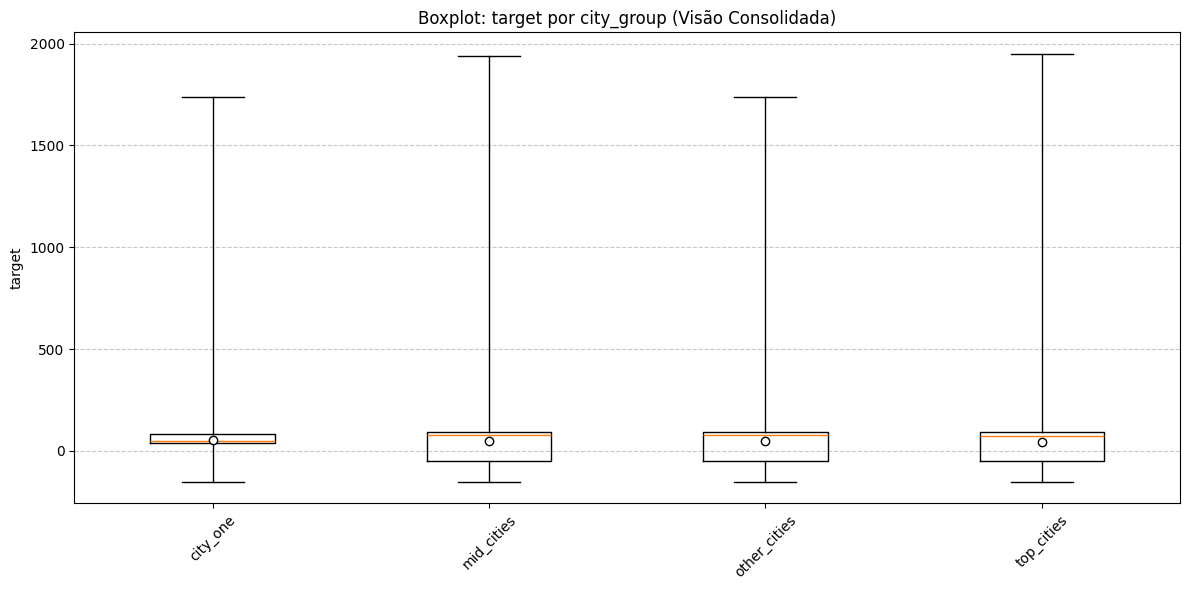


--- Estatísticas: city_group (Visão Consolidada) ---


city_group       min         q1        med       mean         q3  \
0      city_one -152.5452  41.113585  49.000000  53.290157  83.450254   
1    mid_cities -152.5452 -50.368506  77.159952  46.341483  93.363502   
3  other_cities -152.5452 -50.000000  76.347676  47.298061  92.935213   
2    top_cities -152.5452 -51.705813  75.436377  44.295062  92.954920   

           max  
0  1736.130944  
1  1936.799455  
3  1737.640612  
2  1950.000000

In [ ]:
plot_boxplot(df_base_members, ["city_group"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: city_group...


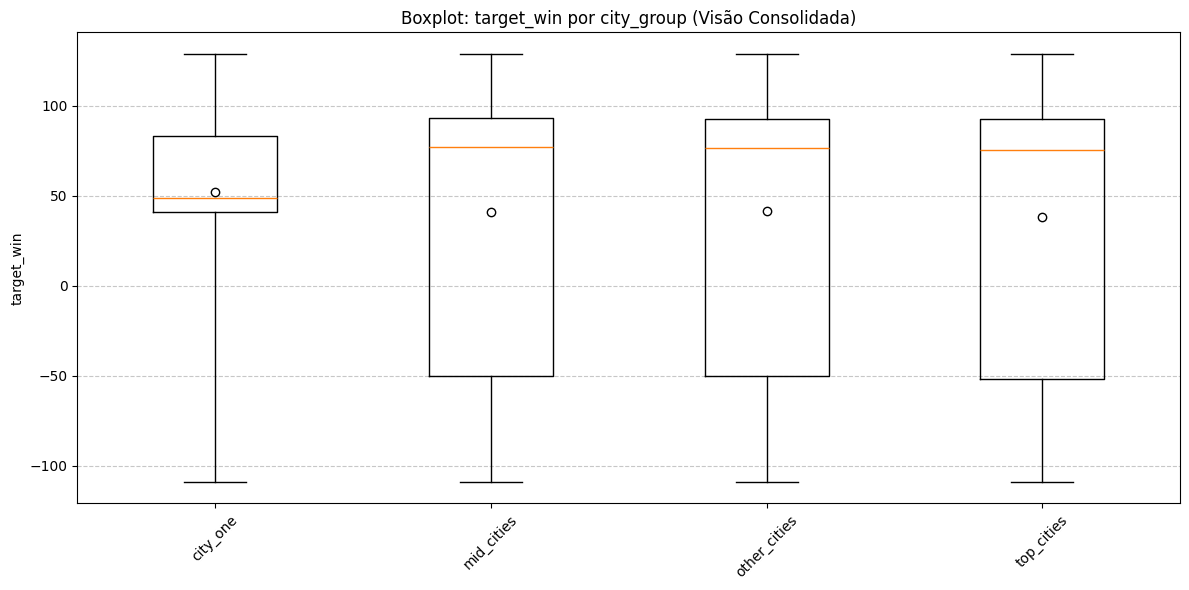


--- Estatísticas: city_group (Visão Consolidada) ---


city_group         min         q1        med       mean         q3  \
0      city_one -108.964925  41.113585  49.000000  52.174945  83.450254   
1    mid_cities -108.964925 -50.368506  77.159952  40.896772  93.363502   
3  other_cities -108.964925 -50.000000  76.347676  41.852474  92.935213   
2    top_cities -108.964925 -51.705813  75.436377  38.423098  92.954920   

          max  
0  128.953521  
1  128.953521  
3  128.953521  
2  128.953521

In [ ]:
plot_boxplot(df_base_members, ["city_group"], "target_win", agrupar_por_safra=False, table=True)

Boxplots muito similares para mid_cities, top_cities e other_cities. O agrupamento não cria poder discriminatório real. Ele só reorganiza categorias que já se comportam igual em termos de margem.

In [ ]:
df_base_members = df_base_members.withColumn("flag_city_one",F.when(F.col("city").isin(1), 1).otherwise(0))

In [ ]:
calcular_distribuicao(df_base_members, ["flag_city_one"])

+-------------+-------+---------+
|flag_city_one|total  |pct_total|
+-------------+-------+---------+
|0            |6256720|55.65    |
|1            |4986145|44.35    |
+-------------+-------+---------+



DataFrame[flag_city_one: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_city_one...


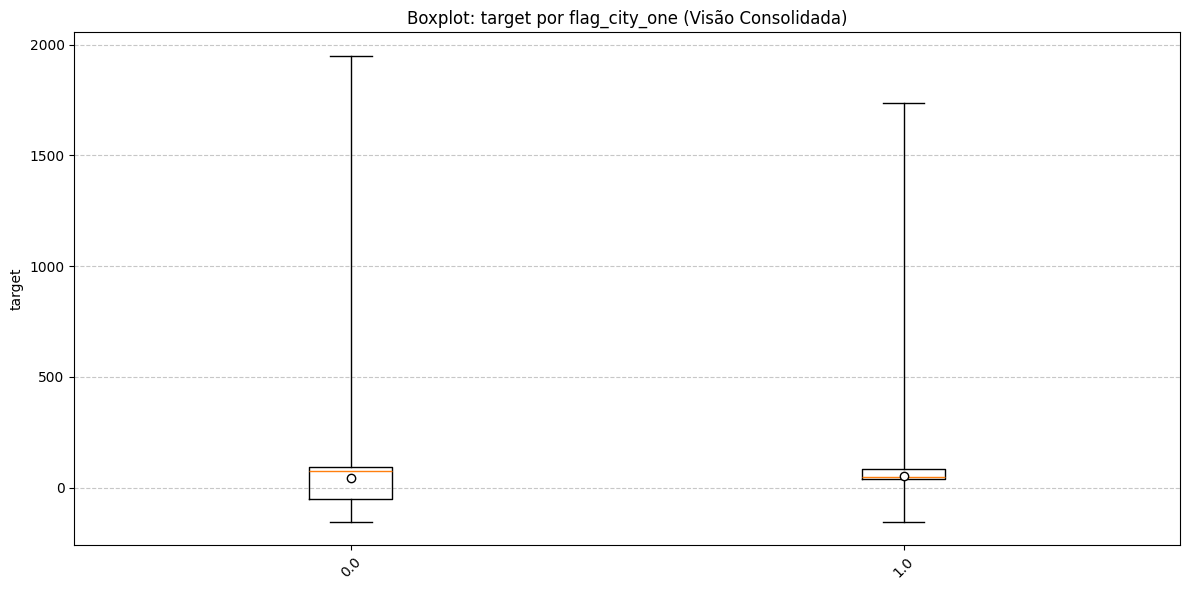


--- Estatísticas: flag_city_one (Visão Consolidada) ---


flag_city_one       min         q1       med       mean         q3  \
1              0 -152.5452 -50.876032  76.12281  45.423162  93.077254   
0              1 -152.5452  41.113585  49.00000  53.290157  83.450254   

           max  
1  1950.000000  
0  1736.130944

In [ ]:
plot_boxplot(df_base_members, ["flag_city_one"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_city_one...


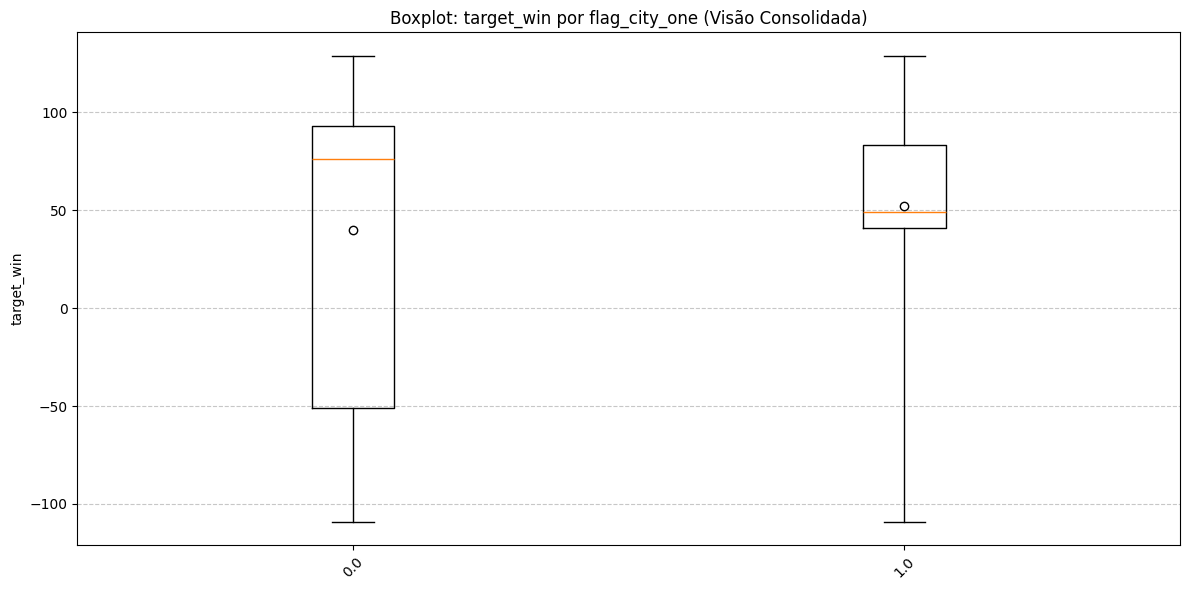


--- Estatísticas: flag_city_one (Visão Consolidada) ---


flag_city_one         min         q1       med       mean         q3  \
1              0 -108.964925 -50.876032  76.12281  39.752541  93.077254   
0              1 -108.964925  41.113585  49.00000  52.174945  83.450254   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_members, ["flag_city_one"], "target_win", agrupar_por_safra=False, table=True)

A análise mostrou que a distribuição da margem líquida mensal é praticamente idêntica entre a maioria das cidades, tanto no nível individual quanto em agrupamentos por frequência. A única exceção consistente é a cidade 1, que apresenta uma distribuição distinta em termos de mediana e dispersão.

Diante disso, optou-se por representar a variável cidade por uma flag binária (`flag_city_one`), capturando o único efeito geográfico relevante sem introduzir complexidade desnecessária ou ruído ao modelo.

### 8.3.3. gender

In [ ]:
calcular_distribuicao(df_base_members, ["gender_clean"])

+------------+-------+---------+
|gender_clean|total  |pct_total|
+------------+-------+---------+
|unknown     |5453964|48.51    |
|male        |3036611|27.01    |
|female      |2752290|24.48    |
+------------+-------+---------+



DataFrame[gender_clean: string, total: bigint, pct_total: double]

Processando estatísticas para: gender_clean...


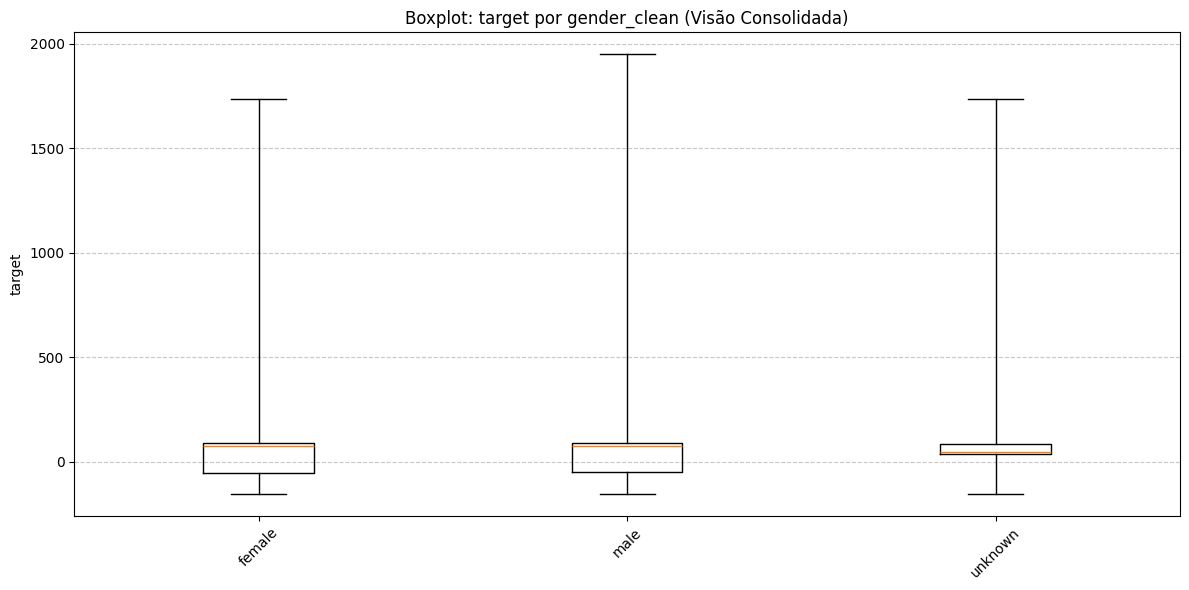


--- Estatísticas: gender_clean (Visão Consolidada) ---


gender_clean       min         q1        med         q3          max
1       female -152.5452 -51.160340  75.598110  93.097249  1737.859653
2         male -152.5452 -50.028441  75.850492  92.812681  1950.000000
0      unknown -152.5452  40.427550  49.000000  86.101611  1736.347631

In [ ]:
plot_boxplot(df_base_members, ["gender_clean"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: gender_clean...


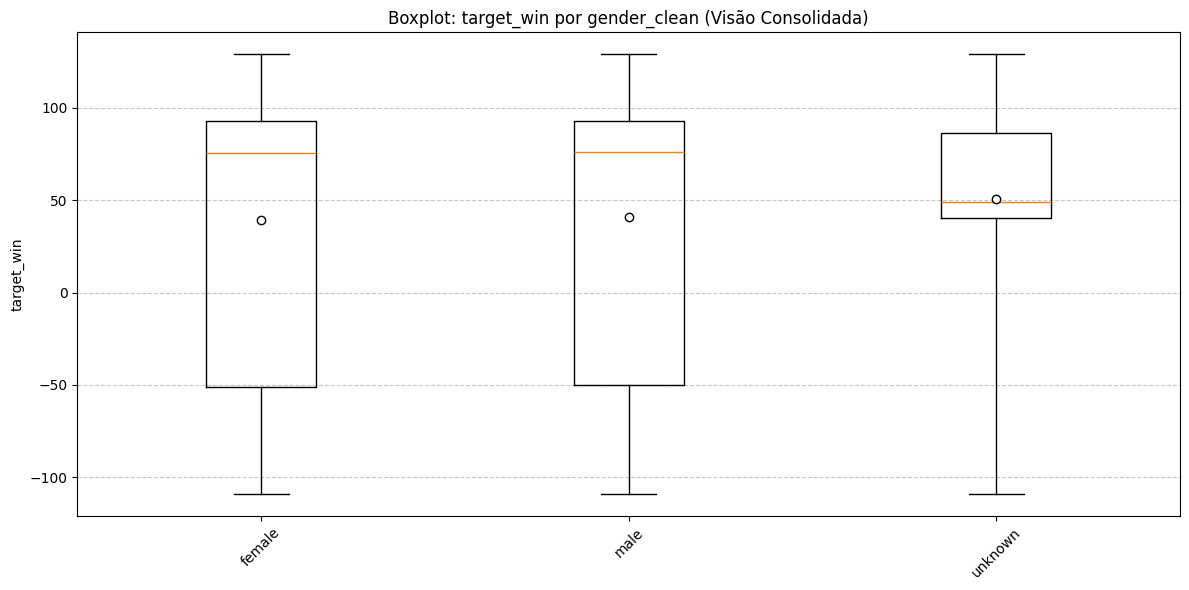


--- Estatísticas: gender_clean (Visão Consolidada) ---


gender_clean         min         q1        med       mean         q3  \
1       female -108.964925 -51.160340  75.598110  39.086724  93.097249   
2         male -108.964925 -50.028441  75.850492  40.842283  92.812681   
0      unknown -108.964925  40.427550  49.000000  50.752770  86.101611   

          max  
1  128.953521  
2  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_members, ["gender_clean"], "target_win", agrupar_por_safra=False, table=True)

Aparentemente, tambem faz mais sentido manter apenas uma flag para marcar se o genero esta registrado ou nao.

In [ ]:
df_base_members = df_base_members.withColumn("flag_gender_known", F.when(F.col("gender_clean") != "unknown", 1).otherwise(0))

Processando estatísticas para: flag_gender_known...


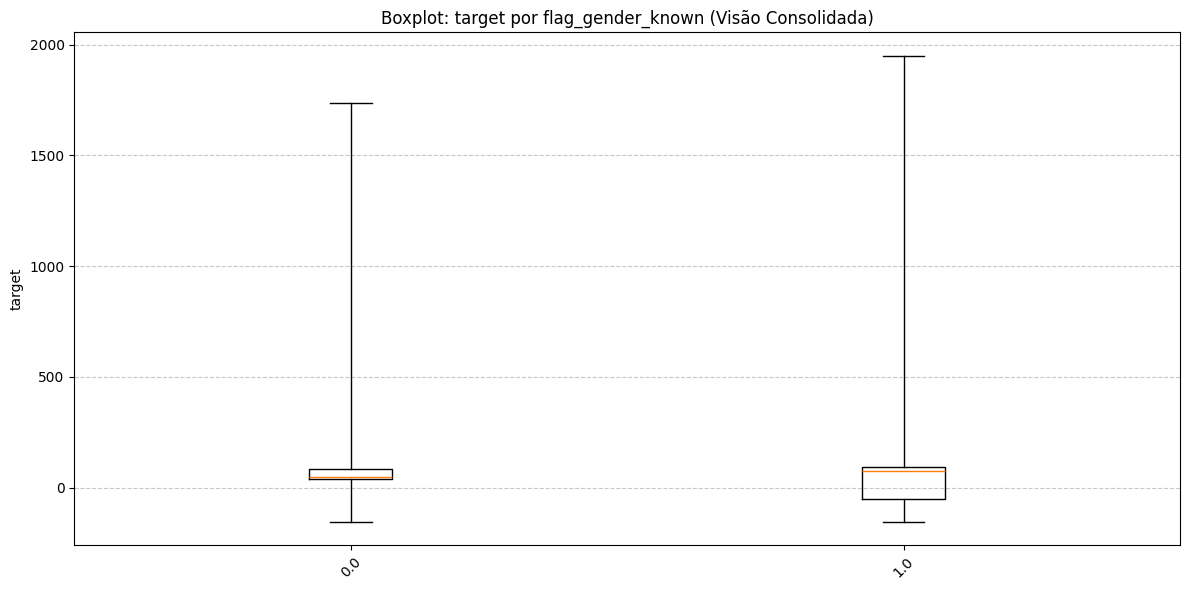


--- Estatísticas: flag_gender_known (Visão Consolidada) ---


flag_gender_known       min         q1        med         q3          max
1                  0 -152.5452  40.427550  49.000000  86.101611  1736.347631
0                  1 -152.5452 -50.519827  75.734401  92.949399  1950.000000

In [ ]:
plot_boxplot(df_base_members, ["flag_gender_known"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_gender_known...


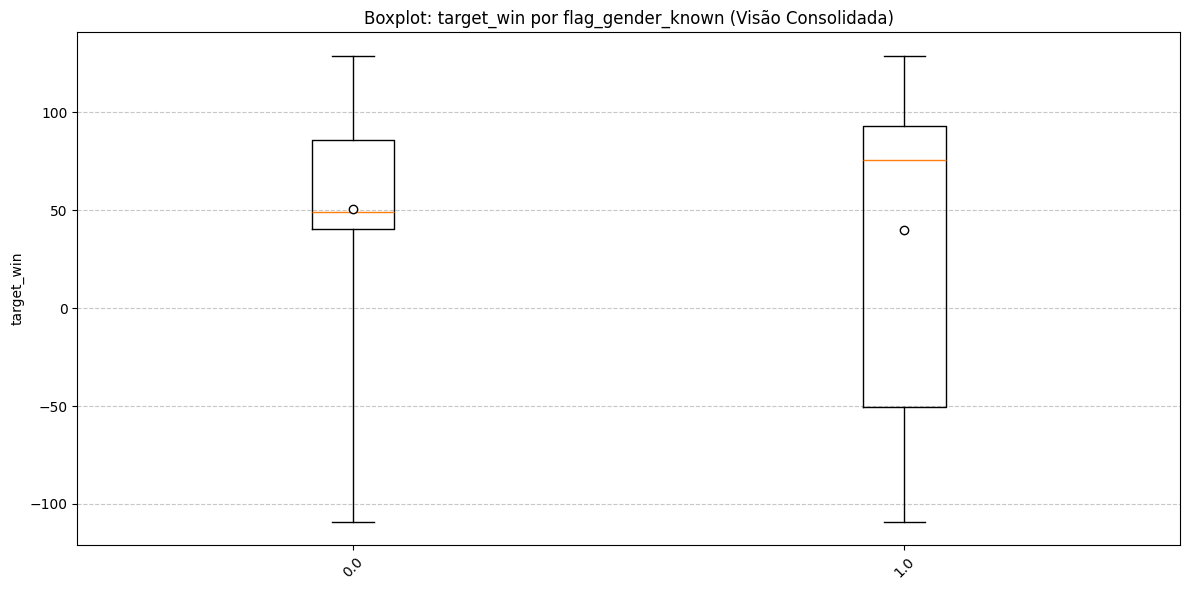


--- Estatísticas: flag_gender_known (Visão Consolidada) ---


flag_gender_known         min         q1        med       mean         q3  \
1                  0 -108.964925  40.427550  49.000000  50.752770  86.101611   
0                  1 -108.964925 -50.519827  75.734401  40.007911  92.949399   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_members, ["flag_gender_known"], "target_win", agrupar_por_safra=False, table=True)

### 8.3.4. registered_via

In [ ]:
calcular_distribuicao(df_base_members, ["registered_via"], n_show=25)

+--------------+-------+---------+
|registered_via|total  |pct_total|
+--------------+-------+---------+
|7             |5201676|46.27    |
|9             |3704733|32.95    |
|3             |1670379|14.86    |
|4             |658926 |5.86     |
|13            |7140   |0.06     |
|10            |10     |0.0      |
|16            |1      |0.0      |
+--------------+-------+---------+



DataFrame[registered_via: int, total: bigint, pct_total: double]

Processando estatísticas para: registered_via...


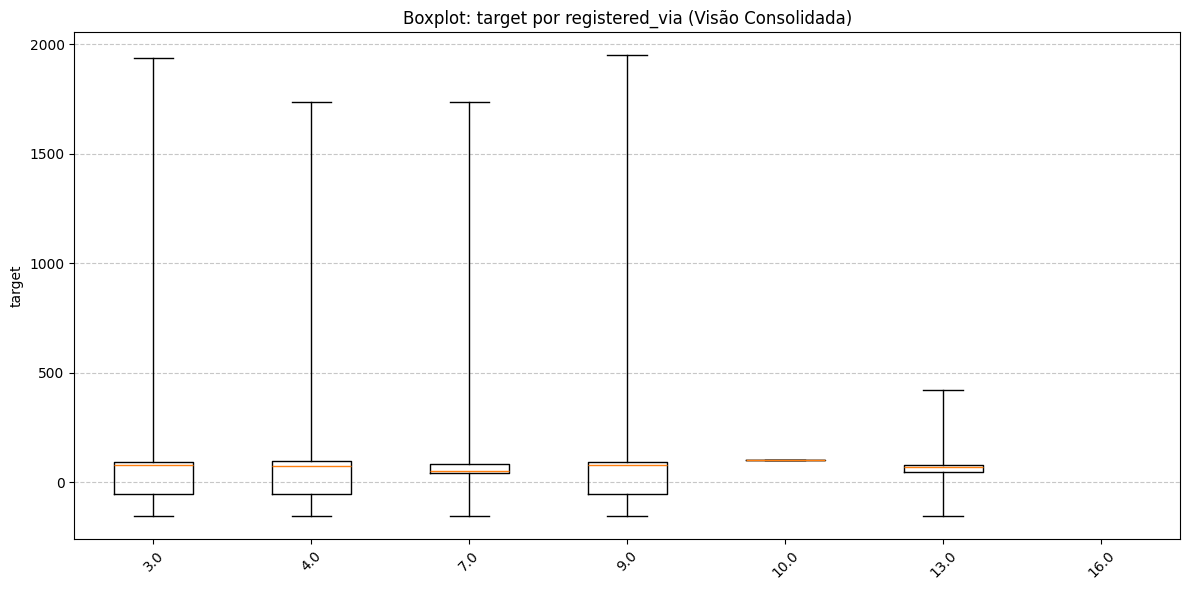


--- Estatísticas: registered_via (Visão Consolidada) ---


registered_via       min         q1        med         q3          max
1               3 -152.5452 -55.296765  76.197374  93.504638  1936.799455
4               4 -152.5452 -54.597162  76.029400  95.046895  1736.844913
5               7 -152.5452  41.489970  49.000000  81.934388  1736.522159
3               9 -152.5452 -52.670357  79.218606  94.035633  1950.000000
6              10   99.0000  99.000000  99.000000  99.000000    99.000000
0              13 -152.5452  44.402274  70.978867  79.000000   420.757018
2              16       NaN        NaN        NaN        NaN          NaN

In [ ]:
plot_boxplot(df_base_members, ["registered_via"], "target", agrupar_por_safra=False, table=True)

A variável `registered_via` representa o canal de aquisição do cliente.  
A análise exploratória mostrou que, embora existam diversos códigos possíveis, mais de 99% da base está concentrada em quatro valores (3, 4, 7 e 9), e que esses canais apresentam comportamentos distintos de margem líquida.

Com base na distribuição da margem e nas estatísticas descritivas, foi possível identificar regimes econômicos claros:

- **High Value (3 e 9)**  
  Medianas de margem mais altas e maior potencial de rentabilidade, indicando perfis mais engajados ou com maior propensão a conversão.

- **Low Value (7)**  
  Maior volume da base, porém mediana de margem inferior e menor upside, sugerindo aquisição mais massificada e menos rentável.

- **Mid Value (4)**  
  Comportamento intermediário, com métricas de margem entre os grupos de alto e baixo valor.

- **Other**  
  Canais com amostras muito pequenas, evitando ruído e risco de overfitting no modelo.

Essa categorização reduz dimensionalidade, melhora a interpretabilidade e captura diferenças estruturais de rentabilidade entre canais de aquisição, sendo adequada tanto para modelos lineares quanto para modelos baseados em árvores.

In [ ]:
df_base_members = df_base_members.withColumn("registered_via_group",
    F.when(F.col("registered_via").isin(3, 9), "high_value")
     .when(F.col("registered_via") == 7, "low_value")
     .when(F.col("registered_via") == 4, "mid_value")
     .otherwise("other"))

In [ ]:
calcular_distribuicao(df_base_members, ["registered_via_group"], n_show=25)

+--------------------+-------+---------+
|registered_via_group|total  |pct_total|
+--------------------+-------+---------+
|high_value          |5375112|47.81    |
|low_value           |5201676|46.27    |
|mid_value           |658926 |5.86     |
|other               |7151   |0.06     |
+--------------------+-------+---------+



DataFrame[registered_via_group: string, total: bigint, pct_total: double]

Processando estatísticas para: registered_via_group...


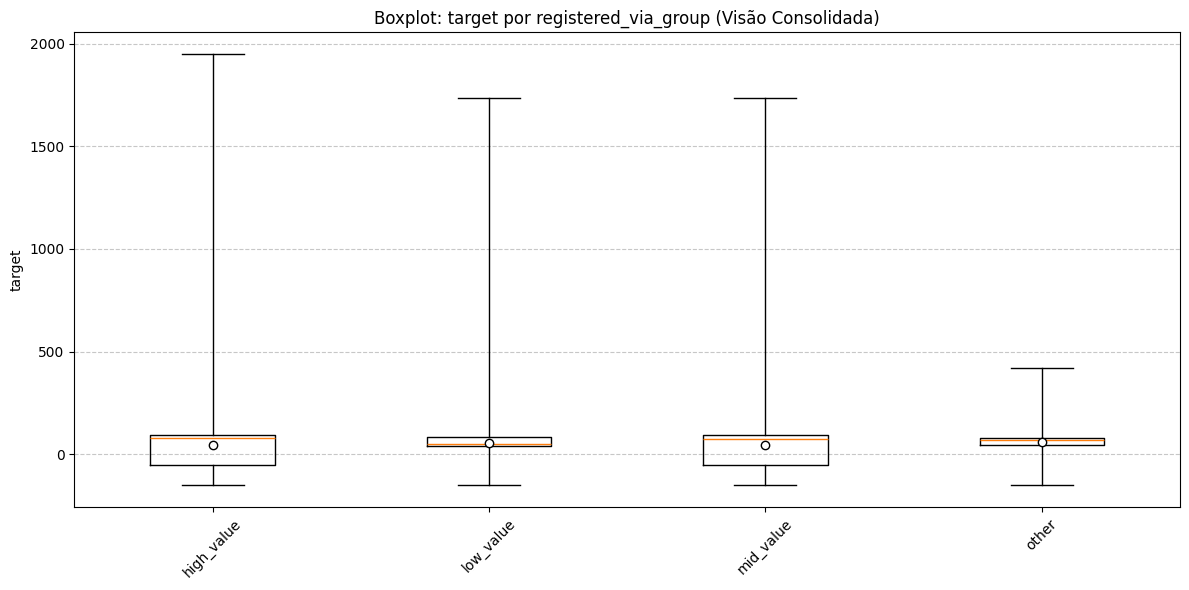


--- Estatísticas: registered_via_group (Visão Consolidada) ---


registered_via_group       min         q1        med       mean         q3  \
1           high_value -152.5452 -53.510725  78.419145  44.075802  93.889577   
2            low_value -152.5452  41.489970  49.000000  54.219620  81.934388   
3            mid_value -152.5452 -54.597162  76.029400  42.434752  95.046895   
0                other -152.5452  44.438603  70.998755  58.878411  79.000000   

           max  
1  1950.000000  
2  1736.522159  
3  1736.844913  
0   420.757018

In [ ]:
plot_boxplot(df_base_members, ["registered_via_group"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: registered_via_group...


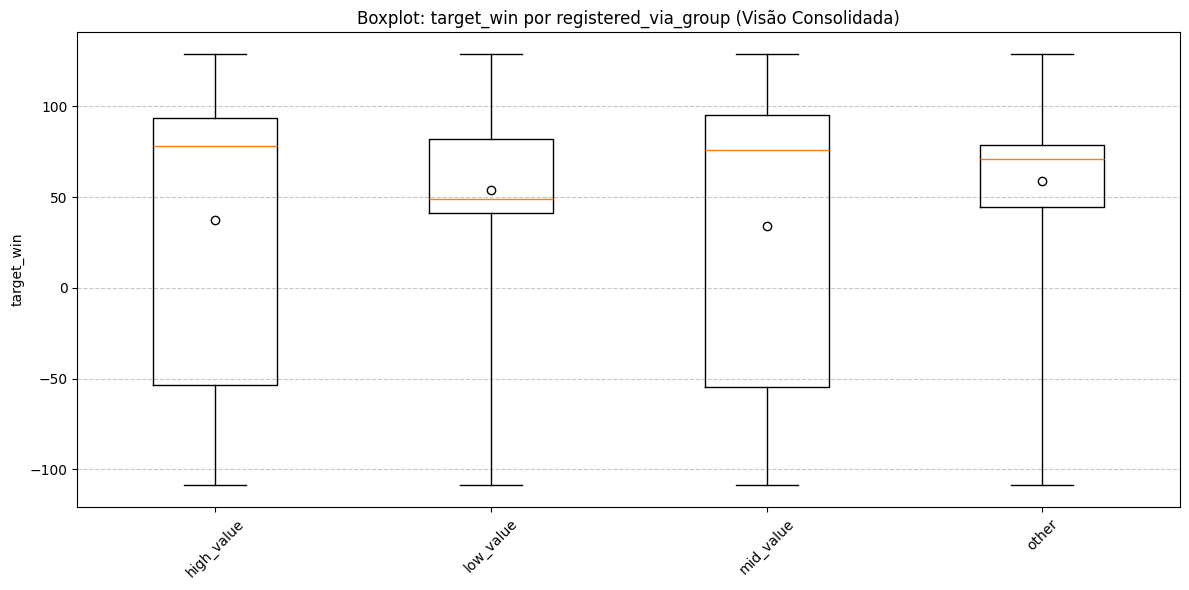


--- Estatísticas: registered_via_group (Visão Consolidada) ---


registered_via_group         min         q1        med       mean  \
1           high_value -108.964925 -53.510725  78.419145  37.471944   
2            low_value -108.964925  41.489970  49.000000  53.870472   
3            mid_value -108.964925 -54.597162  76.029400  34.232197   
0                other -108.964925  44.438603  70.998755  58.777226   

          q3         max  
1  93.889577  128.953521  
2  81.934388  128.953521  
3  95.046895  128.953521  
0  79.000000  128.953521

In [ ]:
plot_boxplot(df_base_members, ["registered_via_group"], "target_win", agrupar_por_safra=False, table=True)

Os valores de high_value e mid_value sao bem similares, talvez faca sentido uni-los.

In [ ]:
df_base_members = df_base_members.withColumn("registered_via_group",
    F.when(F.col("registered_via").isin([3, 9, 4]), "high_value")
    .when(F.col("registered_via").isin(7), "low_value")
    .otherwise("other"))

In [ ]:
calcular_distribuicao(df_base_members, ["registered_via_group"], n_show=25)

+--------------------+-------+---------+
|registered_via_group|total  |pct_total|
+--------------------+-------+---------+
|high_value          |6034038|53.67    |
|low_value           |5201676|46.27    |
|other               |7151   |0.06     |
+--------------------+-------+---------+



DataFrame[registered_via_group: string, total: bigint, pct_total: double]

Processando estatísticas para: registered_via_group...


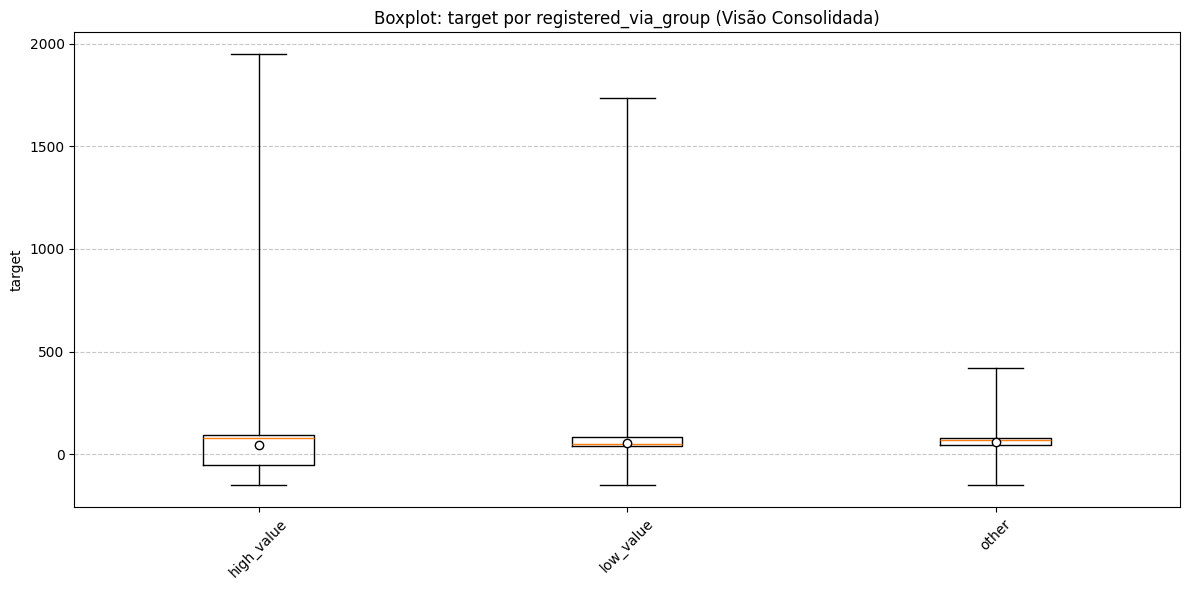


--- Estatísticas: registered_via_group (Visão Consolidada) ---


registered_via_group       min         q1        med       mean         q3  \
1           high_value -152.5452 -53.618059  78.259896  43.938683  93.967321   
2            low_value -152.5452  41.489970  49.000000  54.219620  81.934388   
0                other -152.5452  44.438603  70.998755  58.878411  79.000000   

           max  
1  1950.000000  
2  1736.522159  
0   420.757018

In [ ]:
plot_boxplot(df_base_members, ["registered_via_group"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: registered_via_group...


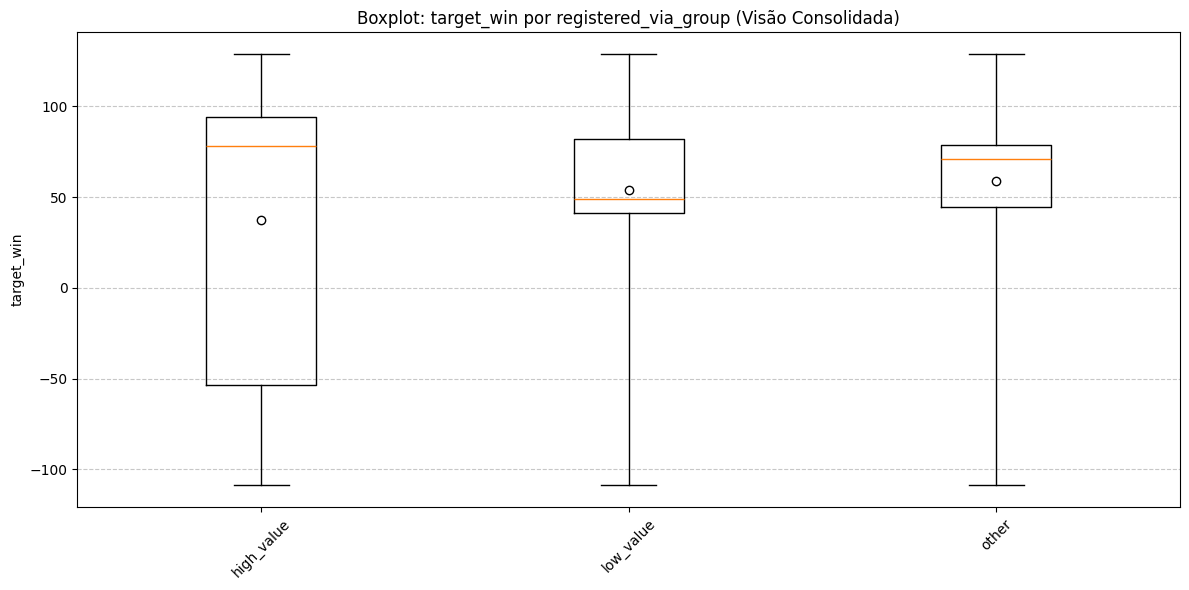


--- Estatísticas: registered_via_group (Visão Consolidada) ---


registered_via_group         min         q1        med       mean  \
1           high_value -108.964925 -53.618059  78.259896  37.201246   
2            low_value -108.964925  41.489970  49.000000  53.870472   
0                other -108.964925  44.438603  70.998755  58.777226   

          q3         max  
1  93.967321  128.953521  
2  81.934388  128.953521  
0  79.000000  128.953521

In [ ]:
plot_boxplot(df_base_members, ["registered_via_group"], "target_win", agrupar_por_safra=False, table=True)

Como a classe other tem volume irrisorio, uma alternativa mais robusta para regressao linear (ou pode ser que para a arvore tambem, veremos eventualmente) seria uma flag para os casos de high value (3, 9 e 4).

In [ ]:
df_base_members = df_base_members.withColumn("flag_high_value_registered_via", F.when(F.col("registered_via").isin([3, 9, 4]), 1).otherwise(0))

In [ ]:
calcular_distribuicao(df_base_members, ["flag_high_value_registered_via"], n_show=25)

+------------------------------+-------+---------+
|flag_high_value_registered_via|total  |pct_total|
+------------------------------+-------+---------+
|1                             |6034038|53.67    |
|0                             |5208827|46.33    |
+------------------------------+-------+---------+



DataFrame[flag_high_value_registered_via: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_high_value_registered_via...


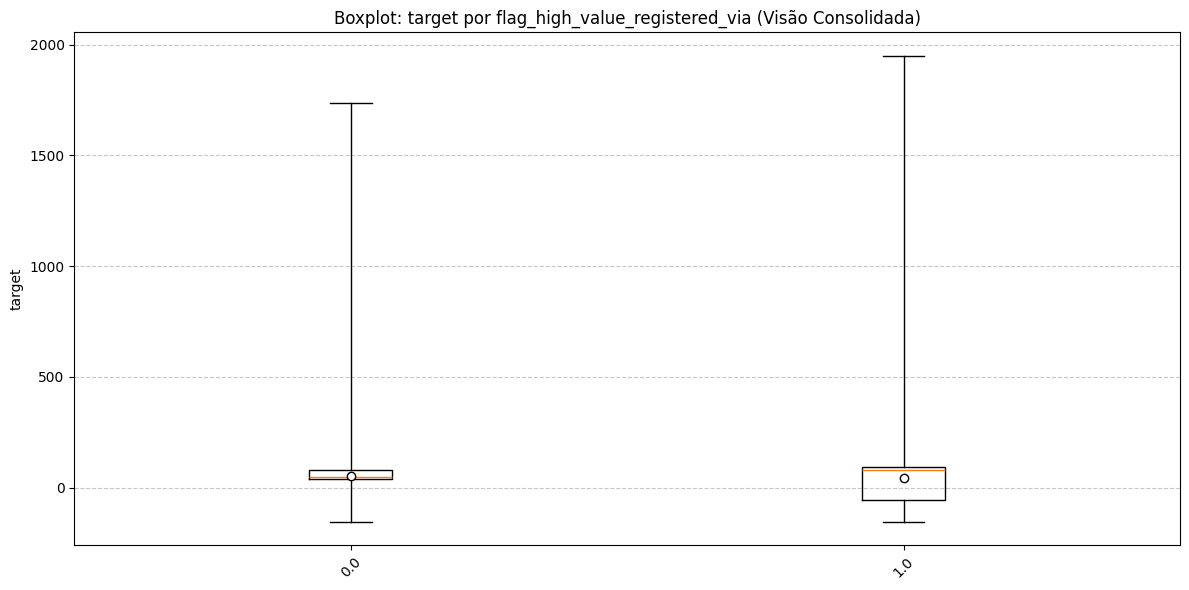


--- Estatísticas: flag_high_value_registered_via (Visão Consolidada) ---


flag_high_value_registered_via       min         q1        med       mean  \
1                               0 -152.5452  41.491442  49.000000  54.223868   
0                               1 -152.5452 -53.618059  78.259896  43.938683   

          q3          max  
1  81.930892  1736.522159  
0  93.967321  1950.000000

In [ ]:
plot_boxplot(df_base_members, ["flag_high_value_registered_via"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_high_value_registered_via...


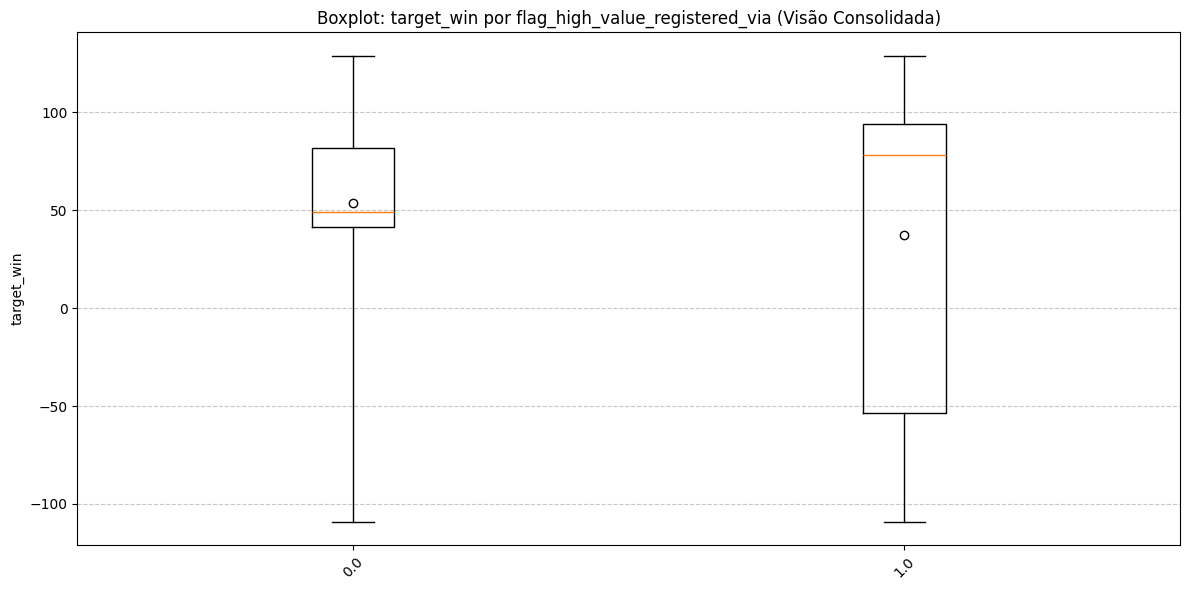


--- Estatísticas: flag_high_value_registered_via (Visão Consolidada) ---


flag_high_value_registered_via         min         q1        med  \
1                               0 -108.964925  41.491442  49.000000   
0                               1 -108.964925 -53.618059  78.259896   

        mean         q3         max  
1  53.874946  81.930892  128.953521  
0  37.201246  93.967321  128.953521

In [ ]:
plot_boxplot(df_base_members, ["flag_high_value_registered_via"], "target_win", agrupar_por_safra=False, table=True)

### 8.3.5. registration_init_time

As variáveis derivadas da data de registro podem capturar efeitos de coorte e sazonalidade, enquanto o `tenure` representa o estágio de vida do cliente. Essa separação evita vazamento de informação futura e melhora a estabilidade temporal do modelo.

#### 8.3.5.1. Variaveis derivadas da data de registro crua:

In [ ]:
df_base_members = (df_base_members
    .withColumn("mes_registro", F.month("registration_init_time"))
    .withColumn("trimestre_registro", F.quarter("registration_init_time"))
    .withColumn("ano_registro", F.year("registration_init_time")))

In [ ]:
calcular_distribuicao(df_base_members, ["mes_registro"], n_show=12)

+------------+-------+---------+
|mes_registro|total  |pct_total|
+------------+-------+---------+
|1           |1138465|10.13    |
|10          |1044471|9.29     |
|12          |1028114|9.14     |
|2           |1011064|8.99     |
|11          |985695 |8.77     |
|8           |970168 |8.63     |
|7           |945952 |8.41     |
|3           |933838 |8.31     |
|9           |909882 |8.09     |
|6           |782525 |6.96     |
|5           |767196 |6.82     |
|4           |725495 |6.45     |
+------------+-------+---------+



DataFrame[mes_registro: int, total: bigint, pct_total: double]

Processando estatísticas para: mes_registro...


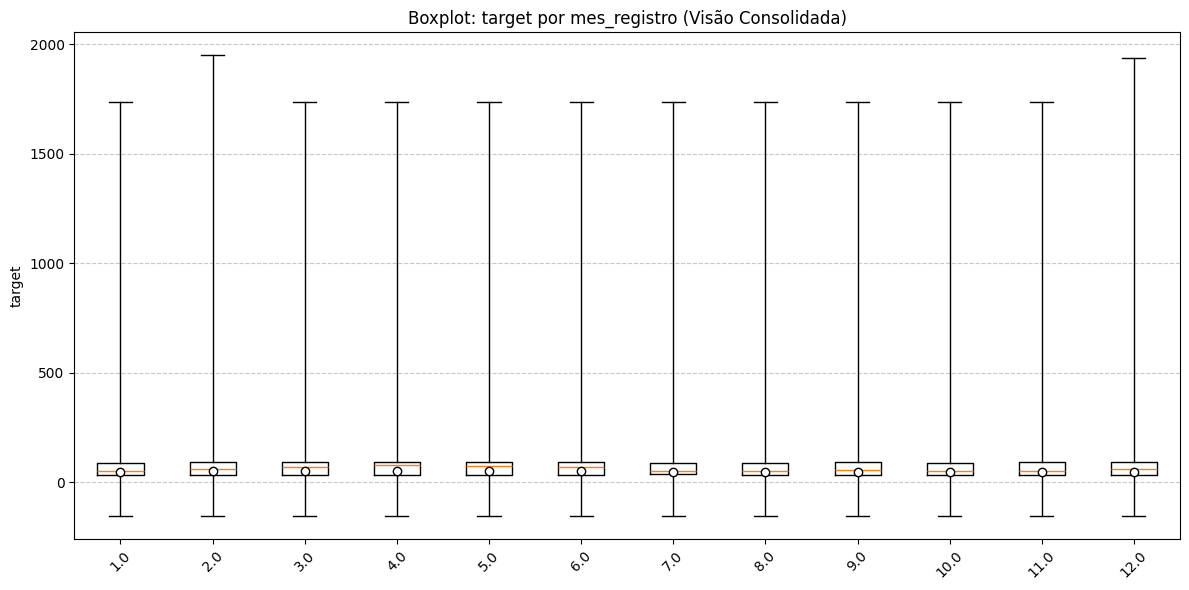


--- Estatísticas: mes_registro (Visão Consolidada) ---


mes_registro       min         q1        med       mean         q3  \
1              1 -152.5452  33.413119  49.000000  48.179317  89.735415   
11             2 -152.5452  33.467306  58.954065  49.423662  90.711468   
3              3 -152.5452  32.884107  69.052488  50.326457  92.112409   
6              4 -152.5452  30.952132  76.066708  51.784572  93.644680   
4              5 -152.5452  32.134202  71.795872  50.708674  92.580299   
2              6 -152.5452  30.688468  70.333983  49.988396  92.232552   
8              7 -152.5452  35.037880  49.000000  48.151462  89.016834   
7              8 -152.5452  33.716622  49.000000  47.850995  89.344076   
5              9 -152.5452  30.708981  57.641461  47.628053  90.416083   
9             10 -152.5452  32.221684  49.000000  47.659819  89.643036   
10            11 -152.5452  31.676893  50.000000  47.744721  89.877219   
0             12 -152.5452  31.619568  62.087429  48.455022  90.769493   

            max  
1   1736.630919  
11  1950.000000  
3   1737.484560  
6   1737.859653  
4   1736.196782  
2   1736.529083  
8   1737.929378  
7   1737.947047  
5   1737.711061  
9   1737.137480  
10  1736.679651  
0   1936.799455

In [ ]:
plot_boxplot(df_base_members, ["mes_registro"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: mes_registro...


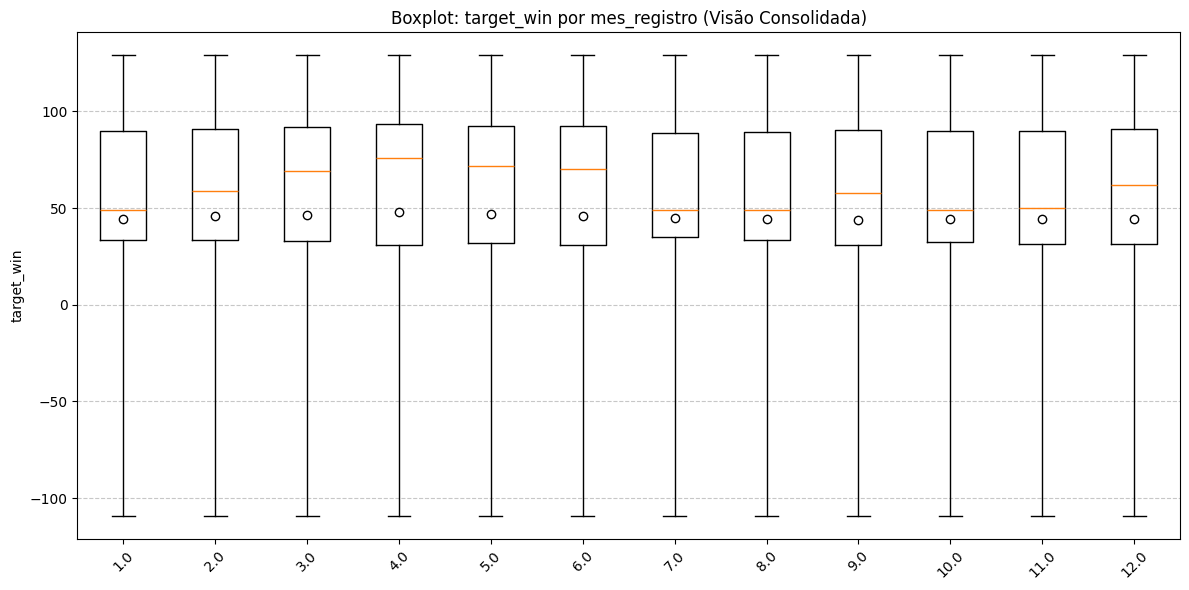


--- Estatísticas: mes_registro (Visão Consolidada) ---


mes_registro         min         q1        med       mean         q3  \
1              1 -108.964925  33.413119  49.000000  44.534899  89.735415   
11             2 -108.964925  33.467306  58.954065  45.720796  90.711468   
3              3 -108.964925  32.884107  69.052488  46.614519  92.112409   
6              4 -108.964925  30.952132  76.066708  47.952455  93.644680   
4              5 -108.964925  32.134202  71.795872  47.042047  92.580299   
2              6 -108.964925  30.688468  70.333983  46.131242  92.232552   
8              7 -108.964925  35.037880  49.000000  44.773423  89.016834   
7              8 -108.964925  33.716622  49.000000  44.249673  89.344076   
5              9 -108.964925  30.708981  57.641461  43.763939  90.416083   
9             10 -108.964925  32.221684  49.000000  44.086205  89.643036   
10            11 -108.964925  31.676893  50.000000  44.198344  89.877219   
0             12 -108.964925  31.619568  62.087429  44.600963  90.769493   

           max  
1   128.953521  
11  128.953521  
3   128.953521  
6   128.953521  
4   128.953521  
2   128.953521  
8   128.953521  
7   128.953521  
5   128.953521  
9   128.953521  
10  128.953521  
0   128.953521

In [ ]:
plot_boxplot(df_base_members, ["mes_registro"], "target_win", agrupar_por_safra=False, table=True)

Não vale a pena agrupar meses (perde sinal e não ganha robustez)

In [ ]:
calcular_distribuicao(df_base_members, ["trimestre_registro"], n_show=4)

+------------------+-------+---------+
|trimestre_registro|total  |pct_total|
+------------------+-------+---------+
|1                 |3083367|27.43    |
|4                 |3058280|27.2     |
|3                 |2826002|25.14    |
|2                 |2275216|20.24    |
+------------------+-------+---------+



DataFrame[trimestre_registro: int, total: bigint, pct_total: double]

Processando estatísticas para: trimestre_registro...


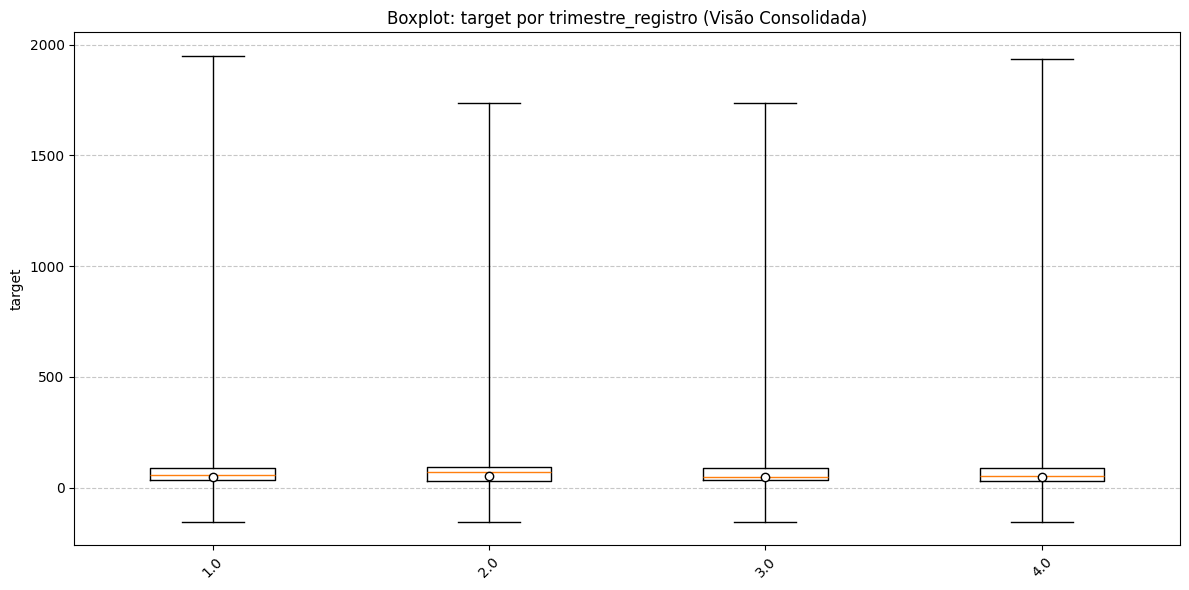


--- Estatísticas: trimestre_registro (Visão Consolidada) ---


trimestre_registro       min         q1        med       mean         q3  \
0                   1 -152.5452  33.292158  59.616697  49.233515  90.856801   
3                   2 -152.5452  31.267753  72.928165  50.806115  92.840961   
1                   3 -152.5452  33.433796  49.000000  47.880124  89.618422   
2                   4 -152.5452  31.869504  54.923554  47.952146  90.113312   

           max  
0  1950.000000  
3  1737.859653  
1  1737.947047  
2  1936.799455

In [ ]:
plot_boxplot(df_base_members, ["trimestre_registro"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: trimestre_registro...


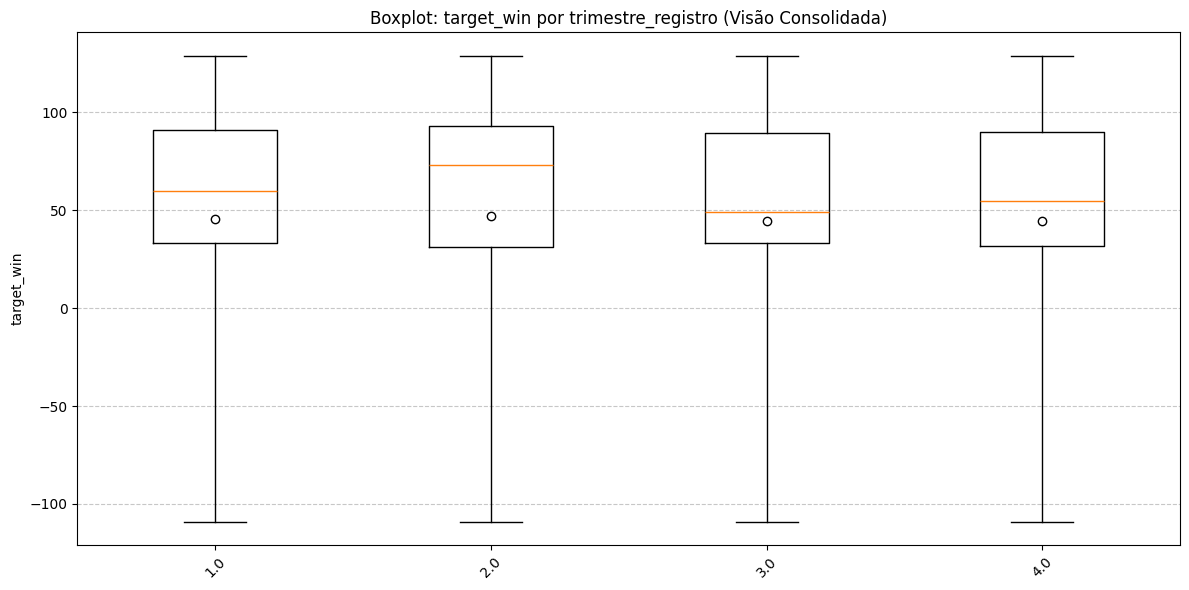


--- Estatísticas: trimestre_registro (Visão Consolidada) ---


trimestre_registro         min         q1        med       mean         q3  \
0                   1 -108.964925  33.292158  59.616697  45.549618  90.856801   
3                   2 -108.964925  31.267753  72.928165  47.021298  92.840961   
1                   3 -108.964925  33.433796  49.000000  44.269203  89.618422   
2                   4 -108.964925  31.869504  54.923554  44.293884  90.113312   

          max  
0  128.953521  
3  128.953521  
1  128.953521  
2  128.953521

In [ ]:
plot_boxplot(df_base_members, ["trimestre_registro"], "target_win", agrupar_por_safra=False, table=True)

Trimestre é melhor que mês para reduzir dimensionalidade

In [ ]:
calcular_distribuicao(df_base_members, ["ano_registro"], n_show=12)

Processando estatísticas para: ano_registro...


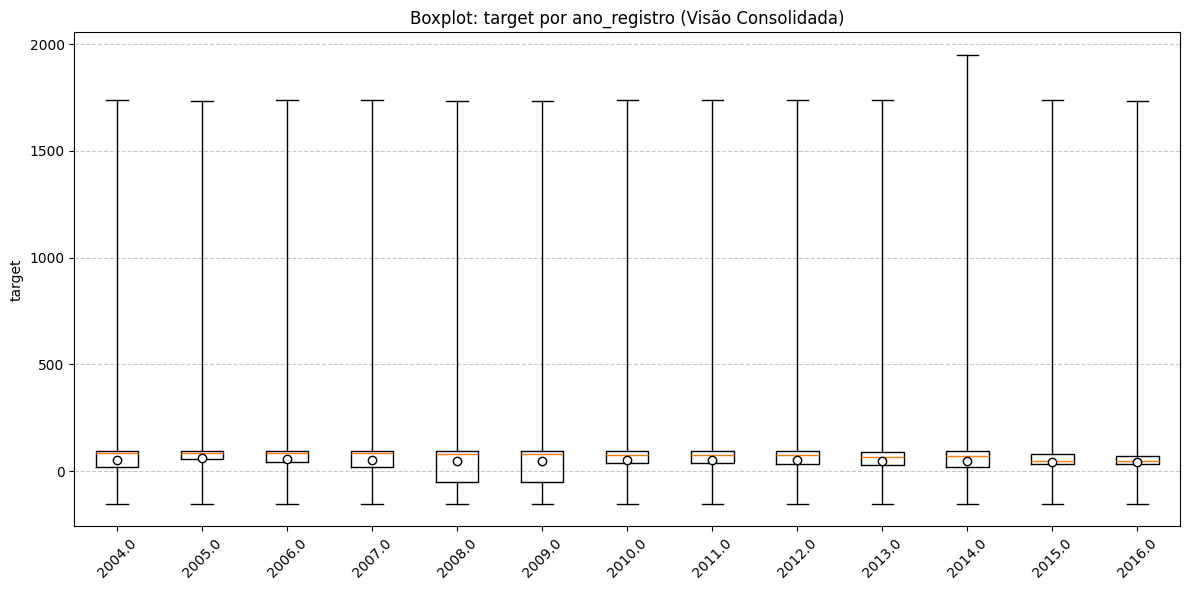


--- Estatísticas: ano_registro (Visão Consolidada) ---


ano_registro       min         q1        med       mean         q3  \
5           2004 -152.5452  18.457178  84.406246  53.718707  95.425231   
9           2005 -152.5452  58.455852  86.562108  61.592437  96.045108   
2           2006 -152.5452  42.620012  85.275801  56.844760  95.682332   
0           2007 -152.5452  17.382691  83.625064  53.413926  95.431529   
12          2008 -152.5452 -50.000000  82.145659  49.530973  94.828378   
7           2009 -152.5452 -51.178324  80.941019  46.843007  94.666346   
10          2010 -152.5452  39.725118  75.311775  53.683214  92.167655   
11          2011 -152.5452  39.096454  74.257053  53.867484  92.365950   
6           2012 -152.5452  32.150807  77.213247  52.438135  93.608246   
3           2013 -152.5452  30.347267  67.842465  49.359400  92.033185   
4           2014 -152.5452  21.638423  73.141249  49.201687  92.768451   
1           2015 -152.5452  32.362501  48.870233  44.258791  81.859895   
8           2016 -152.5452  34.686824  47.748474  43.585844  71.174377   

            max  
5   1737.137480  
9   1735.148557  
2   1737.241320  
0   1737.484560  
12  1735.253213  
7   1735.341114  
10  1737.947047  
11  1736.048807  
6   1737.640612  
3   1737.711061  
4   1950.000000  
1   1737.929378  
8   1735.710665

In [ ]:
plot_boxplot(df_base_members, ["ano_registro"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: ano_registro...


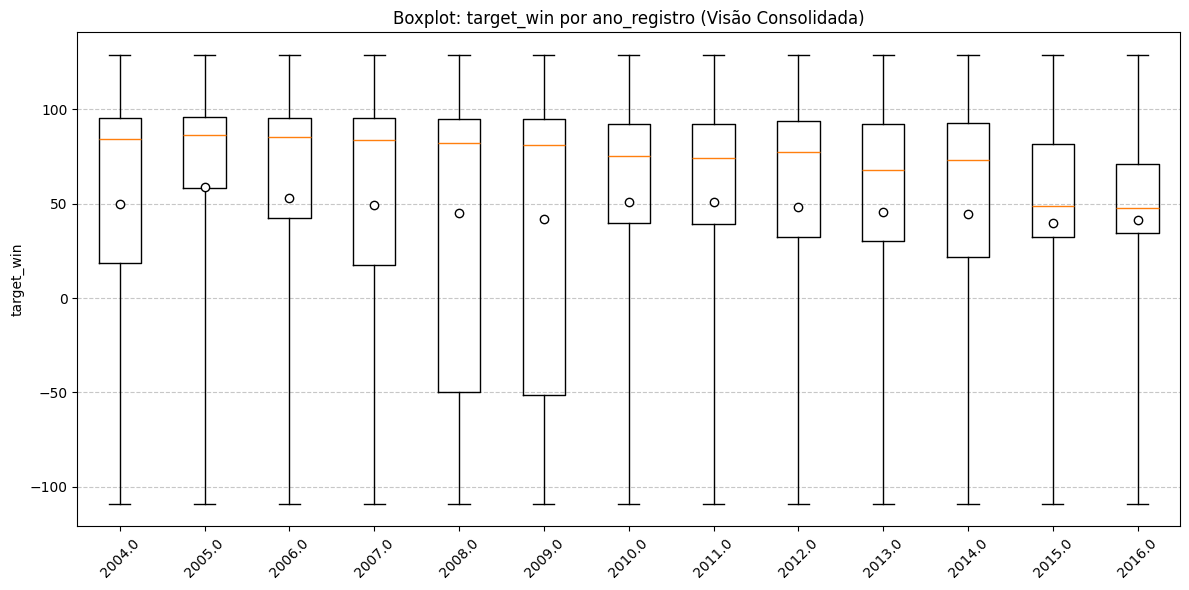


--- Estatísticas: ano_registro (Visão Consolidada) ---


ano_registro         min         q1        med       mean         q3  \
5           2004 -108.964925  18.457178  84.406246  49.734316  95.425231   
9           2005 -108.964925  58.455852  86.562108  58.630234  96.045108   
2           2006 -108.964925  42.620012  85.275801  53.210222  95.682332   
0           2007 -108.964925  17.382691  83.625064  49.425787  95.431529   
12          2008 -108.964925 -50.000000  82.145659  44.937708  94.828378   
7           2009 -108.964925 -51.178324  80.941019  42.121384  94.666346   
10          2010 -108.964925  39.725118  75.311775  50.814920  92.167655   
11          2011 -108.964925  39.096454  74.257053  51.075658  92.365950   
6           2012 -108.964925  32.150807  77.213247  48.478680  93.608246   
3           2013 -108.964925  30.347267  67.842465  45.654735  92.033185   
4           2014 -108.964925  21.638423  73.141249  44.438089  92.768451   
1           2015 -108.964925  32.362501  48.870233  40.039829  81.859895   
8           2016 -108.964925  34.686824  47.748474  41.332752  71.174377   

           max  
5   128.953521  
9   128.953521  
2   128.953521  
0   128.953521  
12  128.953521  
7   128.953521  
10  128.953521  
11  128.953521  
6   128.953521  
3   128.953521  
4   128.953521  
1   128.953521  
8   128.953521

In [ ]:
plot_boxplot(df_base_members, ["ano_registro"], "target_win", agrupar_por_safra=False, table=True)

Agrupar por ano parece bem melhor.

O que aparece claramente:

* 2004–2009: Mediana alta (~80+), Perfil mais volátil → base antiga, contratos distintos
* 2010–2014: Mediana ~68–77, Base mais “normalizada”
* 2015–2016: Mediana cai para ~48, Q3 cai forte (≈ 74–82), aparenta ser outro regime de negócio

Isso não é ruído estatístico, mas pode significar mudança de produto, mudança de pricing e/ou mudança de estratégia comercial

In [ ]:
df_base_members = df_base_members.withColumn("registration_year_regime",
    F.when(F.col("ano_registro").isin([2004, 2005, 2006, 2007, 2008, 2009]), "2004-2009")\
    .when(F.col("ano_registro").isin([2010, 2011, 2012, 2013, 2014]), "2010-2014")\
    .otherwise("2015+"))

Processando estatísticas para: registration_year_regime...


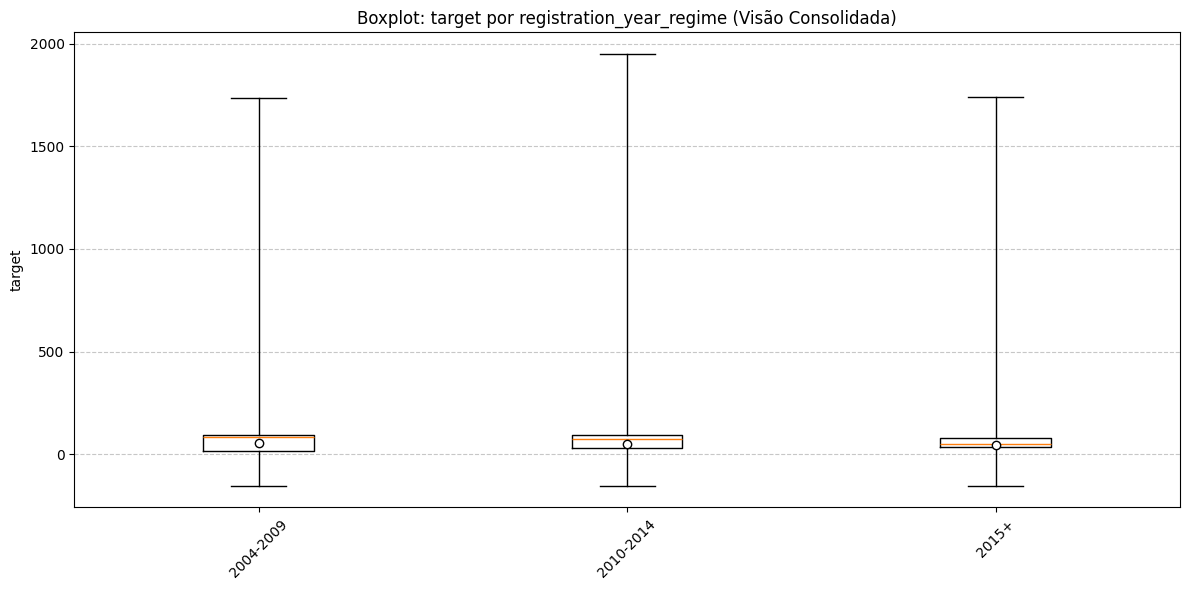


--- Estatísticas: registration_year_regime (Visão Consolidada) ---


registration_year_regime       min         q1        med       mean  \
1                2004-2009 -152.5452  17.305714  83.909292  53.531776   
0                2010-2014 -152.5452  32.279152  73.448129  51.115988   
2                    2015+ -152.5452  33.520024  48.451471  43.989022   

          q3          max  
1  95.381007  1737.484560  
0  92.638294  1950.000000  
2  78.717034  1737.929378

In [ ]:
plot_boxplot(df_base_members, ["registration_year_regime"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: registration_year_regime...


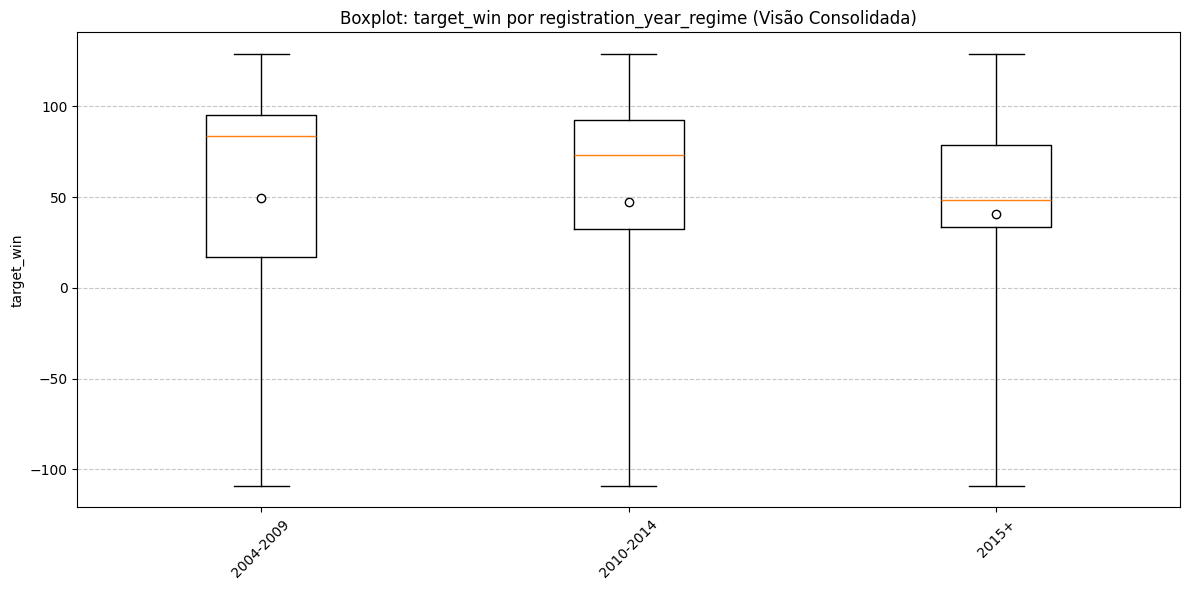


--- Estatísticas: registration_year_regime (Visão Consolidada) ---


registration_year_regime         min         q1        med       mean  \
1                2004-2009 -108.964925  17.305714  83.909292  49.535985   
0                2010-2014 -108.964925  32.279152  73.448129  47.343875   
2                    2015+ -108.964925  33.520024  48.451471  40.558132   

          q3         max  
1  95.381007  128.953521  
0  92.638294  128.953521  
2  78.717034  128.953521

In [ ]:
plot_boxplot(df_base_members, ["registration_year_regime"], "target_win", agrupar_por_safra=False, table=True)

#### 8.3.5.2. Tenure e faixa tenure

In [ ]:
df_base_members = df_base_members.withColumn("safra_date", F.to_date(F.concat(F.col("safra").cast("string"), F.lit("01")), "yyyyMMdd"))

In [ ]:
# tenure --> depois, faixa de tenure
df_base_members = (df_base_members
    .withColumn("tenure_meses", F.floor(F.months_between("safra_date", "registration_init_time")))
    .withColumn("tenure_meses", F.when(F.col("tenure_meses") < 0, 0).otherwise(F.col("tenure_meses"))))

In [ ]:
df_base_members.select("tenure_meses").summary("count", "mean", "stddev", "min", "1%", "5%", "25%", "50%", "75%", "95%", "99.5%", "max").show()

+-------+------------------+
|summary|      tenure_meses|
+-------+------------------+
|  count|          11242865|
|   mean| 37.65380247828289|
| stddev|35.163475062462894|
|    min|                 0|
|     1%|                 0|
|     5%|                 1|
|    25%|                 9|
|    50%|                29|
|    75%|                55|
|    95%|               115|
|  99.5%|               142|
|    max|               152|
+-------+------------------+



In [ ]:
# grau de correlacao de tenure com target
df_base_members.select("tenure_meses", "target").corr("tenure_meses", "target")

0.050579142535209023

In [ ]:
# grau de correlacao de tenure com target
df_base_members.select("tenure_meses", "target_win").corr("tenure_meses", "target_win")

0.06988654552048591

Tenure (continuo) tem efeito nao tao linear na target (aprox 7%).

In [ ]:
df_base_members = df_base_members.withColumn("tenure_faixa",
    F.when(F.col("tenure_meses").isNull(), "unknown")
    .when((F.col("tenure_meses") >= 0) & (F.col("tenure_meses") <= 1), "0-1")
    .when((F.col("tenure_meses") >= 2) & (F.col("tenure_meses") <= 3), "2-3")
    .when((F.col("tenure_meses") >= 4) & (F.col("tenure_meses") <= 6), "4-6")
    .when((F.col("tenure_meses") >= 7) & (F.col("tenure_meses") <= 11), "7-11")
    .otherwise("12+"))

In [ ]:
calcular_distribuicao(df_base_members, ["tenure_faixa"])

+------------+-------+---------+
|tenure_faixa|total  |pct_total|
+------------+-------+---------+
|12+         |7794615|69.33    |
|7-11        |1214335|10.8     |
|4-6         |863607 |7.68     |
|0-1         |802000 |7.13     |
|2-3         |568308 |5.05     |
+------------+-------+---------+



DataFrame[tenure_faixa: string, total: bigint, pct_total: double]

Processando estatísticas para: tenure_faixa...


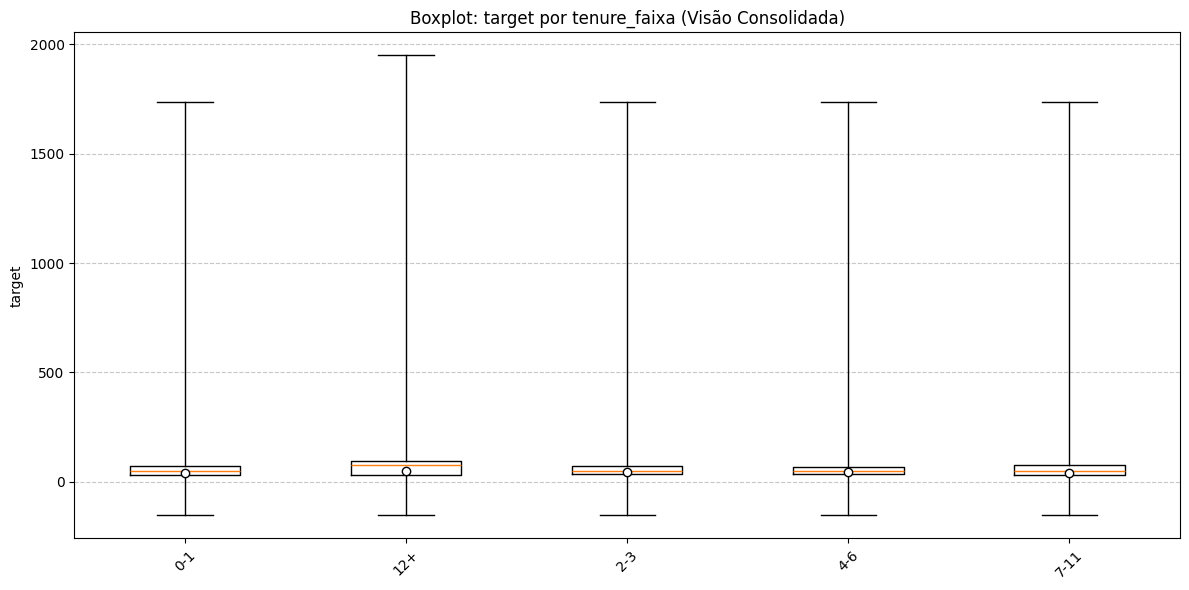


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa       min         q1        med       mean         q3  \
4          0-1 -152.5452  31.538681  47.465809  41.129891  72.814103   
3          12+ -152.5452  31.925361  75.409595  51.604072  93.259867   
0          2-3 -152.5452  34.456012  47.828648  42.698356  70.870518   
2          4-6 -152.5452  35.243553  48.090873  45.575029  70.098882   
1         7-11 -152.5452  31.961867  48.353974  41.364531  75.637094   

           max  
4  1736.987900  
3  1950.000000  
0  1734.872871  
2  1737.929378  
1  1736.589444

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: tenure_faixa...


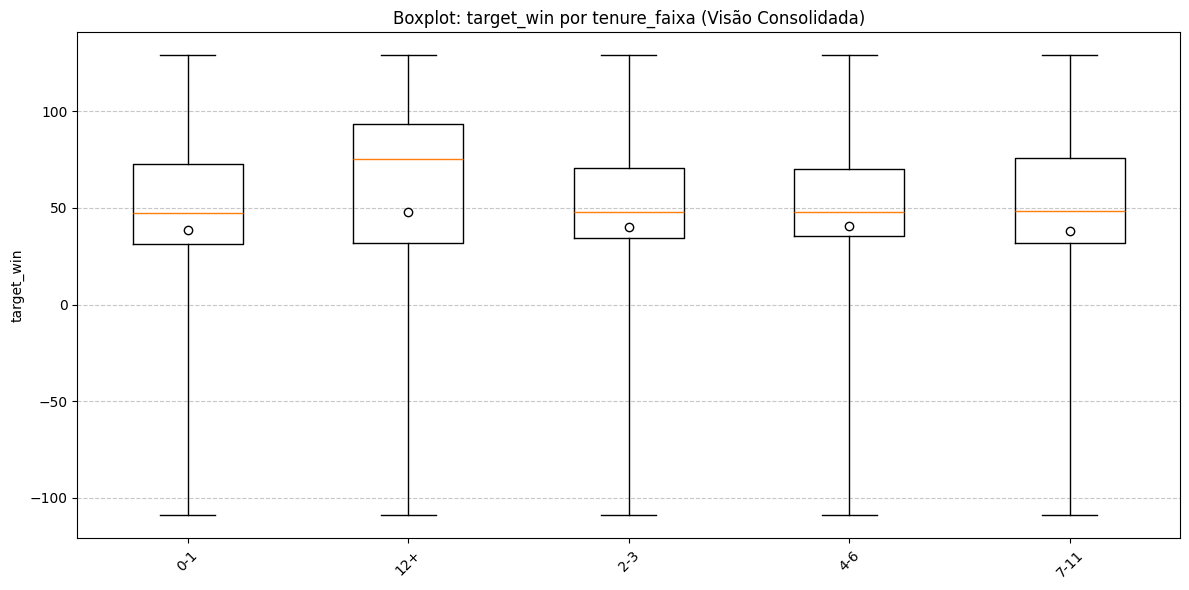


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa         min         q1        med       mean         q3  \
4          0-1 -108.964925  31.538681  47.465809  38.347386  72.814103   
3          12+ -108.964925  31.925361  75.409595  47.778133  93.259867   
0          2-3 -108.964925  34.456012  47.828648  40.373396  70.870518   
2          4-6 -108.964925  35.243553  48.090873  40.787534  70.098882   
1         7-11 -108.964925  31.961867  48.353974  38.208869  75.637094   

          max  
4  128.953521  
3  128.953521  
0  128.953521  
2  128.953521  
1  128.953521

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target_win", agrupar_por_safra=False, table=True)

Percebe-se que `tenure_faixa` em 12+ equivale a quase 70% da base, e as estatisticas das categorias distintas desta sao muito similares.

Talvez considerar mais agrupamentos pra `faixa_tenure`?

In [ ]:
df_base_members = df_base_members.withColumn("tenure_faixa",
    F.when(F.col("tenure_meses").isNull(), "unknown")
    .when((F.col("tenure_meses") >= 0) & (F.col("tenure_meses") <= 11), "0-11")
    .when((F.col("tenure_meses") >= 12) & (F.col("tenure_meses") <= 23), "12-23")
    .otherwise("24+"))

In [ ]:
calcular_distribuicao(df_base_members, ["tenure_faixa"])

+------------+-------+---------+
|tenure_faixa|total  |pct_total|
+------------+-------+---------+
|24+         |6318740|56.2     |
|0-11        |3448250|30.67    |
|12-23       |1475875|13.13    |
+------------+-------+---------+



DataFrame[tenure_faixa: string, total: bigint, pct_total: double]

Processando estatísticas para: tenure_faixa...


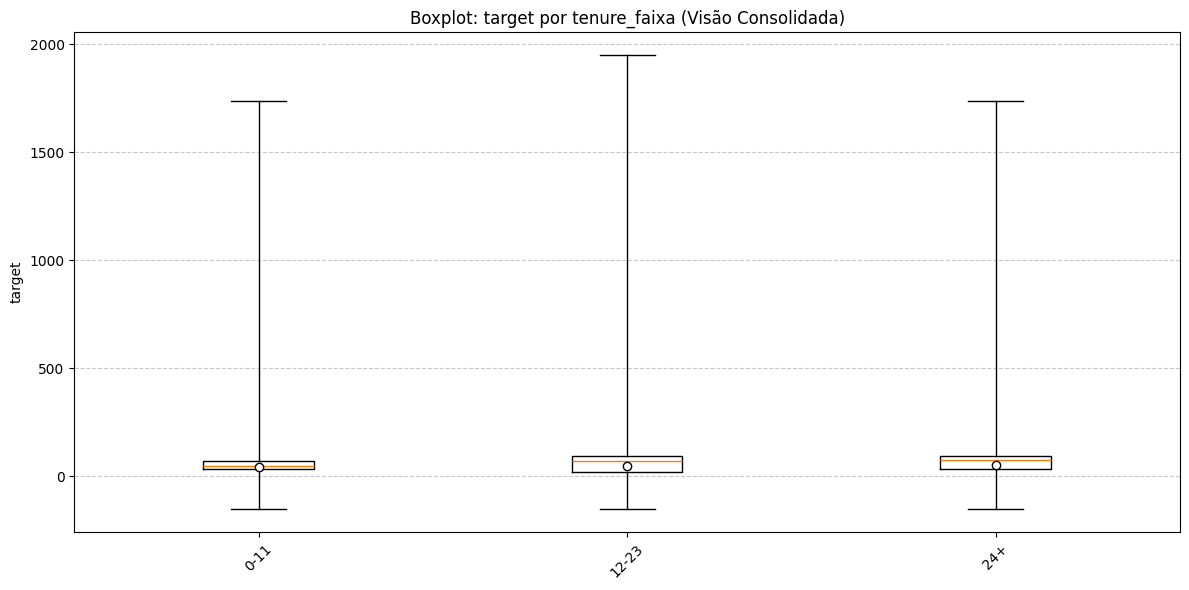


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa       min         q1        med       mean         q3  \
2         0-11 -152.5452  33.258711  47.998934  42.593287  73.089370   
1        12-23 -152.5452  21.884712  70.753704  48.995900  92.209199   
0          24+ -152.5452  33.449292  76.199077  52.178311  93.457863   

           max  
2  1737.929378  
1  1950.000000  
0  1737.947047

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: tenure_faixa...


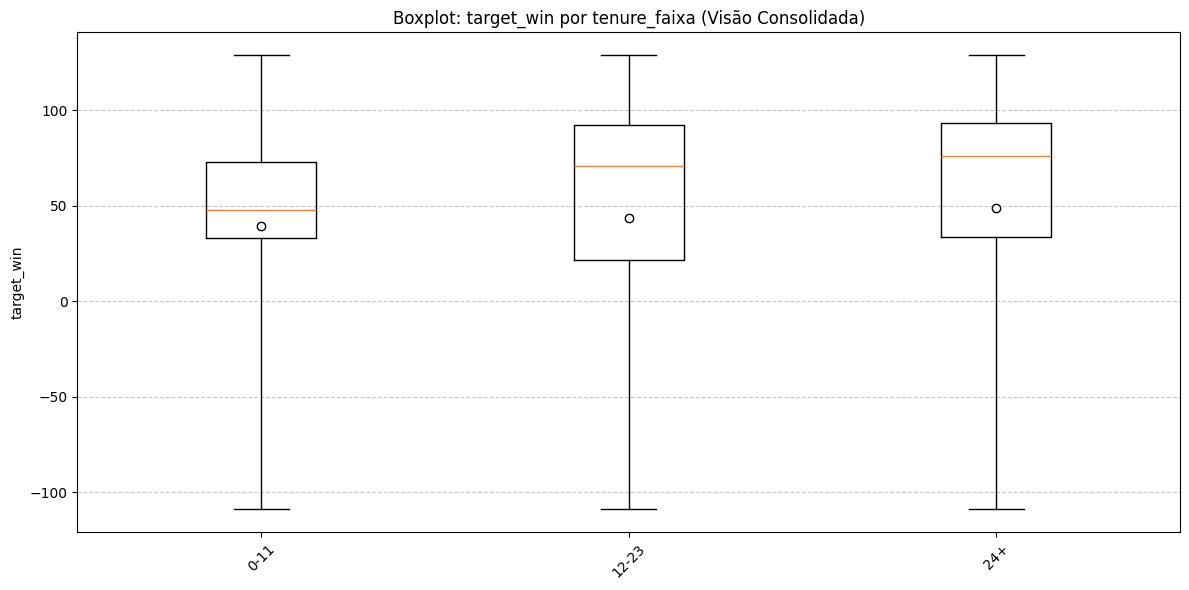


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa         min         q1        med       mean         q3  \
2         0-11 -108.964925  33.258711  47.998934  39.250497  73.089370   
1        12-23 -108.964925  21.884712  70.753704  43.855336  92.209199   
0          24+ -108.964925  33.449292  76.199077  48.641813  93.457863   

          max  
2  128.953521  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target_win", agrupar_por_safra=False, table=True)

In [ ]:
df_base_members = df_base_members.withColumn("tenure_faixa",
    F.when(F.col("tenure_meses").isNull(), "unknown")
    .when((F.col("tenure_meses") >= 0) & (F.col("tenure_meses") <= 11), "0-11")
    .when((F.col("tenure_meses") >= 12) & (F.col("tenure_meses") <= 23), "12-23")
    .when((F.col("tenure_meses") >= 24) & (F.col("tenure_meses") <= 35), "24-35")
    .otherwise("36+"))

In [ ]:
calcular_distribuicao(df_base_members, ["tenure_faixa"])

+------------+-------+---------+
|tenure_faixa|total  |pct_total|
+------------+-------+---------+
|36+         |4758009|42.32    |
|0-11        |3448250|30.67    |
|24-35       |1560731|13.88    |
|12-23       |1475875|13.13    |
+------------+-------+---------+



DataFrame[tenure_faixa: string, total: bigint, pct_total: double]

Processando estatísticas para: tenure_faixa...


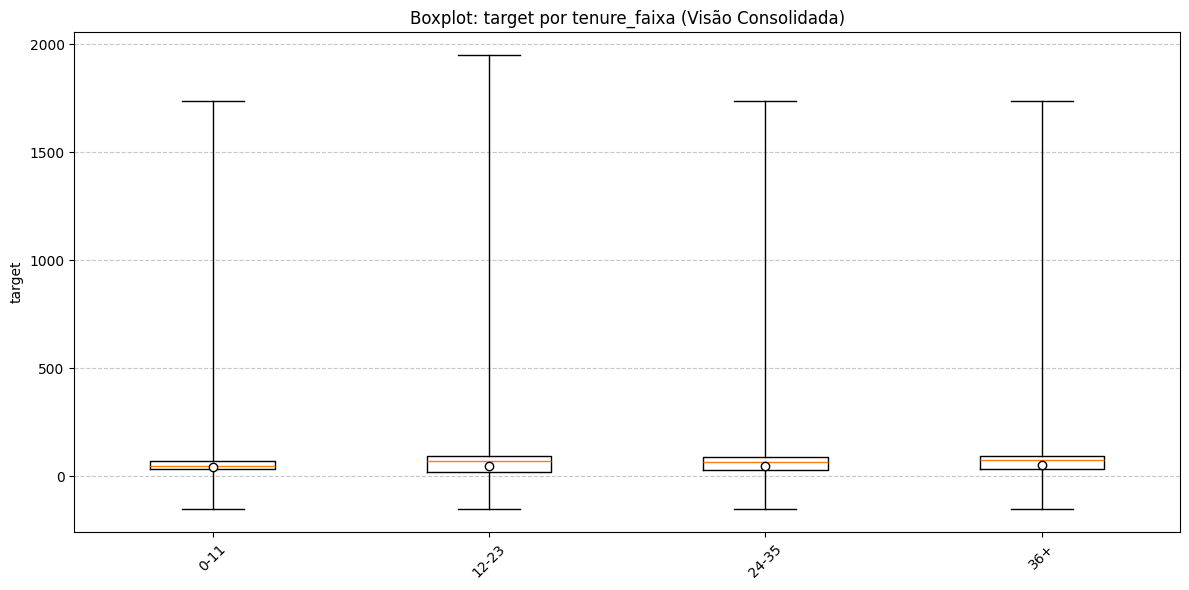


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa       min         q1        med       mean         q3  \
3         0-11 -152.5452  33.258711  47.998934  42.593287  73.089370   
1        12-23 -152.5452  21.884712  70.753704  48.995900  92.209199   
0        24-35 -152.5452  31.513138  65.153832  49.456383  91.685049   
2          36+ -152.5452  34.457785  78.161693  53.087818  93.915124   

           max  
3  1737.929378  
1  1950.000000  
0  1737.711061  
2  1737.947047

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: tenure_faixa...


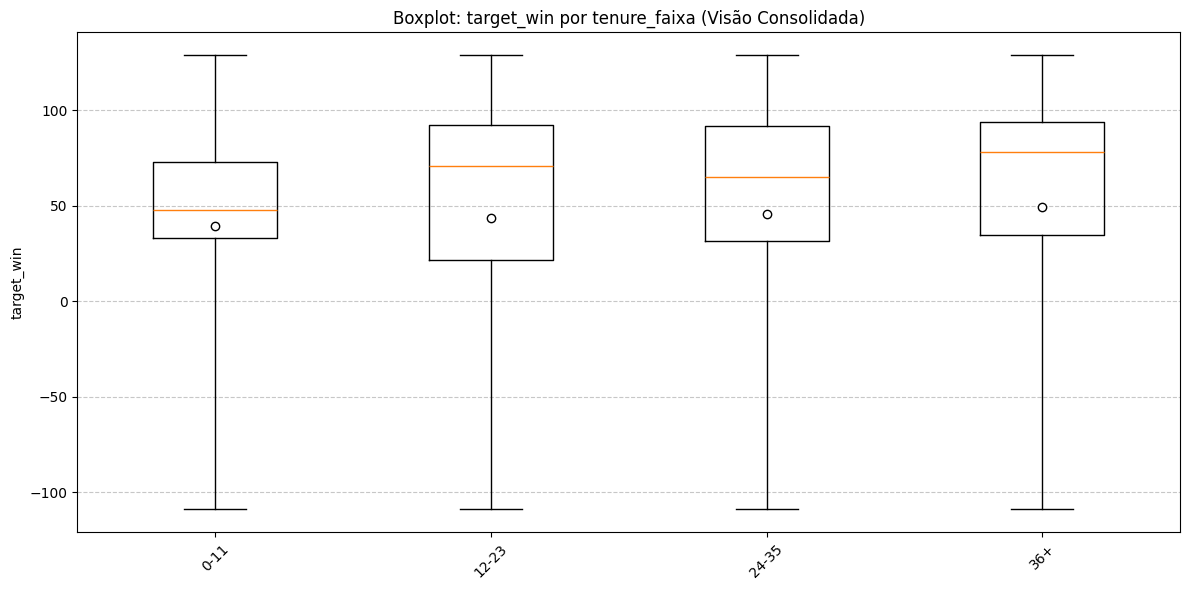


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa         min         q1        med       mean         q3  \
3         0-11 -108.964925  33.258711  47.998934  39.250497  73.089370   
1        12-23 -108.964925  21.884712  70.753704  43.855336  92.209199   
0        24-35 -108.964925  31.513138  65.153832  45.681294  91.685049   
2          36+ -108.964925  34.457785  78.161693  49.631042  93.915124   

          max  
3  128.953521  
1  128.953521  
0  128.953521  
2  128.953521

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target_win", agrupar_por_safra=False, table=True)

Valores estao comecando a se aproximar mais. Talvez seja melhor considerar a de menor numero de categorias. Vou agrupar as duas intermediarias e subir mais.

In [ ]:
df_base_members = df_base_members.withColumn("tenure_faixa",
    F.when(F.col("tenure_meses").isNull(), "unknown")
    .when((F.col("tenure_meses") >= 0) & (F.col("tenure_meses") <= 11), "0-11")
    .when((F.col("tenure_meses") >= 12) & (F.col("tenure_meses") <= 35), "12-35")
    .when((F.col("tenure_meses") >= 36) & (F.col("tenure_meses") <= 47), "36-47")
    .otherwise("48+"))

In [ ]:
calcular_distribuicao(df_base_members, ["tenure_faixa"])

+------------+-------+---------+
|tenure_faixa|total  |pct_total|
+------------+-------+---------+
|48+         |3484122|30.99    |
|0-11        |3448250|30.67    |
|12-35       |3036606|27.01    |
|36-47       |1273887|11.33    |
+------------+-------+---------+



DataFrame[tenure_faixa: string, total: bigint, pct_total: double]

Processando estatísticas para: tenure_faixa...


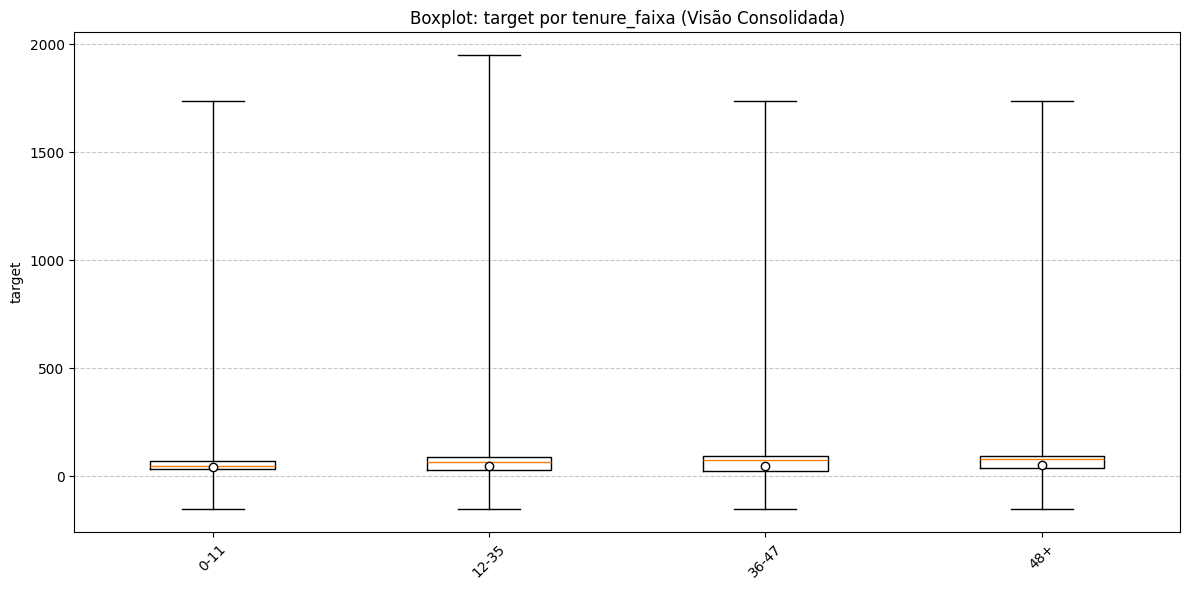


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa       min         q1        med       mean         q3  \
3         0-11 -152.5452  33.258711  47.998934  42.593287  73.089370   
2        12-35 -152.5452  28.534129  68.220781  49.240957  91.940411   
1        36-47 -152.5452  26.563645  75.510011  50.486417  93.348304   
0          48+ -152.5452  37.091280  78.810260  54.018694  94.098520   

           max  
3  1737.929378  
2  1950.000000  
1  1737.640612  
0  1737.947047

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: tenure_faixa...


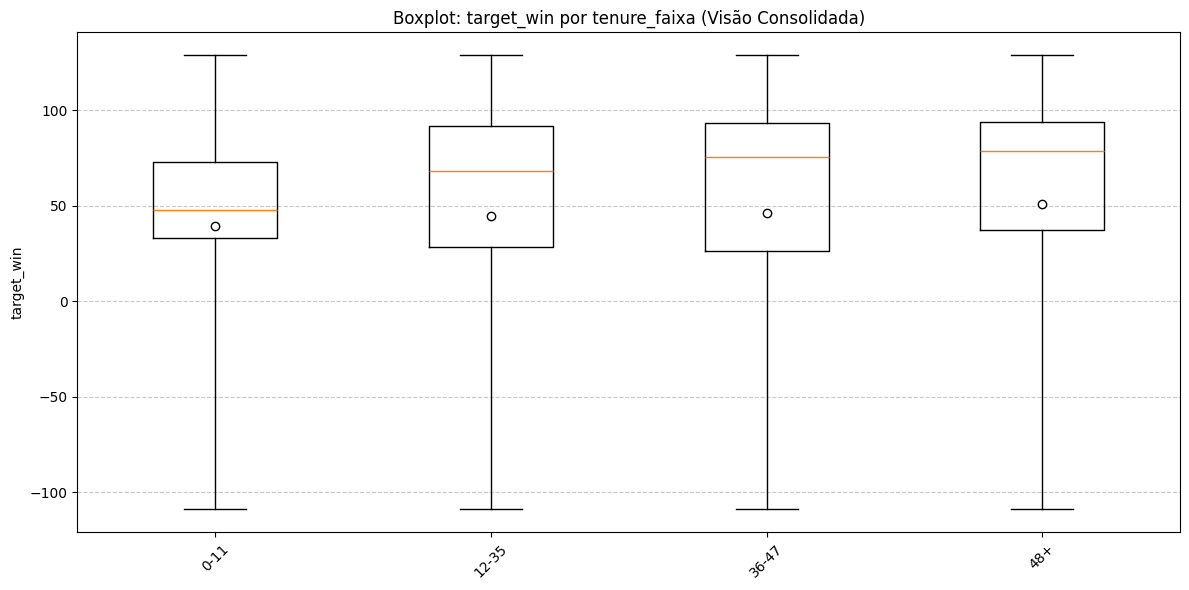


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa         min         q1        med       mean         q3  \
3         0-11 -108.964925  33.258711  47.998934  39.250497  73.089370   
2        12-35 -108.964925  28.534129  68.220781  44.827065  91.940411   
1        36-47 -108.964925  26.563645  75.510011  46.371666  93.348304   
0          48+ -108.964925  37.091280  78.810260  50.797366  94.098520   

          max  
3  128.953521  
2  128.953521  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target_win", agrupar_por_safra=False, table=True)

In [ ]:
df_base_members = df_base_members.withColumn("tenure_faixa",
    F.when(F.col("tenure_meses").isNull(), "unknown")
    .when((F.col("tenure_meses") >= 0) & (F.col("tenure_meses") <= 11), "0-11")
    .when((F.col("tenure_meses") >= 12) & (F.col("tenure_meses") <= 35), "12-35")
    .otherwise("36+"))

In [ ]:
calcular_distribuicao(df_base_members, ["tenure_faixa"])

+------------+-------+---------+
|tenure_faixa|total  |pct_total|
+------------+-------+---------+
|36+         |4758009|42.32    |
|0-11        |3448250|30.67    |
|12-35       |3036606|27.01    |
+------------+-------+---------+



DataFrame[tenure_faixa: string, total: bigint, pct_total: double]

Processando estatísticas para: tenure_faixa...


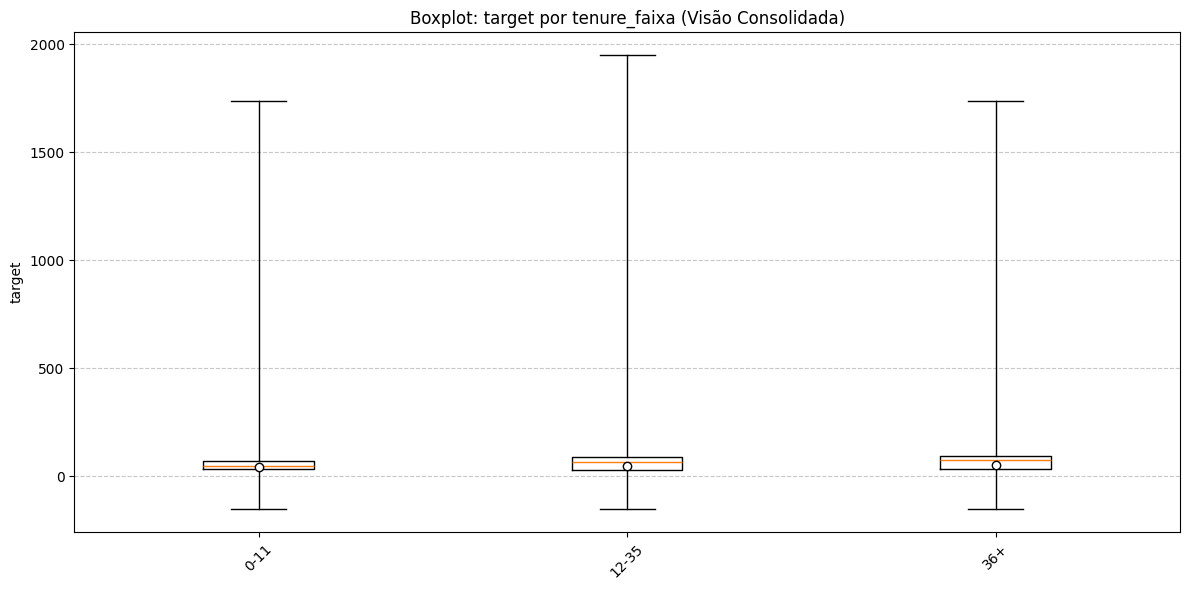


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa       min         q1        med       mean         q3  \
2         0-11 -152.5452  33.258711  47.998934  42.593287  73.089370   
0        12-35 -152.5452  28.534129  68.220781  49.240957  91.940411   
1          36+ -152.5452  34.457785  78.161693  53.087818  93.915124   

           max  
2  1737.929378  
0  1950.000000  
1  1737.947047

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: tenure_faixa...


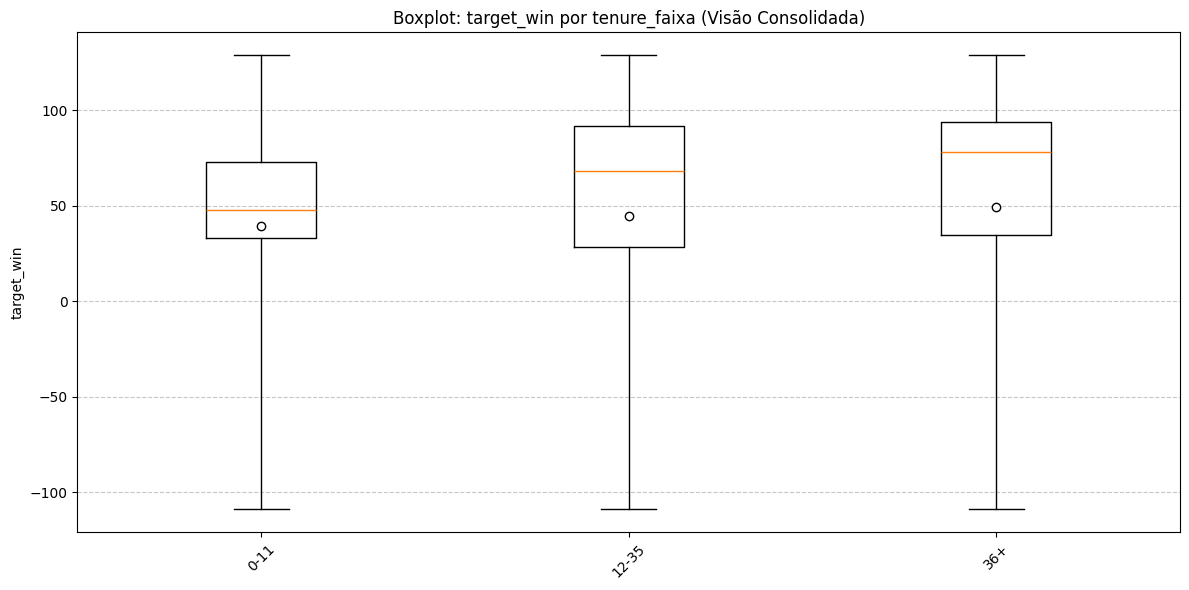


--- Estatísticas: tenure_faixa (Visão Consolidada) ---


tenure_faixa         min         q1        med       mean         q3  \
2         0-11 -108.964925  33.258711  47.998934  39.250497  73.089370   
0        12-35 -108.964925  28.534129  68.220781  44.827065  91.940411   
1          36+ -108.964925  34.457785  78.161693  49.631042  93.915124   

          max  
2  128.953521  
0  128.953521  
1  128.953521

In [ ]:
plot_boxplot(df_base_members, ["tenure_faixa"], "target_win", agrupar_por_safra=False, table=True)

Esta aparenta ser a melhor versao, a considerar a analise das medianas (como a distribuicao nao e simetrica, melhor concluir pela mediana, como estamos fazendo ao longo do projeto). A primeira divisao feita (0–11 / 12–23 / 24+) tambem era boa, porem, mistura usuários muito maduros (36+, 48+) com “intermediários”.

**Criacao de uma flag para simbolizar long tenure**

In [ ]:
df_base_members = df_base_members.withColumn("flag_long_tenure", F.when(F.col("tenure_meses") >= 36, 1).otherwise(0))

In [ ]:
calcular_distribuicao(df_base_members, ["flag_long_tenure"], n_show=2)

+----------------+-------+---------+
|flag_long_tenure|total  |pct_total|
+----------------+-------+---------+
|0               |6484856|57.68    |
|1               |4758009|42.32    |
+----------------+-------+---------+



DataFrame[flag_long_tenure: int, total: bigint, pct_total: double]

Processando estatísticas para: flag_long_tenure...


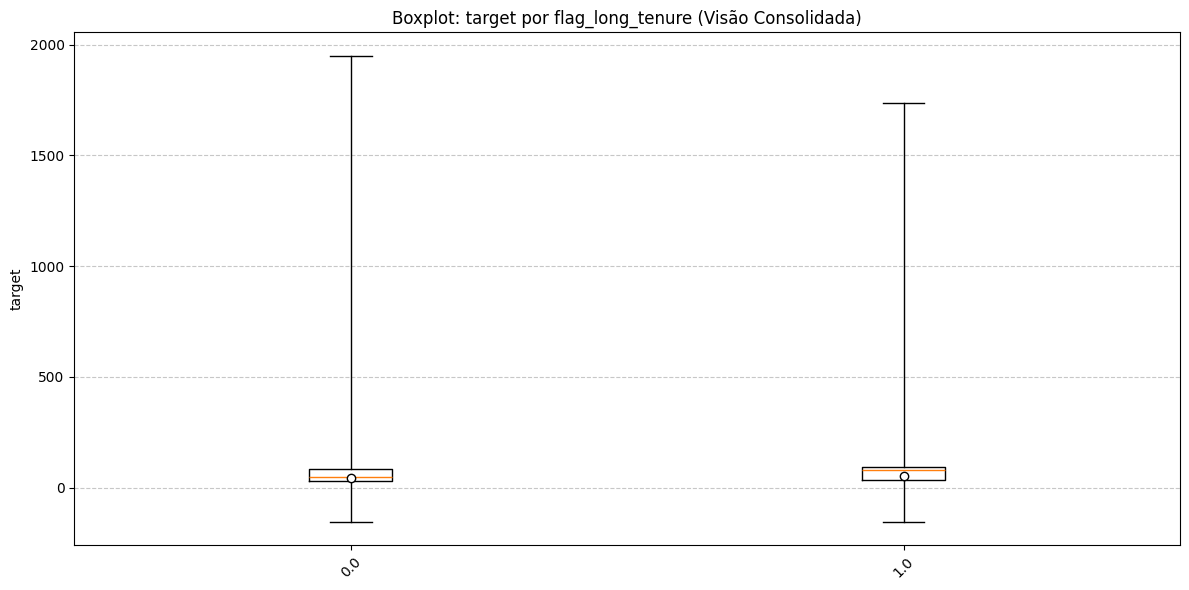


--- Estatísticas: flag_long_tenure (Visão Consolidada) ---


flag_long_tenure       min         q1        med       mean         q3  \
1                 0 -152.5452  31.933910  49.000000  45.708881  86.440688   
0                 1 -152.5452  34.457785  78.161693  53.087818  93.915124   

           max  
1  1950.000000  
0  1737.947047

In [ ]:
plot_boxplot(df_base_members, ["flag_long_tenure"], "target", agrupar_por_safra=False, table=True)

Processando estatísticas para: flag_long_tenure...


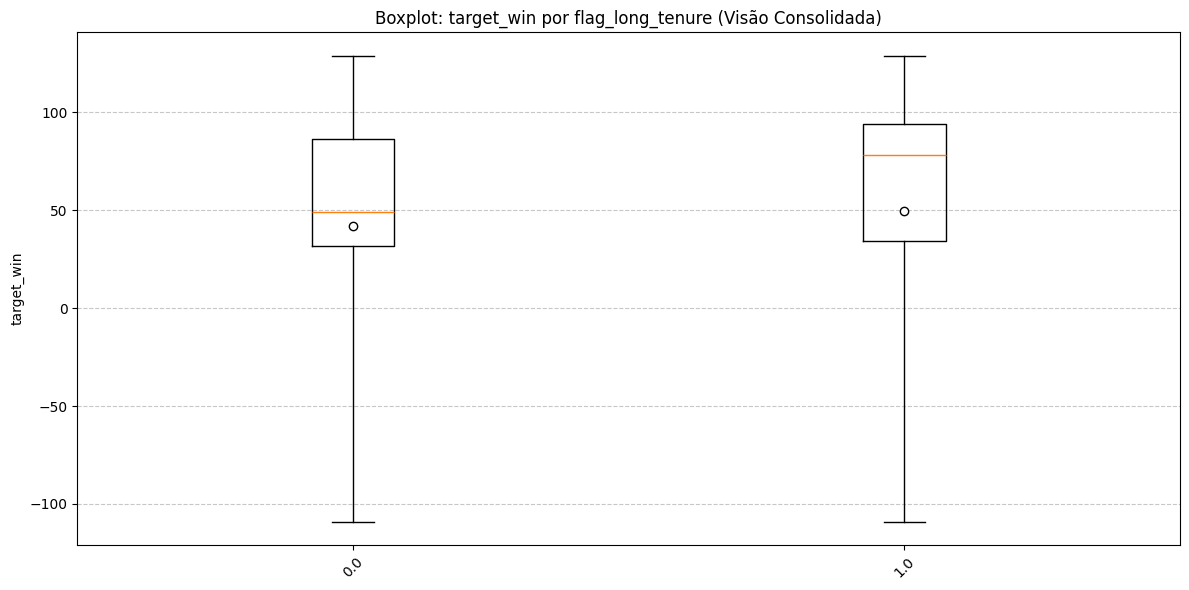


--- Estatísticas: flag_long_tenure (Visão Consolidada) ---


flag_long_tenure         min         q1        med       mean         q3  \
1                 0 -108.964925  31.933910  49.000000  41.864093  86.440688   
0                 1 -108.964925  34.457785  78.161693  49.631042  93.915124   

          max  
1  128.953521  
0  128.953521

In [ ]:
plot_boxplot(df_base_members, ["flag_long_tenure"], "target_win", agrupar_por_safra=False, table=True)

**Conclusao**

Levar tanto a flag quanto a variavel agrupada para feature engineering. A flag se mostra muito util para Elastic Net, enquanto a variavel agrupada para os modelos baseados em arvores.